# Experiments for asynchronous gate and expert training with different datasets

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [3]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cuda:0


In [6]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from moe_models.moe_stochastic_model import moe_stochastic_model
# from moe_models.moe_no_gate_model import moe_no_gate_model
from helper.moe_models import cross_entropy_loss, stochastic_loss
from helper.visualise_results import *

device cuda:0
device cuda:0
device cuda:0
device cuda:0
device cuda:0


### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Load MNIST dataset

In [7]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures'
model_path = '../models'
results_path = '../results'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(results_path):
    os.mkdir(results_path)            

In [8]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]) 

In [9]:
trainsize = 60000
testsize = 10000

In [10]:
# Load and split data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=mnist_transform,
    target_transform = torch.tensor,                                 
    )
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=mnist_transform,
    target_transform = torch.tensor,)

batch_size = 128
# dataloaders
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(testsize)),
                                         batch_size=batch_size,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))


Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


tensor(-0.4242) tensor(2.8215)
Data samples


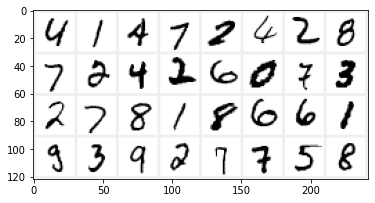

In [11]:
# create grid of images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(min(images[0].flatten()),max(images[0].flatten()) )
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


### Create combined rotated and unrotated MNIST image dataset of the digits 1-5

In [12]:
from PIL import Image
def rotate_dataset(d, rotation):
    result = torch.FloatTensor(d.size(0), 1, 28,28)
    tensor = transforms.ToTensor()
    norm = transforms.Normalize((0.1307,), (0.3081,))
    
    for i in range(d.size(0)):
        img = Image.fromarray(d[i].numpy(), mode='L')
        result[i] = norm(TF.rotate(tensor(img), rotation))
    return result

In [13]:
rot = 90

rot_train = rotate_dataset(trainset.data, rot)
rot_test= rotate_dataset(testset.data, rot)

In [14]:
# Function to extract subset of classes from the datasets
def filter_classes(classes_sub, classes_full, size, targets):
    print(classes_sub)
    start = 0
    labels = targets
    index = []
    per_class_size = ceil(size/len(classes_sub))
    for t in classes_sub:
        i = classes_full.index(t)
        index += list(np.where(labels == i)[0])[0:per_class_size]
    return index[0:size]

In [15]:
classes_mnist = ['0','1','2','3','4','5','6','7','8','9']

In [16]:
mnist_indices_train = filter_classes(classes_mnist[0:5], classes_mnist, int(trainsize/2), trainset.targets)
mnist_indices_test = filter_classes(classes_mnist[0:5], classes_mnist, int(testsize/2), testset.targets)

['0', '1', '2', '3', '4']
['0', '1', '2', '3', '4']


In [17]:
# shifting the labels by 5 to avoid overlap when selecting digits 1-5
classes_rot_mnist = ['5','6','7','8','9','10','11','12','13','14']

In [18]:
rot_trainset = TensorDataset(rot_train, trainset.targets+5)
rot_testset = TensorDataset(rot_test, testset.targets+5)

In [19]:
len(rot_trainset)
len(trainset)

60000

In [20]:
rot_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(rot_trainset,mnist_indices_train), batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
rot_testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(rot_trainset,mnist_indices_test), batch_size=len(mnist_indices_test),
                                         shuffle=True, num_workers=1, pin_memory=True)

Data samples


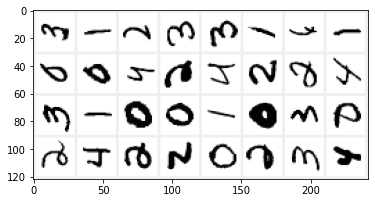

In [21]:
# create grid of images
dataiter = iter(rot_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


In [22]:
rot_unrot_trainset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(trainset,mnist_indices_train), 
                                                 torch.utils.data.Subset(rot_trainset,mnist_indices_train)])
rot_unrot_testset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(testset,mnist_indices_test),
                                                torch.utils.data.Subset(rot_testset,mnist_indices_test)])

In [23]:
rot_unrot_trainloader = torch.utils.data.DataLoader(rot_unrot_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
rot_unrot_testloader = torch.utils.data.DataLoader(rot_unrot_testset, batch_size=len(rot_unrot_testset),
                                         shuffle=True, num_workers=1, pin_memory=True)

In [24]:
classes_rot_unrot = list(range(5))+['rot '+str(i) for i in range(5)]
classes_rot_unrot

[0, 1, 2, 3, 4, 'rot 0', 'rot 1', 'rot 2', 'rot 3', 'rot 4']

Data samples


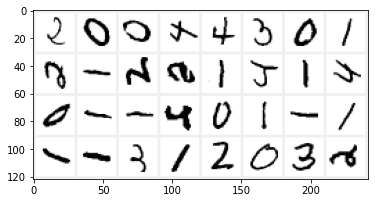

In [25]:
# create grid of images
dataiter = iter(rot_unrot_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


## Create combined FMNIST and MNIST dataset

In [26]:
# transforms: Convert PIL image to tensors and normalize
fmnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.2859,), (0.3530,))]) 

In [27]:
fmnist_trainset = torchvision.datasets.FashionMNIST('data', transform=fmnist_transform, train=True, download=True)

In [28]:
fmnist_testset = torchvision.datasets.FashionMNIST('data',transform=fmnist_transform, train=False)

In [29]:
# Since we are combining the fashion mnist and mnist data that have the same numerical labels from 0-9 
# we want to offset the mnist target so there is no overlap of the labels
def target_transform(target):
    return target+2

In [30]:
mnist_trainset = torchvision.datasets.MNIST('data', transform=mnist_transform, target_transform=target_transform, train=True, download=True)

In [31]:
mnist_testset = torchvision.datasets.MNIST('data',transform=mnist_transform, target_transform=target_transform, train=False)

In [32]:
classes_fmnist = ['t-shirt', 'Trouser', 'Pullover','Dress','Coat','Sandal',
                  'Shirt','Sneaker','Bag','Ankle boot']
classes_mnist = ['0','1','2','3','4','5','6','7','8','9']

# Combined fmnist and mnist classes. 
classes_fmnist_mnist = classes_fmnist[0:6]+[str(n) for n in range(4,10)]
print('classes_fmnist_mnist', classes_fmnist_mnist)

classes_fmnist_mnist ['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', '4', '5', '6', '7', '8', '9']


In [33]:
# Function to extract subset of classes from the datasets
def filter_classes(classes_sub, classes_full, size, data):
    print(classes_sub)
    start = 0
    labels = data.targets
    index = []
    per_class_size = ceil(size/len(classes_sub))
    for t in classes_sub:
        i = classes_full.index(t)
        index += list(np.where(labels == i)[0])[0:per_class_size]
    return index[0:size]

In [34]:
# Get the data for first 6 classes of fmnist dataset
fmnist_indices_train = filter_classes(classes_fmnist[0:6], classes_fmnist, int(trainsize/2), fmnist_trainset)
fmnist_indices_test = filter_classes(classes_fmnist[0:6], classes_fmnist, int(testsize/2), fmnist_testset)

['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal']
['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal']


In [35]:
fmnist_trainset.targets[fmnist_indices_train]

tensor([0, 0, 0,  ..., 5, 5, 5])

In [36]:
# Get the data for last 6 classes of fmnist dataset
mnist_indices_train = filter_classes(classes_mnist[4:], classes_mnist, int(trainsize/2), mnist_trainset)
mnist_indices_test = filter_classes(classes_mnist[4:], classes_mnist, int(testsize/2), mnist_testset)

['4', '5', '6', '7', '8', '9']
['4', '5', '6', '7', '8', '9']


In [37]:
# Create the combined dataset with fmnist and mnist classes
fmnist_mnist_trainset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(fmnist_trainset,fmnist_indices_train), 
                         torch.utils.data.Subset(mnist_trainset,mnist_indices_train)])
fmnist_mnist_testset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(fmnist_testset,fmnist_indices_test), 
                        torch.utils.data.Subset(mnist_testset,mnist_indices_test)])
train_size = len(fmnist_indices_train)+len(mnist_indices_train)
test_size = len(fmnist_indices_test)+len(mnist_indices_test)
print("Train size", train_size)
print("Test size", test_size)

Train size 60000
Test size 10000


In [38]:
fmnist_mnist_trainloader = torch.utils.data.DataLoader(fmnist_mnist_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0, pin_memory=True)
fmnist_mnist_testloader = torch.utils.data.DataLoader(fmnist_mnist_testset, batch_size=len(fmnist_mnist_testset),
                                         shuffle=True, num_workers=0, pin_memory=True)

In [39]:
num_classes_fmnist_mnist = len(classes_fmnist_mnist)

Data samples


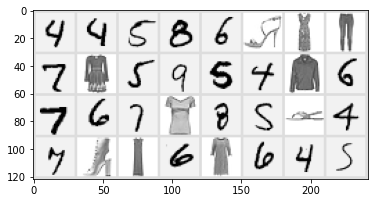

In [40]:
# create grid of images
dataiter = iter(fmnist_mnist_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32].view(-1, 1, 28, 28).type(torch.float))

print('Data samples')
# show images
imshow(img_grid, one_channel=True)

## Create imbalanced MNIST trainset

In [41]:
def imbalance_dataset(labels, fracs, selected_labels, size):
    
    unique_labels = torch.unique(labels)
    per_class_size = ceil(size/len(unique_labels))
    all_indices = []
    for l in unique_labels:
        indices = torch.where(labels == l)[0][0:per_class_size]
        if l in selected_labels:
            frac = fracs[np.random.randint(0,len(fracs),1)[0]]
        else:
            frac = 1.0
        selected_indices = list(np.random.choice(indices, int(frac*len(indices))))
        all_indices = all_indices + selected_indices
    return all_indices



In [42]:
fracs = [0.25,0.5,0.75, 1.0]
# fracs = [0.3]

imbalanced_indices = imbalance_dataset(trainset.targets, fracs, [0,1,2,3,4,6,7,8,9], trainsize*3) 

imbalanced_trainset = torch.utils.data.Subset(trainset,imbalanced_indices)

torch.save(imbalanced_trainset, open('data/imbalanced_dataset_5.data', 'wb'))

In [43]:
imbalanced_trainset = torch.load(open('data/imbalanced_dataset_5.data', 'rb'))

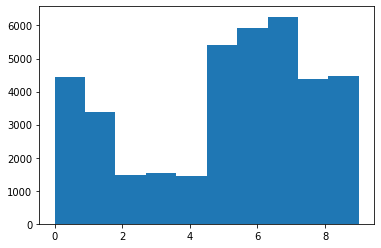

In [44]:
imbalanced_trainloader_all = torch.utils.data.DataLoader(imbalanced_trainset, 
                                                         batch_size=len(imbalanced_trainset),
                                                         shuffle=True, num_workers=1, pin_memory=True)
for _, labels in imbalanced_trainloader_all:
    plt.hist(labels.numpy(), align='mid')

In [45]:
imbalanced_trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=64,
                                          shuffle=True, num_workers=1, pin_memory=True)

Data samples


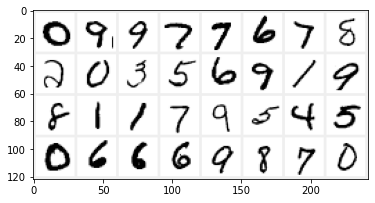

In [46]:
# create grid of images
dataiter = iter(imbalanced_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32].view(-1, 1, 28, 28).type(torch.float))

print('Data samples')
# show images
imshow(img_grid, one_channel=True)

## Define expert and gate networks

In [47]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=10) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=10, out_features=num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
                
        return t

In [48]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

        self.fc1 = nn.Linear(in_features=1*13*13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=num_experts)
        self.num_experts = num_experts

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [49]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes))
    return nn.ModuleList(models)

In [50]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class single_model(nn.Module):
    def __init__(self, num_classes=10):
        super(single_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)
        self.fc1 = nn.Linear(in_features=1*12*12, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=10) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=10, out_features=num_classes)
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        
        return t

In [51]:
from moe_models.moe_models_base import moe_models_base
from helper import moe_models
from torch.distributions.categorical import Categorical

class moe_no_gate_model(moe_models_base):

    def __init__(self, output_type='argmax', num_experts=5, num_classes=10, experts=None, gate=None, task='classification'):
        super( moe_no_gate_model,self).__init__(num_experts=num_experts, num_classes=num_classes, experts=experts, gate=gate, task=task)
        self.argmax = False
        self.stochastic = False
        self.expectation = False
        
        self.set_output_type(output_type)

            
    def set_output_type(self, output_type='argmax'):
        if output_type == 'argmax':
            self.argmax = True
        elif output_type == 'stochastic':
            self.stochastic = True
        elif output_type == 'expectation':
            self.expectation = True


    def forward(self, inputs, T=1.0):

        batch_size = inputs.shape[0]
        
        y = []
        h = []
        for i, expert in enumerate(self.experts):
            expert_output = expert(inputs)
            y.append(expert_output.view(1,-1,self.num_classes))
            expert_entropy = moe_models.entropy(expert_output, reduction='none')
            h.append(expert_entropy)

        y = torch.vstack(y).transpose_(0,1).to(device)
        self.expert_outputs = y
        
        h = torch.vstack(h).transpose_(0,1).to(device)
        self.per_sample_entropy = h
        
        # print('h', h[0:10])
        p = F.softmin(h/T, dim=1).detach()
        # print('gate', p[0:10])

        self.gate_outputs = p

        if self.expectation:
            # reshape gate output so probabilities correspond 
            # to each expert
            p = p.reshape(p.shape[0],p.shape[1], 1)

            # repeat probabilities number of classes times so
            # dimensions correspond
            p = p.repeat(1,1,y.shape[2])
            
            # expected sum of expert outputs
            output = torch.sum(p*y, 1)
        else:
            try:
                if self.stochastic:
                    m  = Categorical(p)
                    self.samples = m.sample().reshape(len(p), 1).to(device)
                elif self.argmax:
                    self.samples = torch.argmax(p, dim=1).to(device)
            except:
                raise
            
            output = y[torch.arange(0,batch_size).reshape(batch_size,1).to(device), self.samples.reshape(batch_size,1).to(device), :].squeeze()

        return output

## Initialize configurations and helper functions

In [52]:
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

## Funtion to train MoR in: 
### (1) dual temp mode where experts and gates are trained with different temperatures
### (2) with regularization
### (3) dual temp and regularization
### (4) without regularization when w_importance = 0.
### (5) training the whole model end-to-end when T = 0.

### NOTE: when importance is set to 0 then it is the default training without regularization

In [53]:
from itertools import product

def train_model(model_1, model_info, trainloader, testloader, runs, temps=[[1.0]*20], no_gate_temps=[[1.0]*20],
                                         w_importance_range=[0.0], w_ortho_range=[0.0], 
                                         w_sample_sim_same_range=[0.0],w_sample_sim_diff_range=[0.0], w_exp_gamma_range=[0.0],
                                         num_classes=10, total_experts=5, num_epochs=20):

    for T, no_gate_T, w_importance, w_ortho, w_sample_sim_same, w_sample_sim_diff, w_exp_gamma in product(temps, no_gate_temps, w_importance_range, w_ortho_range, w_sample_sim_same_range, w_sample_sim_diff_range, w_exp_gamma_range):
        
        print('Temperature',['{:.1f}'.format(t) for t in T])
        print('w_importance','{:.1f}'.format(w_importance))
        print('w_ortho','{:.1f}'.format(w_ortho))
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))

            
        if w_exp_gamma < 1:
            print('w_exp_gamma',str(w_exp_gamma))
        else:
            print('w_exp_gamma','{:.1f}'.format(w_exp_gamma))

        n_run_models_1 = []
        for run in range(runs):

            print('Run:', run),
            models = {model_info['name']:{'model':model_info['model'],'loss':model_info['loss'], 'experts':{}}}

            for key, val in models.items():

                expert_models = experts(num_experts=total_experts, num_classes=num_classes).to(device)

                gate_model = gate_layers(num_experts=total_experts).to(device)

                moe_model = val['model'](num_experts=total_experts, num_classes=num_classes,
                                         experts=expert_models, gate=gate_model).to(device)
                
                if 'output_type' in model_info:
                    moe_model.set_output_type(model_info['output_type'])
    
                optimizer_experts = optim.Adam(expert_models.parameters(), lr=0.001, amsgrad=False)

                optimizer_gate = optim.Adam(gate_model.parameters(), lr=0.001, amsgrad=False)
                
                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)

                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       optimizer_experts = optimizer_experts, optimizer_gate=optimizer_gate, 
                                       T = T, no_gate_T=no_gate_T, w_importance=w_importance, w_ortho=w_ortho, 
                                       w_sample_sim_same = w_sample_sim_same, w_sample_sim_diff = w_sample_sim_diff, 
                                       w_exp_gamma=w_exp_gamma,
                                       accuracy=accuracy, epochs=num_epochs, model_name=key)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            n_run_models_1.append(models)

        # Save all the trained models
        plot_file = generate_plot_file(model_1, T[0], no_gate_T[0], w_importance, w_ortho, w_sample_sim_same, w_sample_sim_diff, w_exp_gamma, str(num_classes)+'_'+str(total_experts)+'_models.pt')

        torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))


In [54]:
def train_dual_temp_regularization_model(model_1, trainloader, testloader, runs, temps=[[1.0]*20], 
                                         w_importance_range=[0.0], w_ortho_range=[0.0], 
                                         w_sample_sim_same_range=[0.0],w_sample_sim_diff_range=[0.0], w_exp_gamma_range=[0.0],
                                         num_classes=10, total_experts=5, num_epochs=20):
    
    models = {'name':'moe_expectation_model','model':moe_expectation_model,'loss':cross_entropy_loss()}
    
    train_model(model_1, models, trainloader, testloader, runs, temps, 
                                         w_importance_range, w_ortho_range, 
                                         w_sample_sim_same_range,w_sample_sim_diff_range, w_exp_gamma_range,
                                         num_classes, total_experts, num_epochs)
    

In [55]:
from itertools import product

def train_dual_temp_regularization_stochastic_model(model_1, trainloader, testloader, runs, temps=[[1.0]*20], 
                                         w_importance_range=[0.0], w_ortho_range=[0.0], 
                                         w_sample_sim_same_range=[0.0],w_sample_sim_diff_range=[0.0], w_exp_gamma_range=[0.0],
                                         num_classes=10, total_experts=5, num_epochs=20):
    models = {'moe_stochastic_model':{'model':moe_stochastic_model,'loss':stochastic_loss(cross_entropy_loss),
                                               'experts':{}},}
    
    train_model(model_1, models, trainloader, testloader, runs, temps, 
                                         w_importance_range, w_ortho_range, 
                                         w_sample_sim_same_range,w_sample_sim_diff_range, w_exp_gamma_range,
                                         num_classes, total_experts, num_epochs)

In [56]:
def train_dual_temp_regularization_no_gate_model(model_1, trainloader, testloader, runs, temps=[[1.0]*20], no_gate_temps=[1.0]*20, output_type='argmax', 
                                         w_importance_range=[0.0], w_sample_sim_same_range=[0.0],w_sample_sim_diff_range=[0.0], w_exp_gamma_range=[0.0],
                                         num_classes=10, total_experts=5, num_epochs=20):
    
    models = {'name':'moe_no_gate_model', 'model':moe_no_gate_model,'output_type':output_type,'loss':stochastic_loss(cross_entropy_loss)}
    print('total_experts', total_experts)
    train_model(model_1, models, trainloader=trainloader, testloader=testloader, runs=runs, temps=temps, no_gate_temps=no_gate_temps,
                w_importance_range=w_importance_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                w_sample_sim_same_range=w_sample_sim_same_range, 
                num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)
    

In [57]:
def train_single_model(model_name, trainloader, testloader, num_classes, num_epochs, runs):
    
    loss_criterion = cross_entropy_loss()
    
    n_runs = {'models':[], 'history':[]}
    
    for i in range(runs):
        
        print('Run', i)
        
        model = single_model(num_classes).to(device)
        history = {'loss':[], 'accuracy':[], 'val_accuracy':[]}
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        for epoch in range(num_epochs):
            running_loss = 0.0
            train_running_accuracy = 0.0
            num_batches = 0

            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(inputs)

                optimizer.zero_grad()
                loss = loss_criterion(outputs, labels)

                loss.backward()

                optimizer.step()

                running_loss += loss.item()

                outputs = model(inputs)

                acc = accuracy(outputs, labels)
                train_running_accuracy += acc

                num_batches += 1

            for test_inputs, test_labels in testloader:
                test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)
                test_outputs = model(test_inputs)
                test_accuracy = accuracy(test_outputs, test_labels)
                
            running_loss = (running_loss/num_batches)
            train_running_accuracy = (train_running_accuracy/num_batches)
            
            history['loss'].append(running_loss)
            history['accuracy'].append(train_running_accuracy)
            history['val_accuracy'].append(test_accuracy.item())
            
            print('epoch %d' % epoch,
                  'training loss %.2f' % running_loss,
                   ', training accuracy %.2f' % train_running_accuracy,
                   ', test accuracy %.2f' % test_accuracy
                   )
        n_runs['models'].append(model)
        n_runs['history'].append(history)
            
    plot_file = generate_plot_file(model_name, specific=str(num_classes)+'_models.pt')
    torch.save(n_runs, open(os.path.join(model_path, plot_file),'wb'))

In [58]:
def train_from_model(m, model, num_epochs, num_classes, total_experts,no_grad=True):
    
    new_expert_models = experts(total_experts, num_classes).to(device)
    old_expert_models = model['moe_expectation_model']['experts'][total_experts]['model'].experts
    for i, expert in enumerate(new_expert_models):
        old_expert = old_expert_models[i]
        expert.load_state_dict(old_expert.state_dict())
        if no_grad:
            for param in expert.parameters():
                param.requires_grad = False


    T = [1.0]*num_epochs
    w_importance = 0.0

    runs = 10
    n_run_models_1 = []
    for run in range(runs):

        print('Run:', run)

        models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),
                                       'experts':{}},}

        for key, val in models.items():

            gate_model = gate_layers(total_experts).to(device)

            moe_model = val['model'](total_experts, num_classes,
                                     experts=new_expert_models, gate=gate_model).to(device)

            optimizer_experts = optim.Adam(new_expert_models.parameters(), lr=0.001, amsgrad=False)

            optimizer_gate = optim.Adam(gate_model.parameters(), lr=0.001, amsgrad=False)

            optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)


            hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                   optimizer_experts = optimizer_experts, optimizer_gate=optimizer_gate, 
                                   T = T, w_importance=w_importance, 
                                   accuracy=accuracy, epochs=num_epochs)
            val['experts'][total_experts] = {'model':moe_model, 'history':hist}

        n_run_models_1.append(models)

    plot_file = generate_plot_file('new_'+m, T[0], w_importance=w_importance, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
    print(plot_file)
    torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))


In [62]:
p = torch.tensor([1/5]*5)
p

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])

In [72]:
moe_models.entropy(p)

tensor(2.3219)

In [76]:
g = torch.tensor([1.8, 0.5,1.0,0.8])
g

tensor([1.8000, 0.5000, 1.0000, 0.8000])

In [80]:
s=F.softmin(g, dim=0)
print(s, moe_models.entropy(s))

tensor([0.1040, 0.3817, 0.2315, 0.2828]) tensor(1.8740)


In [81]:
s=F.softmin(g/0.5, dim=0)
print(s, moe_models.entropy(s))

tensor([0.0373, 0.5023, 0.1848, 0.2757]) tensor(1.6386)


In [89]:
s=F.softmin(g/200, dim=0)
print(s, moe_models.entropy(s))

tensor([0.2490, 0.2507, 0.2500, 0.2503]) tensor(2.0000)


tensor(2.3219)

In [64]:
moe_models.entropy(p/0.5)

tensor(2.6439)

## Experiment 1: MoE model training with dual temperature

### MNIST data

In [59]:
total_experts = 5

In [60]:
num_epochs = 20

In [85]:
temps = [[T]* num_epochs for T in np.arange(1.1,1.6,0.1)]
temps = [[T]* num_epochs for T in np.arange(2,11,2)]
# temps += [[T]* num_epochs for T in np.arange(25,51,5)]
temps = [[4]*num_epochs]
np.unique(temps)

array([4])

In [86]:
runs = 1

In [87]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_transform_dual_temp'
train_dual_temp_regularization_model(model_1, trainloader, testloader, runs, temps, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0', '4.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 2.00 , training accuracy 0.33 , test accuracy 0.53
epoch 1 training loss 1.00 , training accuracy 0.73 , test accuracy 0.75
epoch 2 training loss 0.56 , training accuracy 0.84 , test accuracy 0.81
epoch 3 training loss 0.45 , training accuracy 0.87 , test accuracy 0.84


KeyboardInterrupt: 

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_stochastic_dual_temp'
train_dual_temp_regularization_stochastic_model(model_1, trainloader, testloader, runs, temps, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

### MNIST imbalanced data

In [83]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_imbalanced_5_dual_temp'

In [84]:
total_experts = 5

In [85]:
num_epochs = 20

In [86]:
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps

array([1.1, 1.2, 1.3, 1.4, 1.5, 2. , 3. , 4. , 5. ])

In [ ]:
w_importance_range = [0.0]

In [ ]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_1, imbalanced_trainloader, testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

### Combined rotated and unrotated MNIST data

In [75]:
# Model with gate and expert parameters initialized to default values
model_1 = 'rot_mnist_dual_temp'

In [76]:
total_experts = 5

In [77]:
num_epochs = 20

In [78]:
temps = [[T]* num_epochs for T in np.arange(1.1,1.6,0.1)]
temps += [[T]* num_epochs for T in np.arange(2,21,2)]
temps

[[1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1,
  1.1],
 [1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002,
  1.2000000000000002],
 [1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,
  1.3000000000000003,


In [79]:
runs = 10

In [80]:
train_dual_temp_regularization_model(model_1, rot_unrot_trainloader, rot_unrot_testloader, runs, temps, 
                                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1']
w_importance 0.0
w_ortho 0.0
w_sample_sim 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.49 , training accuracy 0.52 , test accuracy 0.72
epoch 1 training loss 0.52 , training accuracy 0.85 , test accuracy 0.89
epoch 2 training loss 0.33 , training accuracy 0.91 , test accuracy 0.90
epoch 3 training loss 0.27 , training accuracy 0.93 , test accuracy 0.92
epoch 4 training loss 0.22 , training accuracy 0.94 , test accuracy 0.92
epoch 5 training loss 0.19 , training accuracy 0.95 , test accuracy 0.93
epoch 6 training loss 0.16 , training accuracy 0.96 , test accuracy 0.95
epoch 7 training loss 0.13 , training accuracy 0.96 , test accuracy 0.94
epoch 8 training loss 0.13 , training accuracy 0.97 , test accuracy 0.95
epoch 9 training loss 0.11 , training accuracy 0.97 , test accuracy 0.95
epoch 10 training loss 0.10 , training accuracy 

### Combined FMNIST MNIST data

In [57]:
# Model with gate and expert parameters initialized to default values
model_1 = 'fmnist_mnist_transform_dual_temp'

In [58]:
total_experts = 6

In [59]:
num_epochs = 20

In [60]:
temps = [[T]* num_epochs for T in np.arange(1.1,1.6,0.1)]
temps += [[T]* num_epochs for T in np.arange(2,11,2)]
# temps += [[T]* num_epochs for T in np.arange(25,51,5)]
np.unique(temps)

array([ 1.1,  1.2,  1.3,  1.4,  1.5,  2. ,  4. ,  6. ,  8. , 10. ])

In [61]:
runs = 10

In [62]:
train_dual_temp_regularization_model(model_1, fmnist_mnist_trainloader, fmnist_mnist_testloader, 
                                      runs, temps, num_classes=num_classes_fmnist_mnist, 
                                      total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 2.04 , training accuracy 0.29 , test accuracy 0.47
epoch 1 training loss 1.03 , training accuracy 0.66 , test accuracy 0.73
epoch 2 training loss 0.63 , training accuracy 0.81 , test accuracy 0.80
epoch 3 training loss 0.50 , training accuracy 0.84 , test accuracy 0.81
epoch 4 training loss 0.44 , training accuracy 0.86 , test accuracy 0.83
epoch 5 training loss 0.41 , training accuracy 0.86 , test accuracy 0.83
epoch 6 training loss 0.37 , training accuracy 0.88 , test accuracy 0.83
epoch 7 training loss 0.35 , training accuracy 0.89 , test accuracy 0.85
epoch 8 training loss 0.32 , training accuracy 0.89 , test accuracy 0.86
epoch 9 training loss 0.32 , training accuracy 0.90 , test accuracy 0.87
epoch 10 training los

### Combined FMNIST MNIST data with stochastic

In [113]:
# Model with gate and expert parameters initialized to default values
model_1 = 'fmnist_mnist_stochastic_dual_temp'

In [114]:
total_experts = 6

In [115]:
num_epochs = 20

In [117]:
temps = np.arange(1.1,1.6,0.1)
# temps += [[T]* num_epochs for T in np.arange(2,21,2)]
# temps += [[T]* num_epochs for T in np.arange(25,51,5)]
np.unique(temps)

array([1.1, 1.2, 1.3, 1.4, 1.5])

In [118]:
runs = 10

In [119]:
train_dual_temp_regularization_stochastic_model(model_1, fmnist_mnist_trainloader, fmnist_mnist_testloader, 
                                      runs, temps, num_classes=num_classes_fmnist_mnist, 
                                      total_experts=total_experts, num_epochs=num_epochs)

Temperature 1.1
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.07 , training accuracy 0.29 , test accuracy 0.48
epoch 1 training loss 0.57 , training accuracy 0.65 , test accuracy 0.72
epoch 2 training loss 0.37 , training accuracy 0.79 , test accuracy 0.80
epoch 3 training loss 0.29 , training accuracy 0.83 , test accuracy 0.81
epoch 4 training loss 0.25 , training accuracy 0.85 , test accuracy 0.84
epoch 5 training loss 0.22 , training accuracy 0.86 , test accuracy 0.84
epoch 6 training loss 0.21 , training accuracy 0.87 , test accuracy 0.85
epoch 7 training loss 0.19 , training accuracy 0.88 , test accuracy 0.85
epoch 8 training loss 0.18 , training accuracy 0.89 , test accuracy 0.84
epoch 9 training loss 0.17 , training accuracy 0.89 , test accuracy 0.86
epoch 10 training loss 0.17 , training accuracy 0.89 , test accuracy 0.86
epoch 11 training loss 0.16 , training accuracy 0.90 , test accuracy 0.86
epoch 12 t

### MNIST imbalanced data

## Experiment 2: MoE model training with gate regularization

### MNIST data

In [184]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_transform_with_reg'

In [185]:
total_experts = 5

In [186]:
num_epochs = 20

In [187]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [188]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
# w_importance_range = [1.0]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [189]:
runs = 10

In [190]:
train_dual_temp_regularization_model(model_2, trainloader, testloader, runs, temps, w_importance_range=w_importance_range, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.80 , training accuracy 0.45 , test accuracy 0.65
epoch 1 training loss 0.65 , training accuracy 0.85 , test accuracy 0.86
epoch 2 training loss 0.37 , training accuracy 0.91 , test accuracy 0.88
epoch 3 training loss 0.29 , training accuracy 0.93 , test accuracy 0.91
epoch 4 training loss 0.25 , training accuracy 0.94 , test accuracy 0.91
epoch 5 training loss 0.22 , training accuracy 0.95 , test accuracy 0.91
epoch 6 training loss 0.20 , training accuracy 0.96 , test accuracy 0.92
epoch 7 training loss 0.19 , training accuracy 0.96 , test accuracy 0.92
epoch 8 training loss 0.17 , training accuracy 0.96 , test accuracy 0.92
epoch 9 training loss 0.16 , training accuracy 0.97 , test accuracy 0.92
epoch 10 training los

### MNIST data with stochastic model

In [62]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_stochastic_with_reg'

In [63]:
total_experts = 5

In [64]:
num_epochs = 20

In [65]:
temps = [1.0]
temps

[1.0]

In [66]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
# w_importance_range = [1.0]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [67]:
runs = 10

In [68]:
train_dual_temp_regularization_stochastic_model(model_2, trainloader, testloader, runs, temps, w_importance_range=w_importance_range, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature 1.0
w_importance 0.2
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.09 , training accuracy 0.29 , test accuracy 0.48
epoch 1 training loss 0.60 , training accuracy 0.68 , test accuracy 0.76
epoch 2 training loss 0.36 , training accuracy 0.83 , test accuracy 0.81
epoch 3 training loss 0.28 , training accuracy 0.86 , test accuracy 0.83
epoch 4 training loss 0.25 , training accuracy 0.88 , test accuracy 0.85
epoch 5 training loss 0.22 , training accuracy 0.90 , test accuracy 0.87
epoch 6 training loss 0.20 , training accuracy 0.91 , test accuracy 0.87
epoch 7 training loss 0.19 , training accuracy 0.91 , test accuracy 0.89
epoch 8 training loss 0.17 , training accuracy 0.92 , test accuracy 0.89
epoch 9 training loss 0.16 , training accuracy 0.93 , test accuracy 0.90
epoch 10 training loss 0.16 , training accuracy 0.93 , test accuracy 0.89
epoch 11 training loss 0.14 , training accuracy 0.94 , test accuracy 0.90
epoch 12 t

### MNIST imbalanced data

In [136]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_imbalanced_multi_with_reg'

In [137]:
total_experts = 5

In [138]:
num_epochs = 20

In [139]:
num_classes = 10

In [140]:
temps = [[1.0]*num_epochs]

In [141]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range 

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [142]:
runs = 10

In [143]:
train_dual_temp_regularization_model(model_2, imbalanced_trainloader, testloader, runs, temps, 
                                     w_importance_range=w_importance_range, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
w_ortho 0.0
w_sample_sim 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.39 , training accuracy 0.54 , test accuracy 0.68
epoch 1 training loss 0.58 , training accuracy 0.84 , test accuracy 0.82
epoch 2 training loss 0.44 , training accuracy 0.89 , test accuracy 0.84
epoch 3 training loss 0.39 , training accuracy 0.90 , test accuracy 0.82
epoch 4 training loss 0.34 , training accuracy 0.92 , test accuracy 0.88
epoch 5 training loss 0.30 , training accuracy 0.93 , test accuracy 0.88
epoch 6 training loss 0.26 , training accuracy 0.94 , test accuracy 0.90
epoch 7 training loss 0.24 , training accuracy 0.94 , test accuracy 0.89
epoch 8 training loss 0.22 , training accuracy 0.95 , test accuracy 0.90
epoch 9 training loss 0.21 , training accuracy 0.95 , test accuracy 0.91
epoch 10 training loss 0.20 , training accuracy 

### Combined rotated and unrotated MNIST data

In [53]:
# Model with gate and expert parameters initialized to default values
model_2 = 'rot_mnist_with_reg'

In [54]:
total_experts = 5

In [55]:
num_epochs = 20

In [59]:
num_classes = 10

In [56]:
temps = [[1.0]*num_epochs]

In [57]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [58]:
runs = 10

In [60]:
train_dual_temp_regularization_model(model_2, rot_unrot_trainloader, rot_unrot_testloader, runs,temps,
                                     w_importance_range=w_importance_range, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
w_ortho 0.0
w_sample_sim 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.73 , training accuracy 0.51 , test accuracy 0.75
epoch 1 training loss 0.52 , training accuracy 0.87 , test accuracy 0.89
epoch 2 training loss 0.35 , training accuracy 0.92 , test accuracy 0.93
epoch 3 training loss 0.29 , training accuracy 0.93 , test accuracy 0.91
epoch 4 training loss 0.24 , training accuracy 0.94 , test accuracy 0.94
epoch 5 training loss 0.22 , training accuracy 0.95 , test accuracy 0.94
epoch 6 training loss 0.20 , training accuracy 0.96 , test accuracy 0.92
epoch 7 training loss 0.19 , training accuracy 0.96 , test accuracy 0.94
epoch 8 training loss 0.17 , training accuracy 0.96 , test accuracy 0.94
epoch 9 training loss 0.16 , training accuracy 0.96 , test accuracy 0.94
epoch 10 training loss 0.16 , training accuracy 

### Combined FMNIST MNIST data

In [69]:
# Model with gate and expert parameters initialized to default values
model_2 = 'fmnist_mnist_with_reg'

In [70]:
total_experts = 6

In [71]:
num_epochs = 20

In [72]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
# w_importance_range = [1.0]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [73]:
runs = 10

In [74]:
train_dual_temp_regularization_model(model_2, fmnist_mnist_trainloader, fmnist_mnist_testloader, runs, 
                          w_importance_range=w_importance_range, num_classes=num_classes_fmnist_mnist,
                          total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 2.15 , training accuracy 0.33 , test accuracy 0.45
epoch 1 training loss 0.96 , training accuracy 0.72 , test accuracy 0.78
epoch 2 training loss 0.53 , training accuracy 0.86 , test accuracy 0.83
epoch 3 training loss 0.43 , training accuracy 0.88 , test accuracy 0.86
epoch 4 training loss 0.38 , training accuracy 0.89 , test accuracy 0.87
epoch 5 training loss 0.35 , training accuracy 0.90 , test accuracy 0.87
epoch 6 training loss 0.33 , training accuracy 0.90 , test accuracy 0.88
epoch 7 training loss 0.31 , training accuracy 0.91 , test accuracy 0.89
epoch 8 training loss 0.29 , training accuracy 0.92 , test accuracy 0.89
epoch 9 training loss 0.28 , training accuracy 0.92 , test accuracy 0.90
epoch 10 training los

### Combined FMNIST MNIST data with stochastic

In [98]:
# Model with gate and expert parameters initialized to default values
model_2 = 'fmnist_stochastic_mnist_with_reg'

In [104]:
temps = [1.0]

In [99]:
total_experts = 6

In [100]:
num_epochs = 20

In [101]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
# w_importance_range = [1.0]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [102]:
runs = 10

In [106]:
train_dual_temp_regularization_stochastic_model(model_2, fmnist_mnist_trainloader, fmnist_mnist_testloader, runs, temps=temps,
                          w_importance_range=w_importance_range, num_classes=num_classes_fmnist_mnist,
                          total_experts=total_experts, num_epochs=num_epochs)

Temperature 1.0
w_importance 0.2
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.16 , training accuracy 0.30 , test accuracy 0.43
epoch 1 training loss 0.69 , training accuracy 0.61 , test accuracy 0.69
epoch 2 training loss 0.41 , training accuracy 0.78 , test accuracy 0.80
epoch 3 training loss 0.32 , training accuracy 0.82 , test accuracy 0.81
epoch 4 training loss 0.28 , training accuracy 0.84 , test accuracy 0.83
epoch 5 training loss 0.26 , training accuracy 0.86 , test accuracy 0.84
epoch 6 training loss 0.24 , training accuracy 0.86 , test accuracy 0.83
epoch 7 training loss 0.22 , training accuracy 0.87 , test accuracy 0.85
epoch 8 training loss 0.21 , training accuracy 0.88 , test accuracy 0.85
epoch 9 training loss 0.21 , training accuracy 0.88 , test accuracy 0.86
epoch 10 training loss 0.20 , training accuracy 0.88 , test accuracy 0.85
epoch 11 training loss 0.19 , training accuracy 0.89 , test accuracy 0.87
epoch 12 t

## Experiment 3: MoE model training without gate regularization

### MNIST data

In [60]:
# Model with gate and expert parameters initialized to default values
model_3 = 'mnist_transform_without_reg'

In [61]:
total_experts = 5

In [62]:
num_epochs = 20

In [63]:
temps = [[1.0]*num_epochs]

In [64]:
runs = 1

In [67]:
train_dual_temp_regularization_model(model_3, trainloader, testloader, runs, temps, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

In [65]:
train_dual_temp_regularization_no_gate_model(model_3, trainloader, testloader, runs, temps, output_type='expectation', num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

total_experts 5
Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.12 , training accuracy 0.28 , test accuracy 0.47
epoch 1 training loss 0.79 , training accuracy 0.64 , test accuracy 0.75
epoch 2 training loss 0.48 , training accuracy 0.83 , test accuracy 0.82
epoch 3 training loss 0.37 , training accuracy 0.87 , test accuracy 0.84
epoch 4 training loss 0.32 , training accuracy 0.88 , test accuracy 0.86
epoch 5 training loss 0.29 , training accuracy 0.89 , test accuracy 0.86
epoch 6 training loss 0.28 , training accuracy 0.90 , test accuracy 0.86
epoch 7 training loss 0.27 , training accuracy 0.90 , test accuracy 0.87
epoch 8 training loss 0.26 , training accuracy 0.91 , test accuracy 0.87
epoch 9 training loss 0.25 , training accuracy 0.91 , test accuracy 0.87
epoch

moe_no_gate_model
torch.Size([20, 10000, 5]) torch.Size([20, 5])


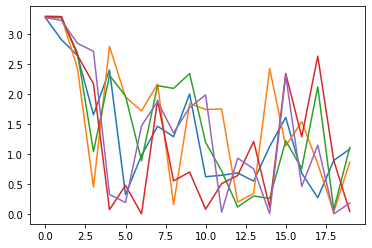

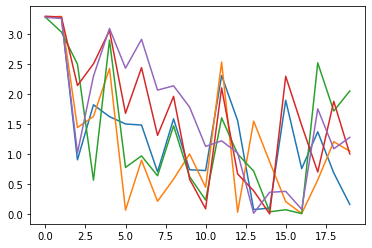

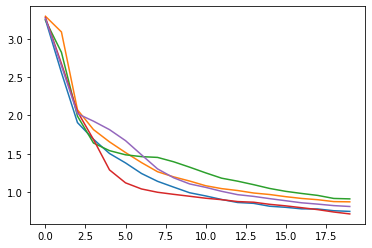

In [87]:
m = 'mnist_transform_without_reg'
plot_file = generate_plot_file(m, temp=1.0, no_gate_T=1.0, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

for model in models:
    for e_key, e_val in model.items():
        print(e_key)
        history = model[e_key]['experts'][total_experts]['history']
        per_sample_entropy = torch.vstack(history['per_sample_entropy']).reshape(num_epochs, -1, total_experts).cpu()
        mean_sample_entropy = torch.mean(per_sample_entropy, dim=1)
        print(per_sample_entropy.shape, mean_sample_entropy.shape)
        plt.plot(range(20), per_sample_entropy[:,0,0])
        plt.plot(range(20), per_sample_entropy[:,0,1])
        plt.plot(range(20), per_sample_entropy[:,0,2])
        plt.plot(range(20), per_sample_entropy[:,0,3])
        plt.plot(range(20), per_sample_entropy[:,0,4])
        plt.show()
        
        plt.plot(range(20), per_sample_entropy[:,1,0])
        plt.plot(range(20), per_sample_entropy[:,1,1])
        plt.plot(range(20), per_sample_entropy[:,1,2])
        plt.plot(range(20), per_sample_entropy[:,1,3])
        plt.plot(range(20), per_sample_entropy[:,1,4])
        plt.show()
        
        plt.plot(range(20), mean_sample_entropy[:,0])
        plt.plot(range(20), mean_sample_entropy[:,1])
        plt.plot(range(20), mean_sample_entropy[:,2])
        plt.plot(range(20), mean_sample_entropy[:,3])
        plt.plot(range(20), mean_sample_entropy[:,4])
        plt.show()

In [84]:
F.softmax(torch.tensor([0.2134, 0.6778, 0.0404, 0.0696, 1.4421]), dim=0)

tensor([0.1296, 0.2062, 0.1090, 0.1123, 0.4429])

In [85]:
F.softmin(torch.tensor([0.2134, 0.6778, 0.0404, 0.0696, 1.4421]), dim=0)
[0.2345, 0.1474, 0.2788, 0.2708, 0.0686]

[0.2345, 0.1474, 0.2788, 0.2708, 0.0686]

In [68]:
m = nn.Softmin(dim=1)
p = nn.Softmax(dim=1)
input = torch.randn(2, 3)
print(input)
output = m(input)
print(output)
output = p(input)
print(output)

tensor([[ 1.2349, -1.7473, -0.8474],
        [-0.1158, -0.1362,  0.6842]])
tensor([[0.0348, 0.6862, 0.2790],
        [0.4049, 0.4132, 0.1819]])
tensor([[0.8508, 0.0431, 0.1061],
        [0.2378, 0.2330, 0.5292]])


### MNIST data with stochastic model

In [69]:
# Model with gate and expert parameters initialized to default values
model_3 = 'mnist_stochastic_without_reg'

In [70]:
total_experts = 5

In [71]:
num_epochs = 20

In [72]:
temps = [1.0]

In [73]:
runs = 10

In [74]:
train_dual_temp_regularization_stochastic_model(model_3, trainloader, testloader, runs, temps, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature 1.0
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.08 , training accuracy 0.27 , test accuracy 0.38
epoch 1 training loss 0.72 , training accuracy 0.58 , test accuracy 0.66
epoch 2 training loss 0.43 , training accuracy 0.76 , test accuracy 0.67
epoch 3 training loss 0.34 , training accuracy 0.80 , test accuracy 0.75
epoch 4 training loss 0.29 , training accuracy 0.83 , test accuracy 0.78
epoch 5 training loss 0.26 , training accuracy 0.85 , test accuracy 0.81
epoch 6 training loss 0.24 , training accuracy 0.86 , test accuracy 0.82
epoch 7 training loss 0.22 , training accuracy 0.88 , test accuracy 0.83
epoch 8 training loss 0.21 , training accuracy 0.88 , test accuracy 0.84
epoch 9 training loss 0.20 , training accuracy 0.89 , test accuracy 0.85
epoch 10 training loss 0.18 , training accuracy 0.89 , test accuracy 0.85
epoch 11 training loss 0.18 , training accuracy 0.90 , test accuracy 0.84
epoch 12 t

### MNIST imbalanced data

In [154]:
# Model with gate and expert parameters initialized to default values
model_3 = 'mnist_imbalanced_multi_without_reg'

In [155]:
total_experts = 5

In [156]:
num_epochs = 20

In [157]:
temps = [[1.0]*num_epochs]

In [158]:
num_classes = 10

In [159]:
runs = 10

In [160]:
train_dual_temp_regularization_model(model_3, imbalanced_trainloader, testloader, runs, temps,
                                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.30 , training accuracy 0.55 , test accuracy 0.67
epoch 1 training loss 0.45 , training accuracy 0.86 , test accuracy 0.84
epoch 2 training loss 0.31 , training accuracy 0.91 , test accuracy 0.87
epoch 3 training loss 0.25 , training accuracy 0.93 , test accuracy 0.88
epoch 4 training loss 0.20 , training accuracy 0.94 , test accuracy 0.89
epoch 5 training loss 0.17 , training accuracy 0.95 , test accuracy 0.90
epoch 6 training loss 0.15 , training accuracy 0.95 , test accuracy 0.91
epoch 7 training loss 0.13 , training accuracy 0.96 , test accuracy 0.91
epoch 8 training loss 0.12 , training accuracy 0.96 , test accuracy 0.92
epoch 9 training loss 0.11 , training accuracy 0.97 , test accuracy 0.91
epoch 10 training loss 0.10 , training accuracy 

### Combined rotated and unrotated MNIST data

In [69]:
# Model with gate and expert parameters initialized to default values
model_3 = 'rot_mnist_without_reg'

In [70]:
total_experts = 5

In [71]:
num_epochs = 20

In [72]:
temps = [[1.0]*num_epochs]

In [73]:
runs = 10

In [74]:
train_dual_temp_regularization_model(model_3, rot_unrot_trainloader, rot_unrot_testloader, runs, temps,
                                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.72 , training accuracy 0.38 , test accuracy 0.58
epoch 1 training loss 0.81 , training accuracy 0.72 , test accuracy 0.76
epoch 2 training loss 0.51 , training accuracy 0.82 , test accuracy 0.82
epoch 3 training loss 0.38 , training accuracy 0.89 , test accuracy 0.91
epoch 4 training loss 0.26 , training accuracy 0.93 , test accuracy 0.91
epoch 5 training loss 0.22 , training accuracy 0.94 , test accuracy 0.93
epoch 6 training loss 0.21 , training accuracy 0.94 , test accuracy 0.92
epoch 7 training loss 0.18 , training accuracy 0.95 , test accuracy 0.93
epoch 8 training loss 0.17 , training accuracy 0.95 , test accuracy 0.94
epoch 9 training loss 0.16 , training accuracy 0.95 , test accuracy 0.94
epoch 10 training loss 0.15 , training accuracy 

### Combined FMNIST MNIST data

In [75]:
# Model with gate and expert parameters initialized to default values
model_3 = 'fmnist_mnist_without_reg'

In [76]:
total_experts = 6

In [77]:
num_epochs = 20

In [78]:
w_importance_range = [0]
w_importance_range

[0]

In [79]:
runs = 10

In [80]:
train_dual_temp_regularization_model(model_3, fmnist_mnist_trainloader, fmnist_mnist_testloader, runs, 
                              num_classes=num_classes_fmnist_mnist, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 2.07 , training accuracy 0.29 , test accuracy 0.39
epoch 1 training loss 1.30 , training accuracy 0.47 , test accuracy 0.58
epoch 2 training loss 1.07 , training accuracy 0.64 , test accuracy 0.65
epoch 3 training loss 0.85 , training accuracy 0.72 , test accuracy 0.72
epoch 4 training loss 0.68 , training accuracy 0.76 , test accuracy 0.74
epoch 5 training loss 0.58 , training accuracy 0.79 , test accuracy 0.78
epoch 6 training loss 0.52 , training accuracy 0.80 , test accuracy 0.79
epoch 7 training loss 0.48 , training accuracy 0.82 , test accuracy 0.80
epoch 8 training loss 0.45 , training accuracy 0.83 , test accuracy 0.81
epoch 9 training loss 0.43 , training accuracy 0.84 , test accuracy 0.83
epoch 10 training los

## Experiment 4: MoE model training with dual temp and gate regularization

### MNIST data

In [76]:
# Model with gate and expert parameters initialized to default values
model_4 = 'mnist_transform_dual_temp_with_reg'

In [77]:
total_experts = 5

In [78]:
num_epochs = 20

In [79]:
temps = [[T]* num_epochs for T in np.arange(1.1,1.6,0.1)]
temps += [[T]* num_epochs for T in np.arange(2,11,2)]
np.unique(temps)

array([ 1.1,  1.2,  1.3,  1.4,  1.5,  2. ,  4. ,  6. ,  8. , 10. ])

In [80]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [81]:
runs = 10

In [82]:
train_dual_temp_regularization_model(model_4, trainloader, testloader, runs, temps, 
                                     w_importance_range=w_importance_range, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1']
w_importance 0.2
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.86 , training accuracy 0.39 , test accuracy 0.57
epoch 1 training loss 0.68 , training accuracy 0.80 , test accuracy 0.86
epoch 2 training loss 0.39 , training accuracy 0.90 , test accuracy 0.89
epoch 3 training loss 0.30 , training accuracy 0.92 , test accuracy 0.89
epoch 4 training loss 0.25 , training accuracy 0.93 , test accuracy 0.91
epoch 5 training loss 0.21 , training accuracy 0.94 , test accuracy 0.91
epoch 6 training loss 0.19 , training accuracy 0.95 , test accuracy 0.91
epoch 7 training loss 0.18 , training accuracy 0.95 , test accuracy 0.92
epoch 8 training loss 0.15 , training accuracy 0.96 , test accuracy 0.92
epoch 9 training loss 0.14 , training accuracy 0.97 , test accuracy 0.93
epoch 10 training los

### MNIST imbalanced data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_imbalanced_5_dual_temp_with_regularization'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
w_importance_range = [i * 0.2 for i in range(1, 6)]
temps = [1.3]
w_importance_range = [0.8, 1.0]
print(temps)
print(w_importance_range)

In [ ]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_1, imbalanced_trainloader, testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

## Experiment 5: MoE model training with dual temperature schedule

### MNIST data

In [168]:
# Model with gate and expert parameters initialized to default values
model_5 = 'mnist_dual_temp_on_schedule'

In [169]:
total_experts = 5

In [170]:
num_epochs = 20

In [171]:
temps =np.asarray([[1.2]*6+[1.1]*6+[1.0]*8])
temps =np.asarray([[20.0]*10+[10.0]*10+[1.0]*10])
temps = [list(np.arange(10,0,-2))+ [1.0]*15, 
         list(np.arange(20,10,-2))+ [1.0]*15]
          
#          list(np.arange(30,10,-2))+ [1.0]*15]
for i in range(len(temps)):
    print(temps[i], len(temps[i]))

[10, 8, 6, 4, 2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 20
[20, 18, 16, 14, 12, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 20


In [172]:
w_importance_range = [0.4,1.0]
w_importance_range

[0.4, 1.0]

In [173]:
runs = 10

In [174]:
train_dual_temp_regularization_model(model_5, trainloader, testloader, runs, temps, w_importance_range=w_importance_range,
                                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['10.0', '8.0', '6.0', '4.0', '2.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.4
w_ortho 0.0
w_sample_sim 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 2.02 , training accuracy 0.31 , test accuracy 0.50
epoch 1 training loss 0.92 , training accuracy 0.72 , test accuracy 0.79
epoch 2 training loss 0.55 , training accuracy 0.85 , test accuracy 0.83
epoch 3 training loss 0.42 , training accuracy 0.89 , test accuracy 0.86
epoch 4 training loss 0.35 , training accuracy 0.91 , test accuracy 0.88
epoch 5 training loss 0.30 , training accuracy 0.93 , test accuracy 0.89
epoch 6 training loss 0.26 , training accuracy 0.94 , test accuracy 0.90
epoch 7 training loss 0.24 , training accuracy 0.94 , test accuracy 0.90
epoch 8 training loss 0.22 , training accuracy 0.95 , test accuracy 0.90
epoch 9 training loss 0.20 , training accuracy 0.96 , test accuracy 0.90
epoch 10 training loss 0.19 , training accuracy

### MNIST imbalanced data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_imbalanced_5_dual_temp_on_schedule'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps =np.asarray([[1.2]*6+[1.1]*6+[1.0]*8])
temps =np.asarray([[1.2]*6+[1.1]*6+[1.0]*8, [2.0]*5+[1.5]*5+[1.1]*5+[1.0]*5])
temps

In [ ]:
w_importance_range = [0.0]

In [ ]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_1, imbalanced_trainloader, testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

## Experiment 1: MoE model training with no gate model

### MNIST data

In [74]:
total_experts = 5

In [75]:
num_epochs = 20

In [76]:
runs = 1

In [65]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_no_gate_argmax_without_reg'
train_dual_temp_regularization_no_gate_model(model_1,  trainloader, testloader, runs, output_type='argmax',
                                                num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

total_experts 5
Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 0.54 , training accuracy 0.73 , test accuracy 0.88
epoch 1 training loss 0.25 , training accuracy 0.89 , test accuracy 0.91
epoch 2 training loss 0.21 , training accuracy 0.91 , test accuracy 0.91
epoch 3 training loss 0.19 , training accuracy 0.92 , test accuracy 0.92
epoch 4 training loss 0.18 , training accuracy 0.92 , test accuracy 0.92
epoch 5 training loss 0.17 , training accuracy 0.92 , test accuracy 0.92
epoch 6 training loss 0.17 , training accuracy 0.92 , test accuracy 0.92
epoch 7 training loss 0.16 , training accuracy 0.92 , test accuracy 0.92
epoch 8 training loss 0.16 , training accuracy 0.93 , test accuracy 0.93
epoch 9 training loss 0.16 , training accuracy 0.93 , test accuracy 0.92
epoch

In [62]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_no_gate_argmax_with_reg'

w_sample_sim_same_range = [1e-5]
w_sample_sim_diff_range = [1e-6]

train_dual_temp_regularization_no_gate_model(model_1,  trainloader, testloader, runs, output_type='argmax', 
                                             w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                                                num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

total_experts 5
Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 1e-05
w_sample_sim_diff 1e-06
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 0.80 , training accuracy 0.70 , test accuracy 0.87
epoch 1 training loss 0.52 , training accuracy 0.88 , test accuracy 0.89
epoch 2 training loss 0.47 , training accuracy 0.90 , test accuracy 0.90
epoch 3 training loss 0.45 , training accuracy 0.90 , test accuracy 0.90
epoch 4 training loss 0.44 , training accuracy 0.91 , test accuracy 0.91
epoch 5 training loss 0.43 , training accuracy 0.91 , test accuracy 0.91
epoch 6 training loss 0.43 , training accuracy 0.91 , test accuracy 0.91
epoch 7 training loss 0.42 , training accuracy 0.91 , test accuracy 0.91
epoch 8 training loss 0.42 , training accuracy 0.92 , test accuracy 0.91
epoch 9 training loss 0.41 , training accuracy 0.92 , test accuracy 0.91
e

In [59]:
no_gate_temps = [[0.01,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]]
no_gate_temps

[[0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [67]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_no_gate_temp_argmax_without_reg'
train_dual_temp_regularization_no_gate_model(model_1,  trainloader, testloader, runs, output_type='argmax', no_gate_temps=no_gate_temps,
                                                num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

total_experts 5
Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 0.49 , training accuracy 0.70 , test accuracy 0.87
epoch 1 training loss 0.22 , training accuracy 0.88 , test accuracy 0.89
epoch 2 training loss 0.19 , training accuracy 0.89 , test accuracy 0.90
epoch 3 training loss 0.17 , training accuracy 0.90 , test accuracy 0.91
epoch 4 training loss 0.16 , training accuracy 0.91 , test accuracy 0.91
epoch 5 training loss 0.15 , training accuracy 0.92 , test accuracy 0.92
epoch 6 training loss 0.14 , training accuracy 0.92 , test accuracy 0.92
epoch 7 training loss 0.14 , training accuracy 0.92 , test accuracy 0.92
epoch 8 training loss 0.13 , training accuracy 0.93 , test accuracy 0.93
epoch 9 training loss 0.13 , training accuracy 0.93 , test accuracy 0.93
epoch

In [60]:
no_gate_temps_1 = [[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]]
no_gate_temps_1, len(no_gate_temps_1[0])

([[0.01,
   0.01,
   0.01,
   0.01,
   0.01,
   0.01,
   0.01,
   0.01,
   0.01,
   0.01,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1]],
 20)

In [77]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_no_gate_temp1_argmax_without_reg'
train_dual_temp_regularization_no_gate_model(model_1,  trainloader, testloader, runs, output_type='argmax', no_gate_temps=no_gate_temps_1,
                                                num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

total_experts 5
Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 0.49 , training accuracy 0.70 , test accuracy 0.88
epoch 1 training loss 0.21 , training accuracy 0.89 , test accuracy 0.90
epoch 2 training loss 0.18 , training accuracy 0.90 , test accuracy 0.91
epoch 3 training loss 0.17 , training accuracy 0.91 , test accuracy 0.92
epoch 4 training loss 0.16 , training accuracy 0.91 , test accuracy 0.92
epoch 5 training loss 0.15 , training accuracy 0.92 , test accuracy 0.92
epoch 6 training loss 0.14 , training accuracy 0.92 , test accuracy 0.92
epoch 7 training loss 0.14 , training accuracy 0.92 , test accuracy 0.92
epoch 8 training loss 0.14 , training accuracy 0.92 , test accuracy 0.92
epoch 9 training loss 0.13 , training accuracy 0.92 , test accuracy 0.92
epoch

In [61]:
no_gate_temps_2 = [[0.01,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]]
no_gate_temps_2, len(no_gate_temps_2[0])

([[0.01,
   0.01,
   0.01,
   0.01,
   0.01,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1]],
 20)

In [88]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_no_gate_temp2_argmax_without_reg'
train_dual_temp_regularization_no_gate_model(model_1,  trainloader, testloader, runs, output_type='argmax', no_gate_temps=no_gate_temps_2,
                                                num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

total_experts 5
Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 0.56 , training accuracy 0.63 , test accuracy 0.85
epoch 1 training loss 0.26 , training accuracy 0.85 , test accuracy 0.87
epoch 2 training loss 0.23 , training accuracy 0.87 , test accuracy 0.88
epoch 3 training loss 0.21 , training accuracy 0.88 , test accuracy 0.90
epoch 4 training loss 0.20 , training accuracy 0.89 , test accuracy 0.90
epoch 5 training loss 0.19 , training accuracy 0.90 , test accuracy 0.90
epoch 6 training loss 0.18 , training accuracy 0.90 , test accuracy 0.90
epoch 7 training loss 0.18 , training accuracy 0.90 , test accuracy 0.90
epoch 8 training loss 0.17 , training accuracy 0.90 , test accuracy 0.91
epoch 9 training loss 0.17 , training accuracy 0.91 , test accuracy 0.91
epoch

In [102]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_no_gate_temp2_argmax_with_reg'
w_importance_range = [0.2,0.4,0.6,1.0]
train_dual_temp_regularization_no_gate_model(model_1,  trainloader, testloader, runs, output_type='argmax', no_gate_temps=no_gate_temps_2,
                                             w_importance_range=w_importance_range,
                                             num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

total_experts 5
Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 0.94 , training accuracy 0.67 , test accuracy 0.84
epoch 1 training loss 0.70 , training accuracy 0.87 , test accuracy 0.89
epoch 2 training loss 0.67 , training accuracy 0.89 , test accuracy 0.89
epoch 3 training loss 0.66 , training accuracy 0.90 , test accuracy 0.90
epoch 4 training loss 0.65 , training accuracy 0.90 , test accuracy 0.90
epoch 5 training loss 0.63 , training accuracy 0.91 , test accuracy 0.91
epoch 6 training loss 0.63 , training accuracy 0.91 , test accuracy 0.91
epoch 7 training loss 0.61 , training accuracy 0.91 , test accuracy 0.92
epoch 8 training loss 0.60 , training accuracy 0.91 , test accuracy 0.91
epoch 9 training loss 0.59 , training accuracy 0.92 , test accuracy 0.92
epoch

In [62]:
no_gate_temps_3 = [[0.1]*num_epochs]
no_gate_temps_3, len(no_gate_temps_3[0])

([[0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1]],
 20)

In [92]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_no_gate_temp3_argmax_without_reg'
train_dual_temp_regularization_no_gate_model(model_1,  trainloader, testloader, runs, output_type='argmax', no_gate_temps=no_gate_temps_3,
                                                num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

total_experts 5
Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 0.45 , training accuracy 0.70 , test accuracy 0.89
epoch 1 training loss 0.18 , training accuracy 0.90 , test accuracy 0.91
epoch 2 training loss 0.15 , training accuracy 0.91 , test accuracy 0.92
epoch 3 training loss 0.14 , training accuracy 0.92 , test accuracy 0.92
epoch 4 training loss 0.13 , training accuracy 0.93 , test accuracy 0.93
epoch 5 training loss 0.13 , training accuracy 0.93 , test accuracy 0.93
epoch 6 training loss 0.12 , training accuracy 0.93 , test accuracy 0.93
epoch 7 training loss 0.12 , training accuracy 0.93 , test accuracy 0.93
epoch 8 training loss 0.12 , training accuracy 0.93 , test accuracy 0.93
epoch 9 training loss 0.11 , training accuracy 0.94 , test accuracy 0.94
epoch

In [ ]:
# Model with gate and expert parameters initialized to default values
# no_gate_temps = np.concatenate((np.asarray([1e-4,1e-3,1e-2]), np.arange(0.2,1.0,0.2), np.arange(1.0,1.55,0.1)))
# no_gate_temps
model_1 = 'mnist_no_gate_stochastic_without_reg'
train_dual_temp_regularization_no_gate_model(model_1,trainloader, testloader, runs, output_type='stochastic', 
                                                num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

In [63]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_no_gate_expectation_without_reg'
train_dual_temp_regularization_no_gate_model(model_1,  trainloader, testloader, runs, output_type='expectation',                                  
                                             num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

total_experts 5
Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 0.53 , training accuracy 0.77 , test accuracy 0.90
epoch 1 training loss 0.24 , training accuracy 0.90 , test accuracy 0.91
epoch 2 training loss 0.20 , training accuracy 0.91 , test accuracy 0.92
epoch 3 training loss 0.19 , training accuracy 0.92 , test accuracy 0.92
epoch 4 training loss 0.18 , training accuracy 0.92 , test accuracy 0.92
epoch 5 training loss 0.17 , training accuracy 0.93 , test accuracy 0.93
epoch 6 training loss 0.17 , training accuracy 0.93 , test accuracy 0.93
epoch 7 training loss 0.16 , training accuracy 0.93 , test accuracy 0.93
epoch 8 training loss 0.16 , training accuracy 0.93 , test accuracy 0.93
epoch 9 training loss 0.16 , training accuracy 0.93 , test accuracy 0.93
epoch

In [95]:
no_gate_temps_3 = [[0.1]*num_epochs]
no_gate_temps_3, len(no_gate_temps_3[0])

([[0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1]],
 20)

In [96]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_no_gate_temp3_expectation_without_reg'
train_dual_temp_regularization_no_gate_model(model_1,  trainloader, testloader, runs, output_type='expectation', no_gate_temps=no_gate_temps_3,
                                                num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

total_experts 5
Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 0.50 , training accuracy 0.71 , test accuracy 0.87
epoch 1 training loss 0.21 , training accuracy 0.89 , test accuracy 0.89
epoch 2 training loss 0.18 , training accuracy 0.90 , test accuracy 0.90
epoch 3 training loss 0.17 , training accuracy 0.91 , test accuracy 0.91
epoch 4 training loss 0.16 , training accuracy 0.91 , test accuracy 0.91
epoch 5 training loss 0.16 , training accuracy 0.91 , test accuracy 0.92
epoch 6 training loss 0.15 , training accuracy 0.92 , test accuracy 0.92
epoch 7 training loss 0.15 , training accuracy 0.92 , test accuracy 0.92
epoch 8 training loss 0.15 , training accuracy 0.92 , test accuracy 0.92
epoch 9 training loss 0.14 , training accuracy 0.92 , test accuracy 0.92
epoch

In [64]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_no_gate_expectation_with_reg'
w_sample_sim_same_range = [1e-5]
w_sample_sim_diff_range = [1e-6]
train_dual_temp_regularization_no_gate_model(model_1,  trainloader, testloader, runs, output_type='expectation',
                                             w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                                             num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

total_experts 5
Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 1e-05
w_sample_sim_diff 1e-06
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 0.74 , training accuracy 0.76 , test accuracy 0.90
epoch 1 training loss 0.47 , training accuracy 0.91 , test accuracy 0.91
epoch 2 training loss 0.43 , training accuracy 0.92 , test accuracy 0.92
epoch 3 training loss 0.42 , training accuracy 0.92 , test accuracy 0.93
epoch 4 training loss 0.41 , training accuracy 0.92 , test accuracy 0.92
epoch 5 training loss 0.40 , training accuracy 0.93 , test accuracy 0.93
epoch 6 training loss 0.39 , training accuracy 0.93 , test accuracy 0.92
epoch 7 training loss 0.39 , training accuracy 0.93 , test accuracy 0.93
epoch 8 training loss 0.38 , training accuracy 0.93 , test accuracy 0.93
epoch 9 training loss 0.38 , training accuracy 0.93 , test accuracy 0.93
e

## Experiment 9: MoE model training with sample similarity regularization 

### MNIST data

In [110]:
# Model with gate and expert parameters initialized to default values
model_9 = 'mnist_transform_with_reg'

In [111]:
total_experts = 5

In [112]:
num_epochs = 20

In [113]:
temps = [[1.0]*num_epochs]

In [114]:
w_sample_sim_same_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_same_range = [1e-6]
w_sample_sim_diff_range = [1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_same_range = [1e-5]
w_sample_sim_diff_range = [1e-4]
w_sample_sim_same_range, w_sample_sim_diff_range

([1e-05], [0.0001])

In [115]:
runs = 1

In [116]:
train_dual_temp_regularization_model(model_9, trainloader, testloader, runs, temps, 
                                     w_sample_sim_same_range=w_sample_sim_same_range,
                                     w_sample_sim_diff_range=w_sample_sim_diff_range,
                                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 1e-05
w_sample_sim_diff 0.0001
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 2.26 , training accuracy 0.32 , test accuracy 0.50
epoch 1 training loss 1.17 , training accuracy 0.75 , test accuracy 0.80
epoch 2 training loss 0.66 , training accuracy 0.88 , test accuracy 0.86
epoch 3 training loss 0.55 , training accuracy 0.91 , test accuracy 0.88
epoch 4 training loss 0.50 , training accuracy 0.92 , test accuracy 0.90
epoch 5 training loss 0.44 , training accuracy 0.94 , test accuracy 0.91
epoch 6 training loss 0.41 , training accuracy 0.95 , test accuracy 0.92
epoch 7 training loss 0.39 , training accuracy 0.95 , test accuracy 0.92
epoch 8 training loss 0.37 , training accuracy 0.96 , test accuracy 0.92
epoch 9 training loss 0.35 , training accuracy 0.96 , test accuracy 0.92
epoch 10 trainin

### MNIST imbalanced data

In [144]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_imbalanced_multi_with_reg'

In [145]:
total_experts = 5

In [146]:
num_epochs = 20

In [147]:
num_classes = 10

In [148]:
temps = [[1.0]*num_epochs]

In [149]:
w_sample_sim_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_range 

[1e-05, 0.0001, 0.001, 0.01, 0.1]

In [150]:
runs = 10

In [151]:
train_dual_temp_regularization_model(model_2, imbalanced_trainloader, testloader, runs, temps, 
                                     w_sample_sim_range=w_sample_sim_range, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim 1e-05
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.19 , training accuracy 0.60 , test accuracy 0.74
epoch 1 training loss 0.37 , training accuracy 0.89 , test accuracy 0.87
epoch 2 training loss 0.23 , training accuracy 0.93 , test accuracy 0.89
epoch 3 training loss 0.19 , training accuracy 0.94 , test accuracy 0.91
epoch 4 training loss 0.15 , training accuracy 0.95 , test accuracy 0.90
epoch 5 training loss 0.12 , training accuracy 0.96 , test accuracy 0.91
epoch 6 training loss 0.11 , training accuracy 0.96 , test accuracy 0.90
epoch 7 training loss 0.09 , training accuracy 0.97 , test accuracy 0.92
epoch 8 training loss 0.08 , training accuracy 0.97 , test accuracy 0.92
epoch 9 training loss 0.07 , training accuracy 0.98 , test accuracy 0.92
epoch 10 training loss 0.06 , training accurac

### Combined rotated and unrotated MNIST data

In [61]:
# Model with gate and expert parameters initialized to default values
model_2 = 'rot_mnist_with_reg'

In [62]:
total_experts = 5

In [63]:
num_epochs = 20

In [64]:
num_classes = 10

In [65]:
temps = [[1.0]*num_epochs]

In [66]:
w_sample_sim_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_range 

[1e-05, 0.0001, 0.001, 0.01, 0.1]

In [67]:
runs = 10

In [68]:
train_dual_temp_regularization_model(model_2, rot_unrot_trainloader, rot_unrot_testloader, runs,temps,
                                     w_sample_sim_range=w_sample_sim_range, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim 1e-05
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.59 , training accuracy 0.43 , test accuracy 0.72
epoch 1 training loss 0.52 , training accuracy 0.87 , test accuracy 0.88
epoch 2 training loss 0.30 , training accuracy 0.91 , test accuracy 0.90
epoch 3 training loss 0.24 , training accuracy 0.93 , test accuracy 0.92
epoch 4 training loss 0.20 , training accuracy 0.94 , test accuracy 0.93
epoch 5 training loss 0.17 , training accuracy 0.95 , test accuracy 0.93
epoch 6 training loss 0.14 , training accuracy 0.96 , test accuracy 0.94
epoch 7 training loss 0.12 , training accuracy 0.96 , test accuracy 0.94
epoch 8 training loss 0.11 , training accuracy 0.96 , test accuracy 0.94
epoch 9 training loss 0.09 , training accuracy 0.97 , test accuracy 0.94
epoch 10 training loss 0.09 , training accurac

### Combined FMNIST MNIST data

In [86]:
# Model with gate and expert parameters initialized to default values
model_1 = 'fmnist_mnist_with_reg'

In [87]:
total_experts = 6

In [88]:
num_epochs = 20

In [89]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [90]:
w_sample_sim_same_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_diff_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_same_range, w_sample_sim_diff_range

([1e-05, 0.0001, 0.001, 0.01, 0.1], [1e-05, 0.0001, 0.001, 0.01, 0.1])

In [91]:
runs = 10

In [92]:
train_dual_temp_regularization_model(model_1, fmnist_mnist_trainloader, fmnist_mnist_testloader, 
                                     runs, temps, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                                     num_classes=num_classes_fmnist_mnist, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 1e-05
w_sample_sim_diff 1e-05
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 2.27 , training accuracy 0.18 , test accuracy 0.28
epoch 1 training loss 1.20 , training accuracy 0.62 , test accuracy 0.72
epoch 2 training loss 0.67 , training accuracy 0.80 , test accuracy 0.79
epoch 3 training loss 0.50 , training accuracy 0.84 , test accuracy 0.82
epoch 4 training loss 0.43 , training accuracy 0.86 , test accuracy 0.84
epoch 5 training loss 0.39 , training accuracy 0.87 , test accuracy 0.85
epoch 6 training loss 0.36 , training accuracy 0.88 , test accuracy 0.84
epoch 7 training loss 0.34 , training accuracy 0.89 , test accuracy 0.85
epoch 8 training loss 0.31 , training accuracy 0.89 , test accuracy 0.86
epoch 9 training loss 0.30 , training accuracy 0.90 , test accuracy 0.86
epoch 10 training

## Experiment 10: MoE model training with sample similarity regularization  with gamma

### MNIST data

In [86]:
# Model with gate and expert parameters initialized to default values
model_10 = 'mnist_with_reg_test'

In [87]:
total_experts = 5

In [88]:
num_epochs = 20

In [89]:
temps = [[1.0]*num_epochs]

In [191]:
w_sample_sim_range = [i * 0.2 for i in range(1, 6)]
# w_sample_sim_range = [1.0]
w_sample_sim_range

[1.0]

In [192]:
w_exp_gamma_range = [1e-13, 1e-11, 1e-9 , 1e-7, 1e-5, 1e-3, 1e-1, 0.5, 1.0, 1000, 1000000]
w_exp_gamma_range = [1e-11, 1e-13]
w_exp_gamma_range 

[1e-11, 1e-13]

In [193]:
runs = 1

In [194]:
train_dual_temp_regularization_model(model_10, trainloader, testloader, runs, temps, 
                                     w_sample_sim_range=w_sample_sim_range, w_exp_gamma_range=w_exp_gamma_range,
                                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim 1.0
w_exp_gamma 1e-11
Run: 0
epoch 0 training loss -841.22 , training accuracy 0.68 , test accuracy 0.83
epoch 1 training loss -834.31 , training accuracy 0.88 , test accuracy 0.87
epoch 2 training loss -853.74 , training accuracy 0.91 , test accuracy 0.87
epoch 3 training loss -854.68 , training accuracy 0.92 , test accuracy 0.89
epoch 4 training loss -889.77 , training accuracy 0.93 , test accuracy 0.90
epoch 5 training loss -846.31 , training accuracy 0.93 , test accuracy 0.90
epoch 6 training loss -828.00 , training accuracy 0.93 , test accuracy 0.91
epoch 7 training loss -836.51 , training accuracy 0.94 , test accuracy 0.91
epoch 8 training loss -846.54 , training accuracy 0.94 , test accuracy 0.91
epoch 9 training loss -856.06 , training accuracy 0.95 , test accuracy 0.92
epoch 10 trainin

## Experiment 11: MoE model training with sample similarity and importance regularization 

### MNIST data

In [113]:
# Model with gate and expert parameters initialized to default values
model_11 = 'mnist_with_reg_test'

In [114]:
total_experts = 5

In [115]:
num_epochs = 20

In [116]:
temps = [[1.0]*num_epochs]

In [117]:
w_sample_sim_range = [i * 0.2 for i in range(1, 6)]
w_sample_sim_range = [1.0]
w_sample_sim_range

[1.0]

In [118]:
w_importance_range = [1.0]

In [119]:
runs = 1

In [120]:
train_dual_temp_regularization_model(model_11, trainloader, testloader, runs, temps, w_importance_range=w_importance_range, 
                                     w_sample_sim_range=w_sample_sim_range, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 1.0
w_ortho 0.0
w_sample_sim 1.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss -843.85 , training accuracy 0.39 , test accuracy 0.53
epoch 1 training loss -843.86 , training accuracy 0.73 , test accuracy 0.72
epoch 2 training loss -875.56 , training accuracy 0.78 , test accuracy 0.75
epoch 3 training loss -878.69 , training accuracy 0.82 , test accuracy 0.77
epoch 4 training loss -896.14 , training accuracy 0.83 , test accuracy 0.80
epoch 5 training loss -895.03 , training accuracy 0.84 , test accuracy 0.74
epoch 6 training loss -902.75 , training accuracy 0.85 , test accuracy 0.81
epoch 7 training loss -915.99 , training accuracy 0.86 , test accuracy 0.80
epoch 8 training loss -928.80 , training accuracy 0.87 , test accuracy 0.82
epoch 9 training loss -921.17 , training accuracy 0.87 , test accuracy 0.82
epoch 10 training 

### Combined FMNIST MNIST data

In [130]:
# Model with gate and expert parameters initialized to default values
model_1 = 'fmnist_mnist_with_reg'

In [131]:
total_experts = 6

In [132]:
num_epochs = 20

In [133]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [134]:
w_sample_sim_range = [i * 0.2 for i in range(1, 6)]
w_sample_sim_range = [1.0]
w_sample_sim_range

[1.0]

In [135]:
w_importance_range = [1.0]

In [136]:
runs = 1

In [137]:
train_dual_temp_regularization_model(model_1, fmnist_mnist_trainloader, fmnist_mnist_testloader, 
                                     runs, temps, w_importance_range=w_importance_range,
                                     w_sample_sim_range=w_sample_sim_range, num_classes=num_classes_fmnist_mnist, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 1.0
w_ortho 0.0
w_sample_sim 1.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss -753.65 , training accuracy 0.29 , test accuracy 0.52
epoch 1 training loss -760.10 , training accuracy 0.69 , test accuracy 0.70
epoch 2 training loss -760.25 , training accuracy 0.77 , test accuracy 0.76
epoch 3 training loss -750.74 , training accuracy 0.82 , test accuracy 0.80
epoch 4 training loss -756.48 , training accuracy 0.84 , test accuracy 0.81
epoch 5 training loss -774.27 , training accuracy 0.85 , test accuracy 0.80
epoch 6 training loss -762.73 , training accuracy 0.84 , test accuracy 0.82
epoch 7 training loss -760.94 , training accuracy 0.85 , test accuracy 0.82
epoch 8 training loss -753.57 , training accuracy 0.85 , test accuracy 0.82
epoch 9 training loss -757.91 , training accuracy 0.85 , test accuracy 0.81
epoch 10 training 

## Results

In [71]:
import csv
from helper import moe_models

def collect_results(m, temps=[1.0], w_importance_range=[0.0], w_ortho_range=[0.0], 
                    w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                    total_experts=5, num_classes=10, num_epochs=20, 
                    testloader=None, model_path=None, results_path=None, filename='mnist_results.csv'):
    
    filename = os.path.join(results_path, filename)
    
    if os.path.exists(filename):
        p = 'a'
    else:
        p = 'w'
        
    header = ['filename', 'train error', 'test error','mutual information', 'sample entropy', 'experts usage']
    
    with open(filename, p) as f:
                
        writer = csv.writer(f)        
        
        if p == 'w':            
            writer.writerow(header)
        
        for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
            plot_file = generate_plot_file(m, w_importance=w_importance, w_sample_sim_same=w_sample_sim_same, w_sample_sim_diff=w_sample_sim_diff, 
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
            for _ in range(len(models)):
                mod = models.pop()
                data = [plot_file]    
                for e_key, e_val in mod.items():
                    # model
                    model = mod[e_key]['experts'][total_experts]['model']
                    # history
                    history = mod[e_key]['experts'][total_experts]['history']
                    # train error
                    data.append(1-history['accuracy'][-1].item())

                    running_test_accuracy = 0.0
                    running_entropy = 0.0
                    num_batches = 0

                    # initialise the count matrix C for computing mutual information
                    ey =  torch.zeros((num_classes, total_experts)).to(device)
                    for test_inputs, test_labels in testloader:
                        test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
                        outputs = model(test_inputs)
                        running_test_accuracy += accuracy(outputs, test_labels)

                        selected_experts = torch.argmax(model.gate_outputs, dim=1)
                        y = test_labels
                        e = selected_experts
                        for j in range(y.shape[0]):
                            ey[int(torch.argmax(model.expert_outputs[j,e[j],:])), int(e[j])] += 1

                        running_entropy += moe_models.entropy(model.gate_outputs)

                        num_batches+=1

                    mutual_EY,_,_,_ = moe_models.mutual_information(ey.detach())

                    test_error = 1-(running_test_accuracy/num_batches)
                    data.append(test_error.item())
                    data.append(mutual_EY.item())

                    data.append(running_entropy.item()/num_batches)
                    gate_probabilities_sum = torch.mean(model.gate_outputs, dim=0)            
                    data.append(entropy(gate_probabilities_sum).item())

                    writer.writerow(data)
            
            

In [72]:
m = 'mnist_no_gate_expectation_without_reg'
collect_results(m, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [74]:
m = 'mnist_no_gate_expectation_with_reg'
w_sample_sim_same_range = [1e-5]
w_sample_sim_diff_range = [1e-6]
collect_results(m, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [75]:
m = 'mnist_no_gate_argmax_without_reg'
collect_results(m, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [76]:
m = 'mnist_no_gate_argmax_with_reg'
w_sample_sim_same_range = [1e-5]
w_sample_sim_diff_range = [1e-6]
collect_results(m, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

Min Training Error 0.065
Mutual Information 0.183
Sample Entropy 2.245
Expert Usage 2.318
mnist_no_gate_argmax_without_reg_10_5_models.pt


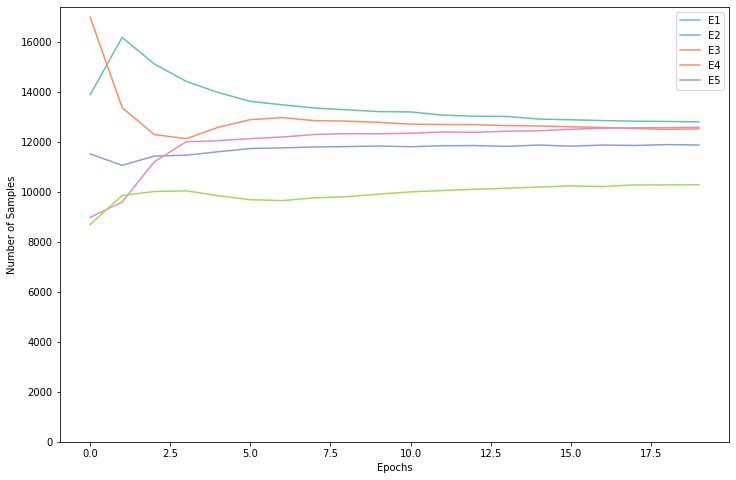

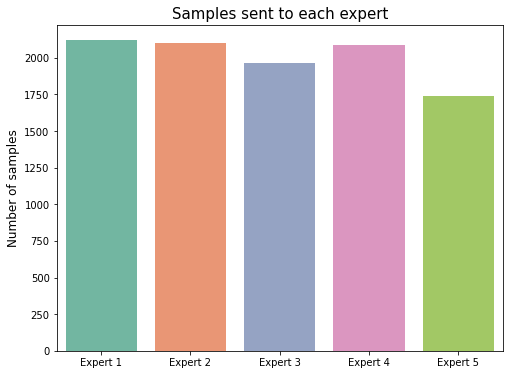

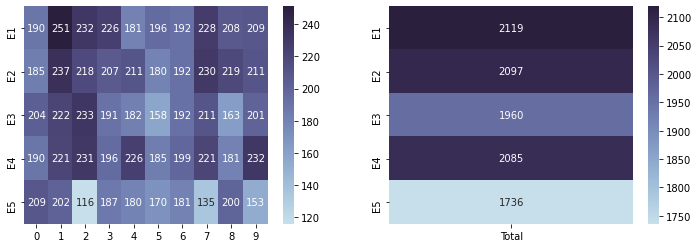


Experts used by the gate for classification of each digit


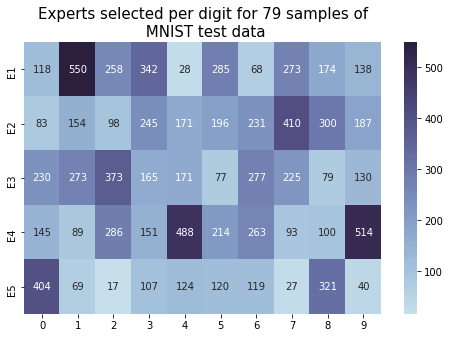

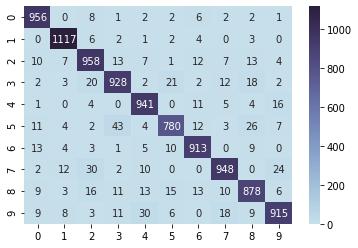

In [65]:
m = 'mnist_no_gate_argmax_without_reg'

total_experts = 5
num_classes = 10
classes = range(num_classes)
num_epochs = 20

test_loader = testloader

plot_expert_usage(m, test_loader, w_importance_range=[0], total_experts=total_experts,num_classes=num_classes,
                        classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

Temp decay [[0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
Min Training Error 0.081
Mutual Information 0.274
Sample Entropy 2.225
Expert Usage 2.321
mnist_no_gate_temp_argmax_without_reg_moe_temp_0.01_10_5_models.pt


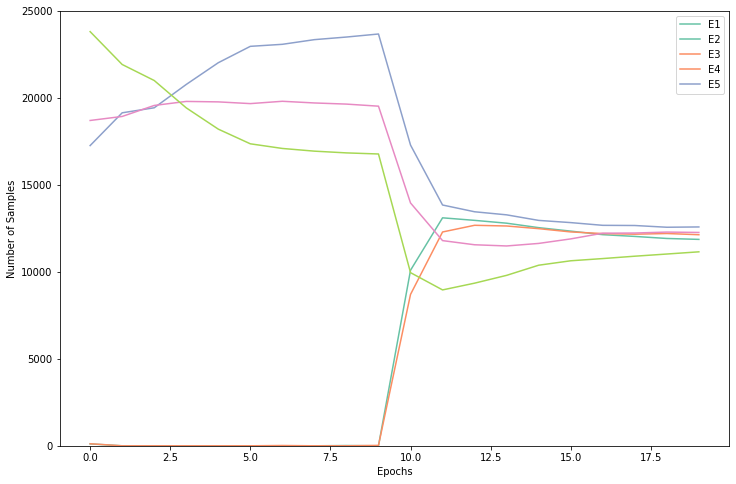

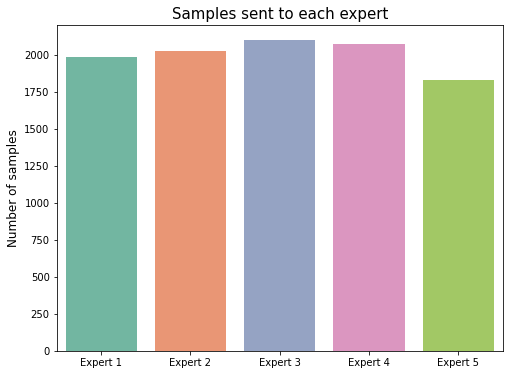

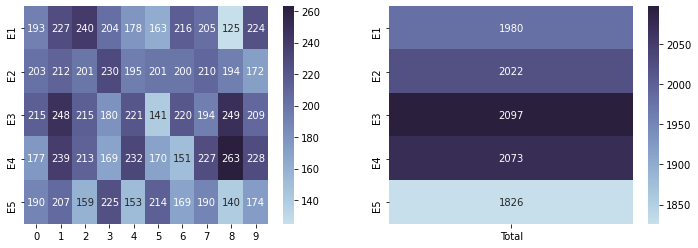


Experts used by the gate for classification of each digit


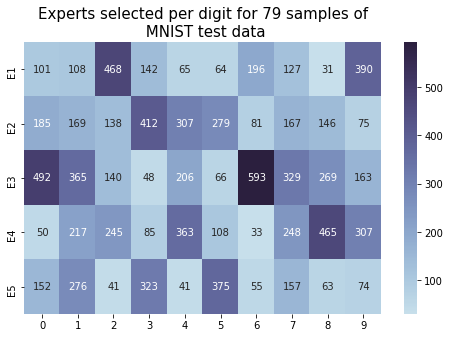

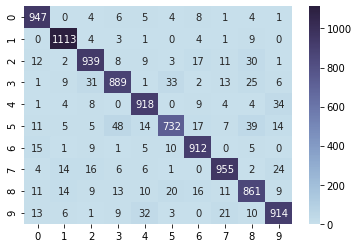

In [68]:
m = 'mnist_no_gate_temp_argmax_without_reg'

print('Temp decay', no_gate_temps)

total_experts = 5
num_classes = 10
classes = range(num_classes)
num_epochs = 20

test_loader = testloader

plot_expert_usage(m, test_loader, w_importance_range=[0], total_experts=total_experts,num_classes=num_classes,no_gate_temps=no_gate_temps,
                        classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

Temp decay [[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]
Min Training Error 0.062
Mutual Information 1.181
Sample Entropy 1.294
Expert Usage 1.681
mnist_no_gate_temp1_argmax_without_reg_moe_temp_0.01_10_5_models.pt


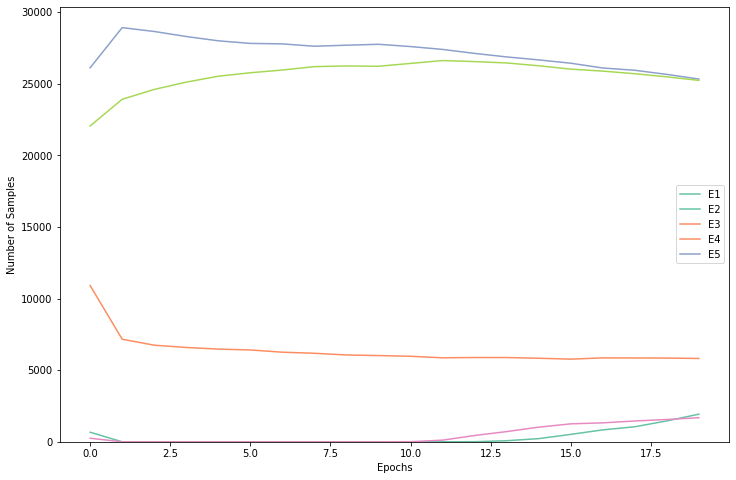

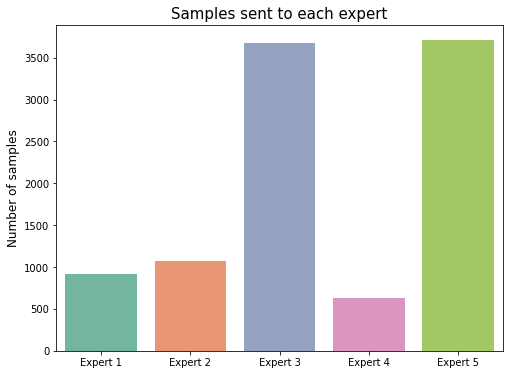

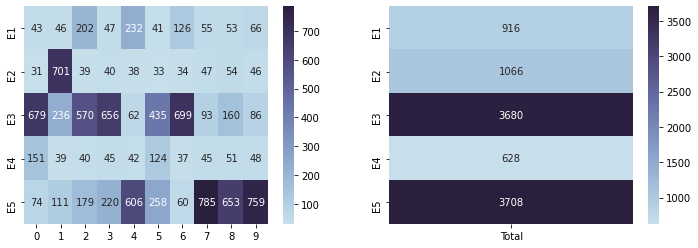


Experts used by the gate for classification of each digit


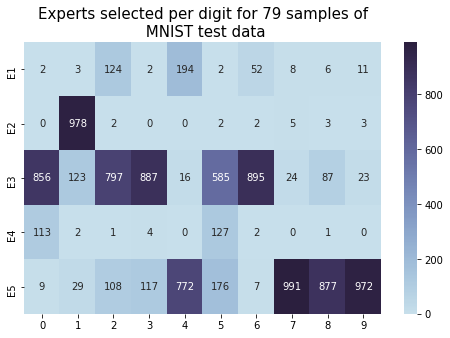

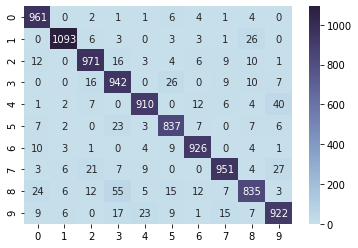

In [66]:
m = 'mnist_no_gate_temp1_argmax_without_reg'

print('Temp decay', no_gate_temps_1)
total_experts = 5
num_classes = 10
classes = range(num_classes)
num_epochs = 20

test_loader = testloader

plot_expert_usage(m, test_loader, w_importance_range=[0], total_experts=total_experts,num_classes=num_classes,no_gate_temps=no_gate_temps_1,
                        classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

Temp decay [[0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]
Min Training Error 0.076
Mutual Information 1.441
Sample Entropy 1.566
Expert Usage 1.976
mnist_no_gate_temp2_argmax_without_reg_moe_temp_0.01_10_5_models.pt


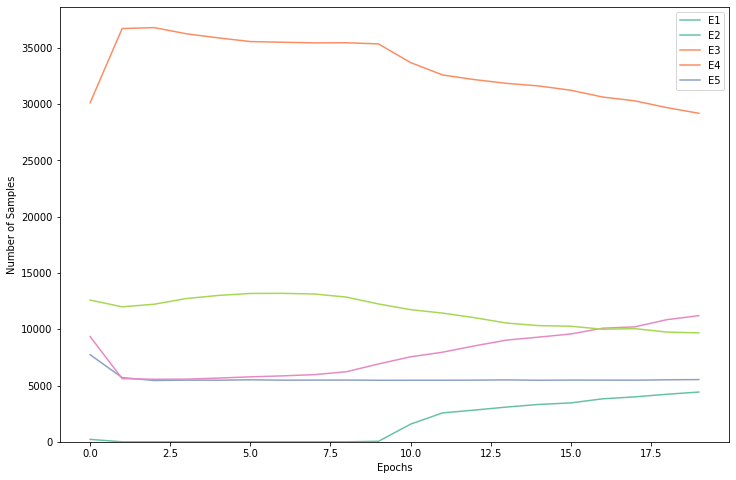

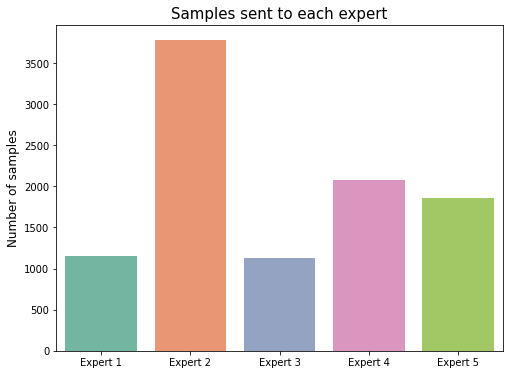

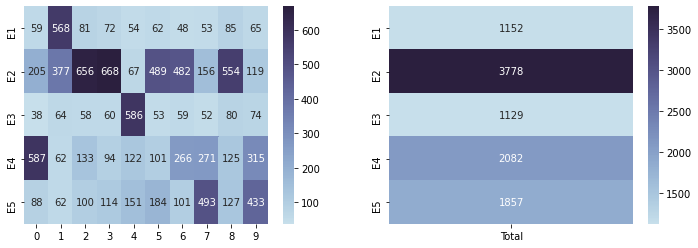


Experts used by the gate for classification of each digit


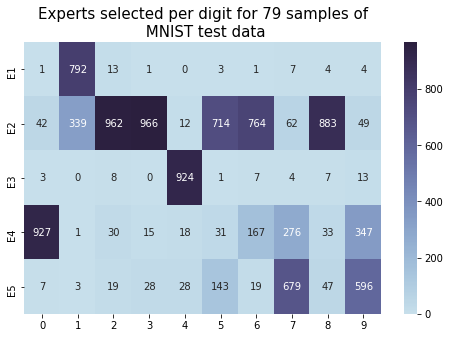

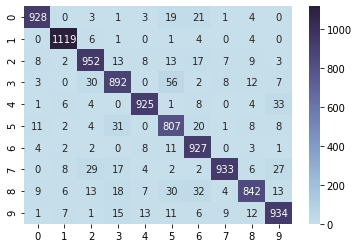

In [69]:
m = 'mnist_no_gate_temp2_argmax_without_reg'

print('Temp decay', no_gate_temps_2)

total_experts = 5
num_classes = 10
classes = range(num_classes)
num_epochs = 20

test_loader = testloader

plot_expert_usage(m, test_loader, w_importance_range=[0], total_experts=total_experts,num_classes=num_classes,no_gate_temps=no_gate_temps_2,
                        classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

Temp decay [[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]
Min Training Error 0.054
Mutual Information 1.452
Sample Entropy 1.426
Expert Usage 1.890
mnist_no_gate_temp3_argmax_without_reg_moe_temp_0.10_10_5_models.pt


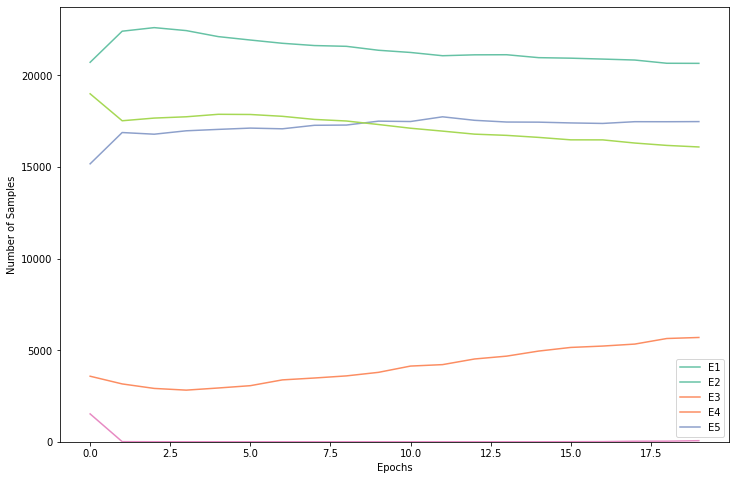

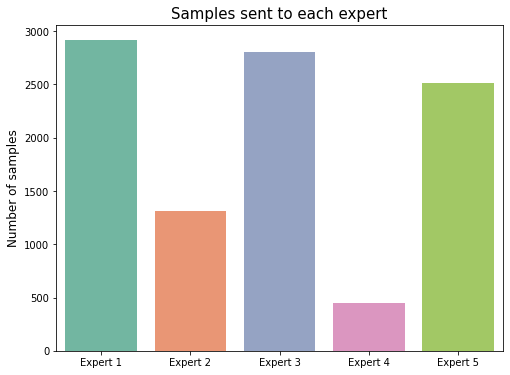

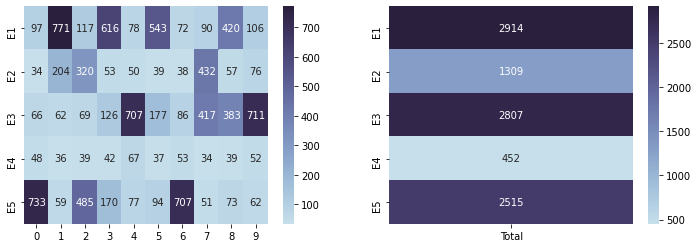


Experts used by the gate for classification of each digit


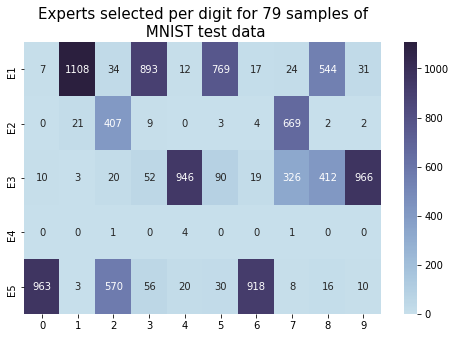

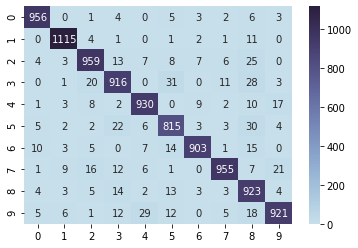

In [70]:
m = 'mnist_no_gate_temp3_argmax_without_reg'


print('Temp decay', no_gate_temps_3)

total_experts = 5
num_classes = 10
classes = range(num_classes)
num_epochs = 20

test_loader = testloader

plot_expert_usage(m, test_loader, w_importance_range=[0], total_experts=total_experts,num_classes=num_classes,no_gate_temps=no_gate_temps_3,
                        classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

Min Training Error 0.069
Mutual Information 1.501
Sample Entropy 1.355
Expert Usage 1.758
mnist_no_gate_temp2_argmax_with_reg_importance_0.8_moe_temp_0.01_10_5_models.pt


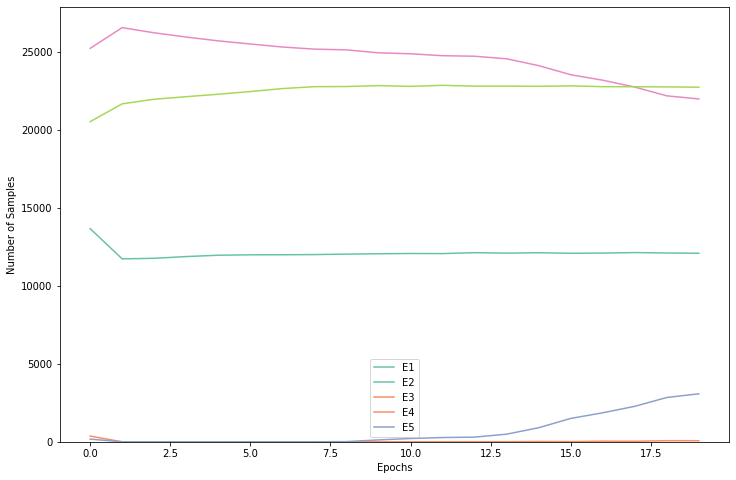

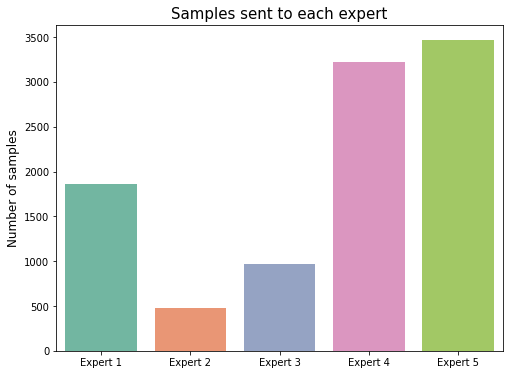

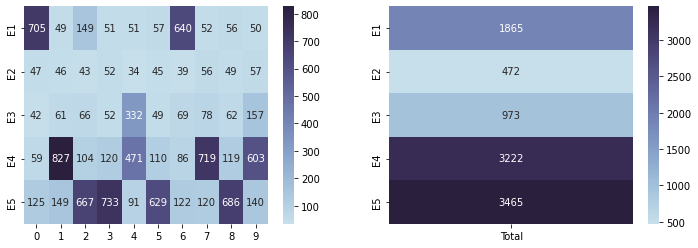


Experts used by the gate for classification of each digit


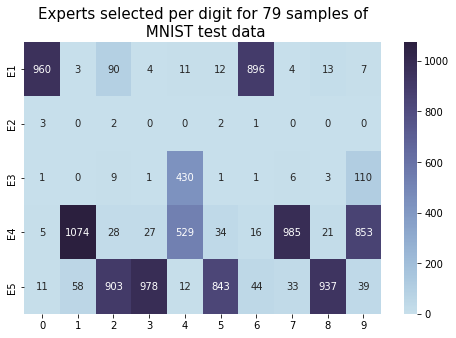

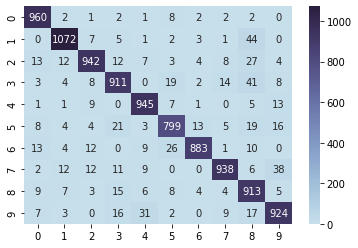

In [101]:
m = 'mnist_no_gate_temp2_argmax_with_reg'

total_experts = 5
num_classes = 10
classes = range(num_classes)
num_epochs = 20

test_loader = testloader

w_importance_range = [0.8]

plot_expert_usage(m, test_loader, w_importance_range=w_importance_range, total_experts=total_experts,num_classes=num_classes,no_gate_temps=no_gate_temps_2,
                        classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

Min Training Error 0.054
Mutual Information 1.452
Sample Entropy 1.426
Expert Usage 1.890
mnist_no_gate_temp3_argmax_without_reg_moe_temp_0.10_10_5_models.pt


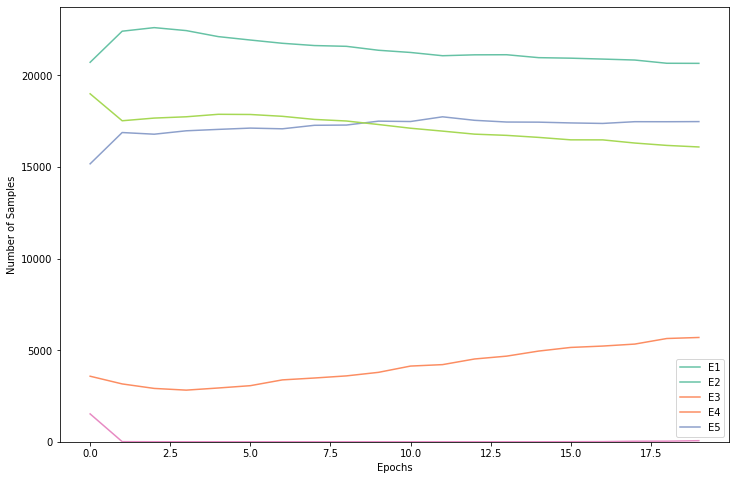

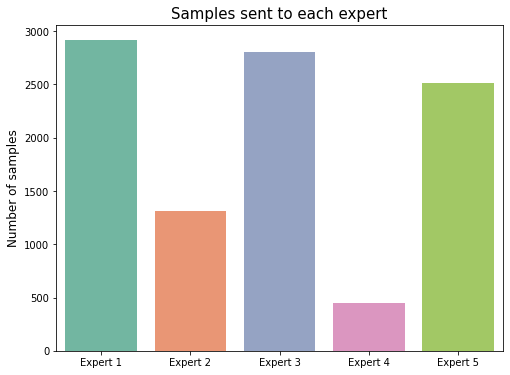

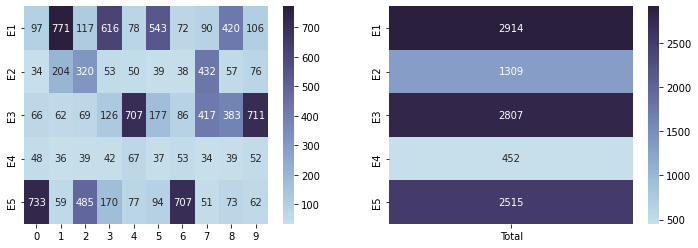


Experts used by the gate for classification of each digit


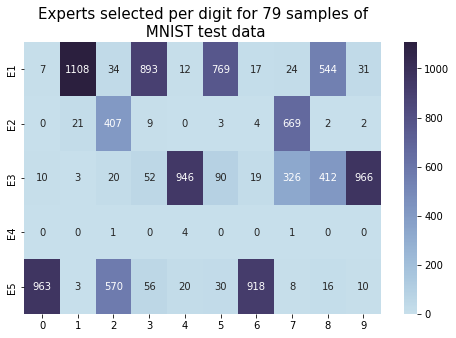

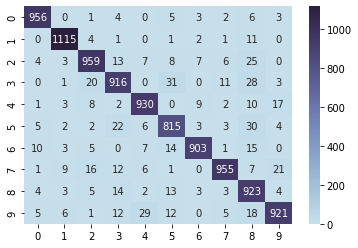

Min Training Error 0.066
Mutual Information 1.089
Sample Entropy 1.435
Expert Usage 1.546
mnist_no_gate_temp3_expectation_without_reg_moe_temp_0.10_10_5_models.pt


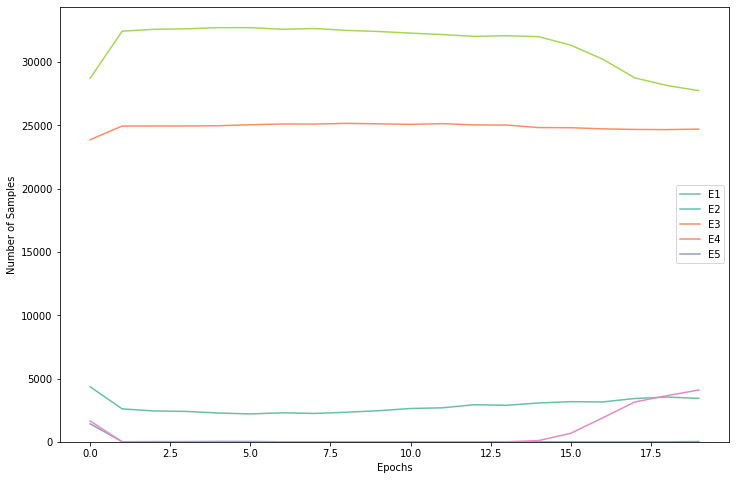

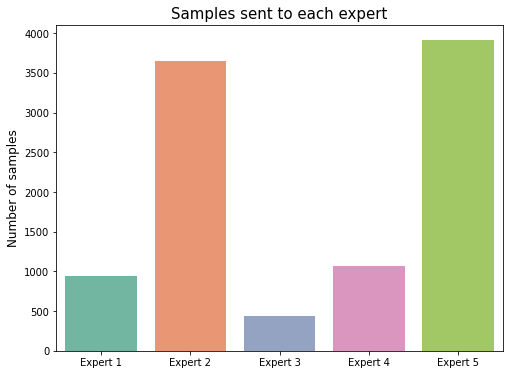

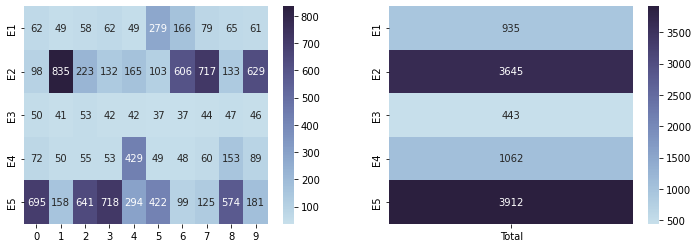


Experts used by the gate for classification of each digit


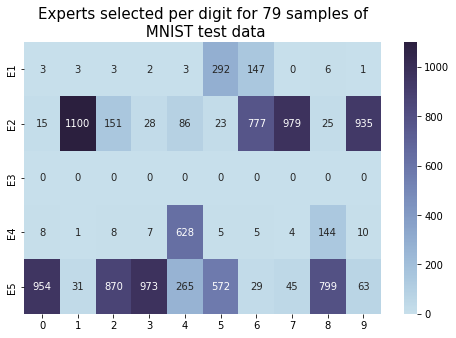

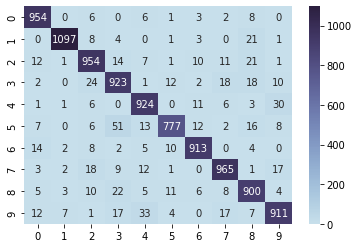

In [97]:
m = 'mnist_no_gate_temp3_expectation_without_reg'

total_experts = 5
num_classes = 10
classes = range(num_classes)
num_epochs = 20

test_loader = testloader

plot_expert_usage(m, test_loader, w_importance_range=[0], total_experts=total_experts,num_classes=num_classes,no_gate_temps=no_gate_temps_3,
                        classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

In [71]:
m = 'mnist_no_gate_argmax_with_reg'

total_experts = 5
num_classes = 10
classes = range(num_classes)
num_epochs = 20

test_loader = testloader


w_sample_sim_same_range = [1e-5]
w_sample_sim_diff_range = [1e-6]

plot_expert_usage(m, test_loader, total_experts=total_experts,num_classes=num_classes,
                  w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                  classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

TypeError: unsupported format string passed to list.__format__

Min Training Error 0.065
Mutual Information 0.183
Sample Entropy 2.245
Expert Usage 2.318
mnist_no_gate_argmax_without_reg_10_5_models.pt


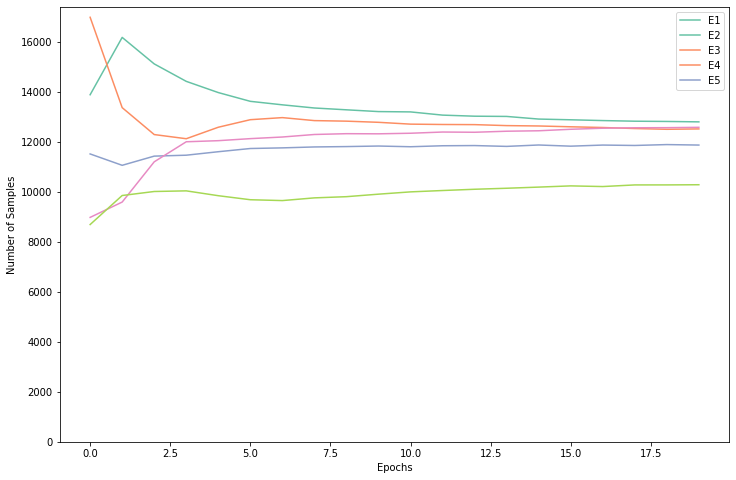

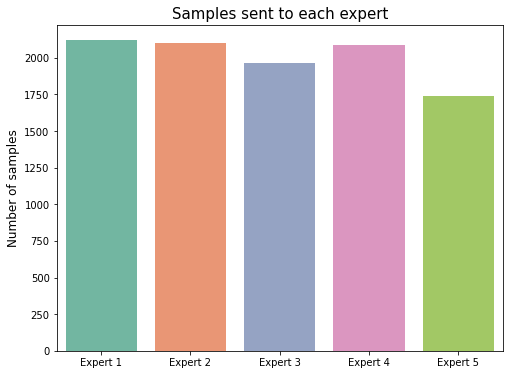

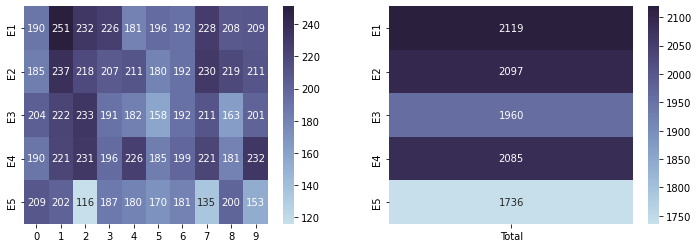


Experts used by the gate for classification of each digit


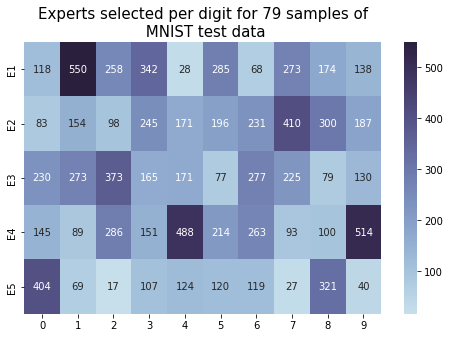

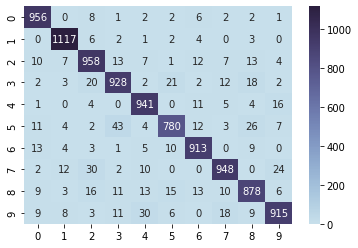

In [59]:
m = 'mnist_no_gate_argmax_without_reg'

total_experts = 5
num_classes = 10
classes = range(num_classes)
num_epochs = 20

test_loader = testloader

plot_expert_usage(m, test_loader, w_importance_range=[0], total_experts=total_experts,num_classes=num_classes,
                        classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

Min Training Error 0.107
Mutual Information 0.197
Sample Entropy 2.247
Expert Usage 2.320
mnist_no_gate_stochastic_without_reg_10_5_models.pt


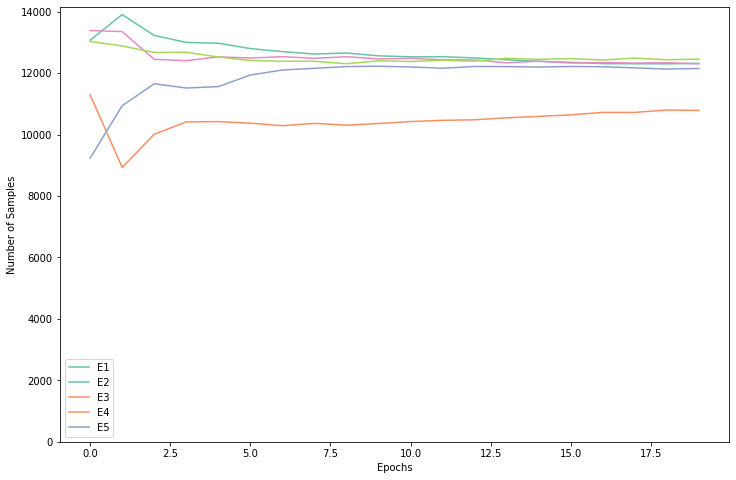

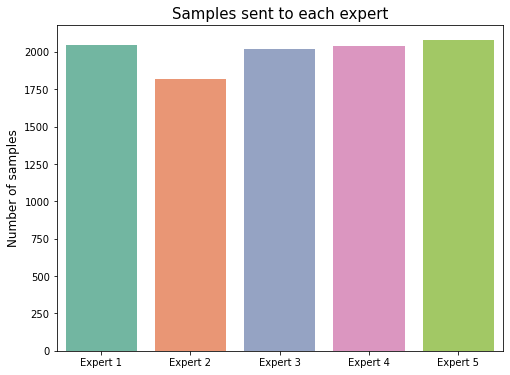

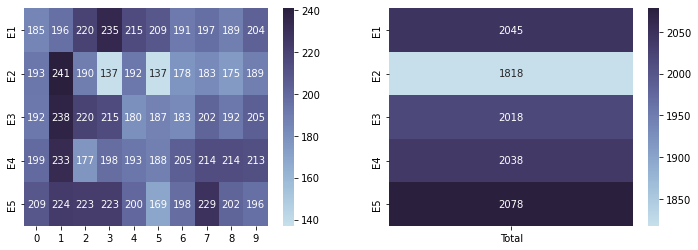


Experts used by the gate for classification of each digit


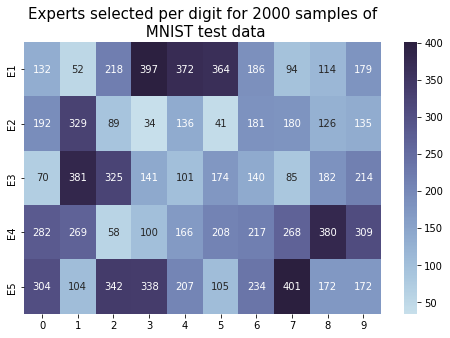

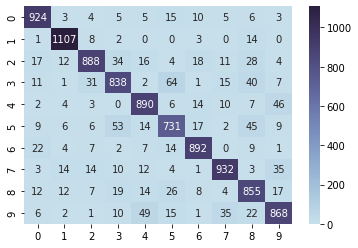

In [72]:
m= 'mnist_no_gate_stochastic_without_reg'

total_experts = 5
num_classes = 10
classes = range(num_classes)
num_epochs = 20

test_loader = testloader

plot_expert_usage(m, test_loader, w_importance_range=[0], total_experts=total_experts,num_classes=num_classes,
                        classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

Min Training Error 0.078
Mutual Information 0.514
Sample Entropy 2.206
Expert Usage 2.318
mnist_no_gate_expectation_with_reg_sample_sim_same_1e-05_sample_sim_diff_1e-06_10_5_models.pt


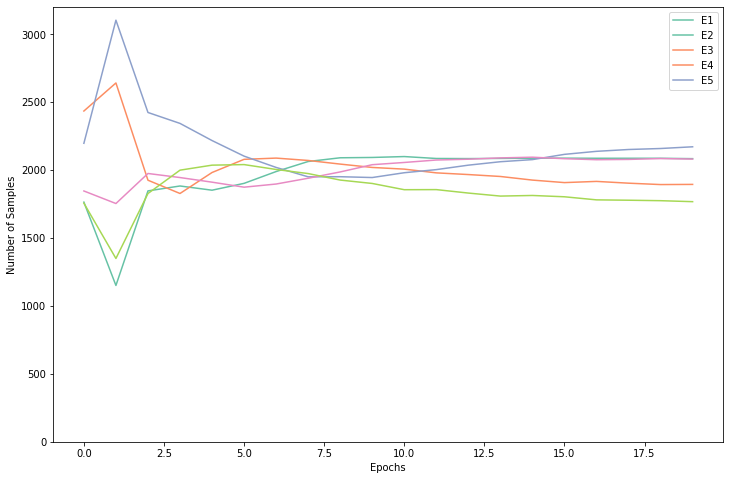

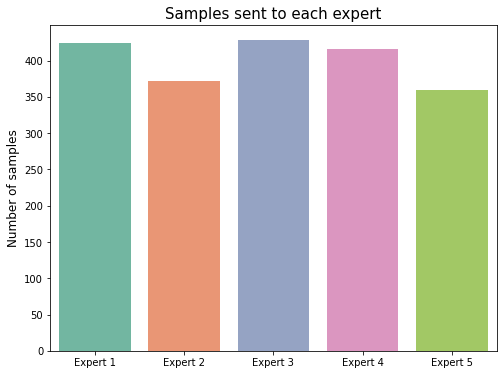

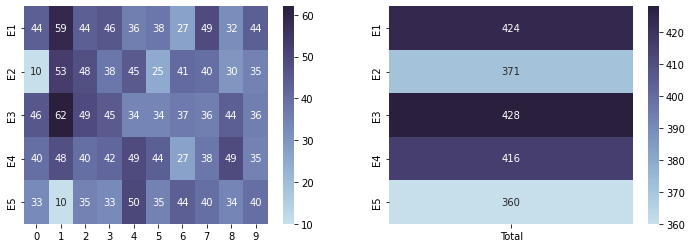


Experts used by the gate for classification of each digit


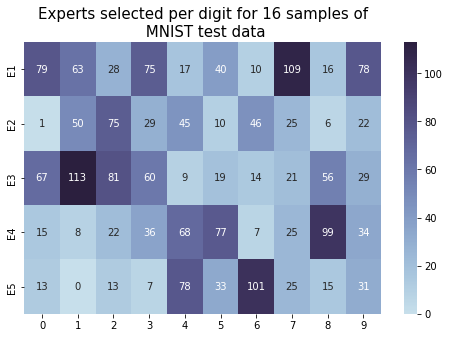

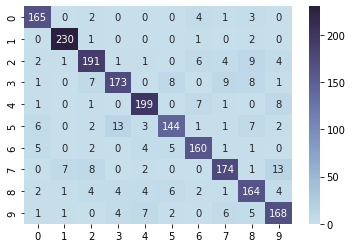

In [72]:
m = 'mnist_no_gate_expectation_with_reg'

total_experts = 5
num_classes = 10
classes = range(num_classes)
num_epochs = 20

test_loader = testloader


w_sample_sim_same_range = [1e-5]
w_sample_sim_diff_range = [1e-6]

plot_expert_usage(m, test_loader, total_experts=total_experts,num_classes=num_classes,
                  w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                  classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

temps [ 1.1  1.2  1.3  1.4  1.5  2.   4.   6.   8.  10. ]
w_importance_range [0.2, 0.4, 0.6000000000000001, 0.8, 1.0]


<Figure size 432x288 with 0 Axes>

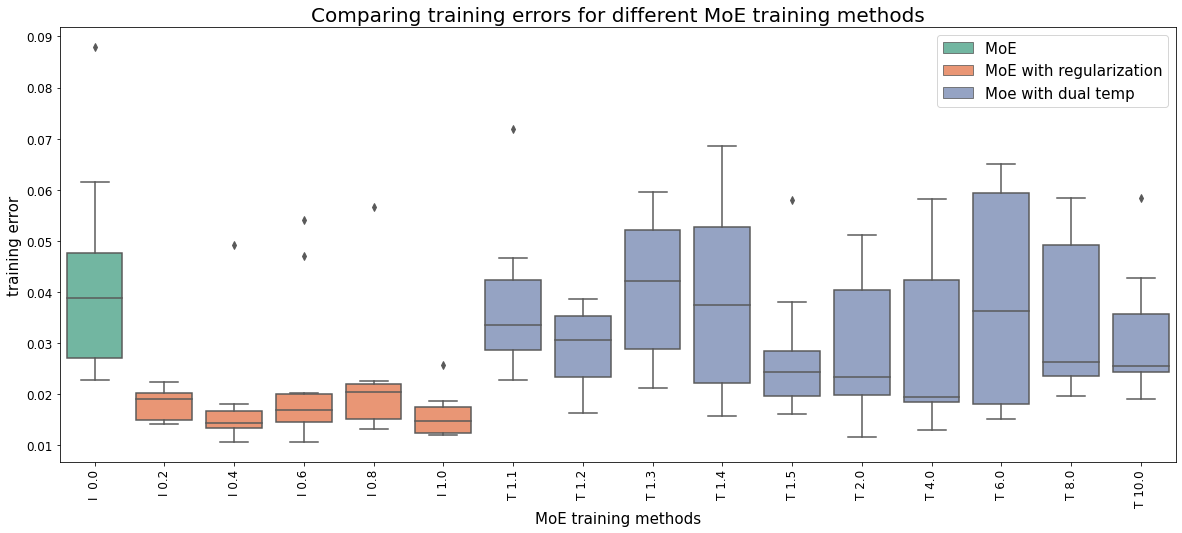

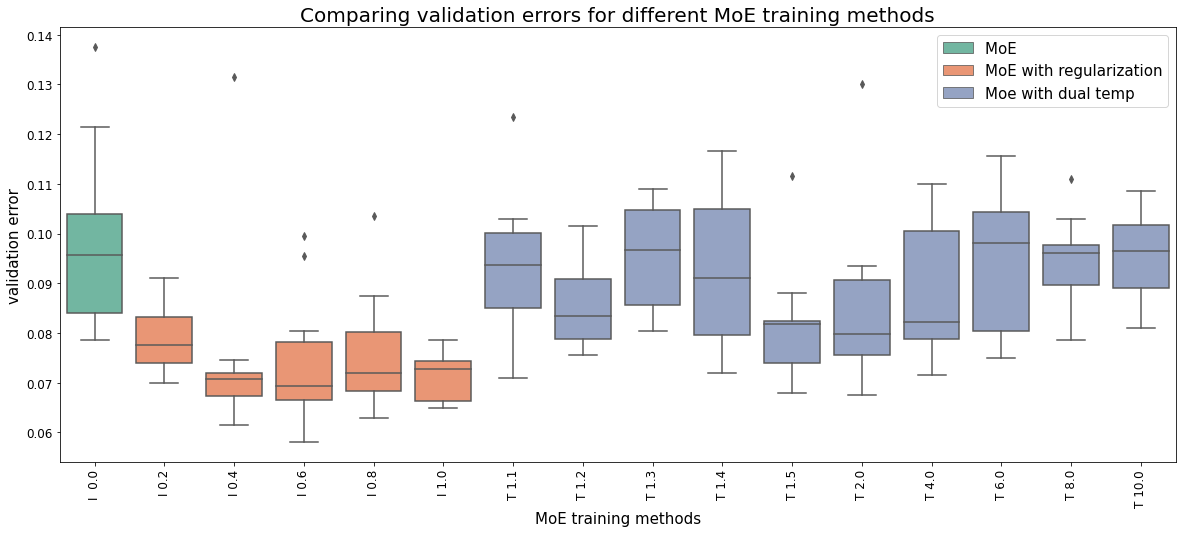

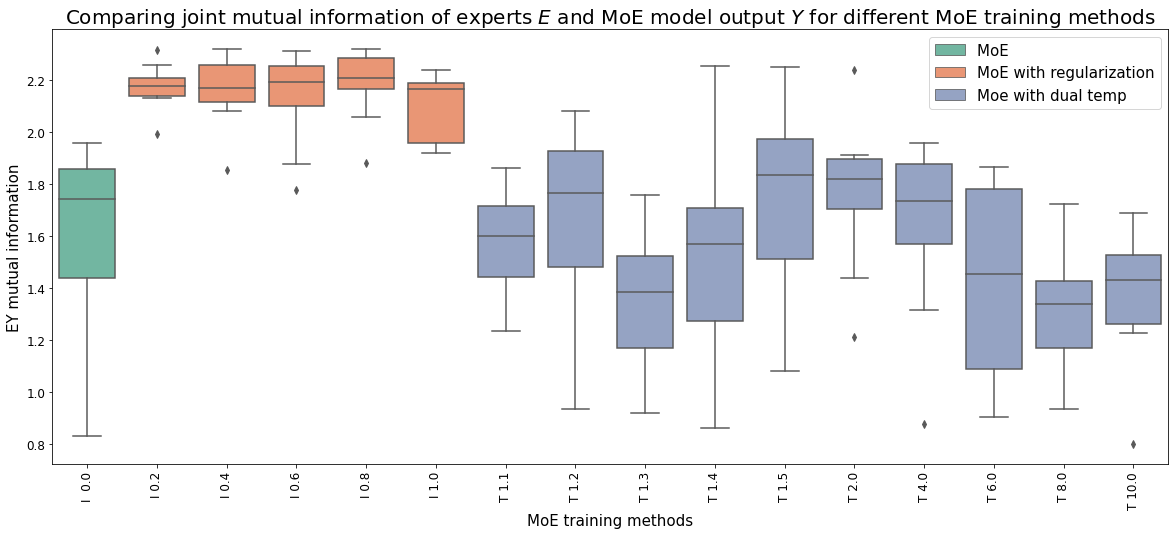

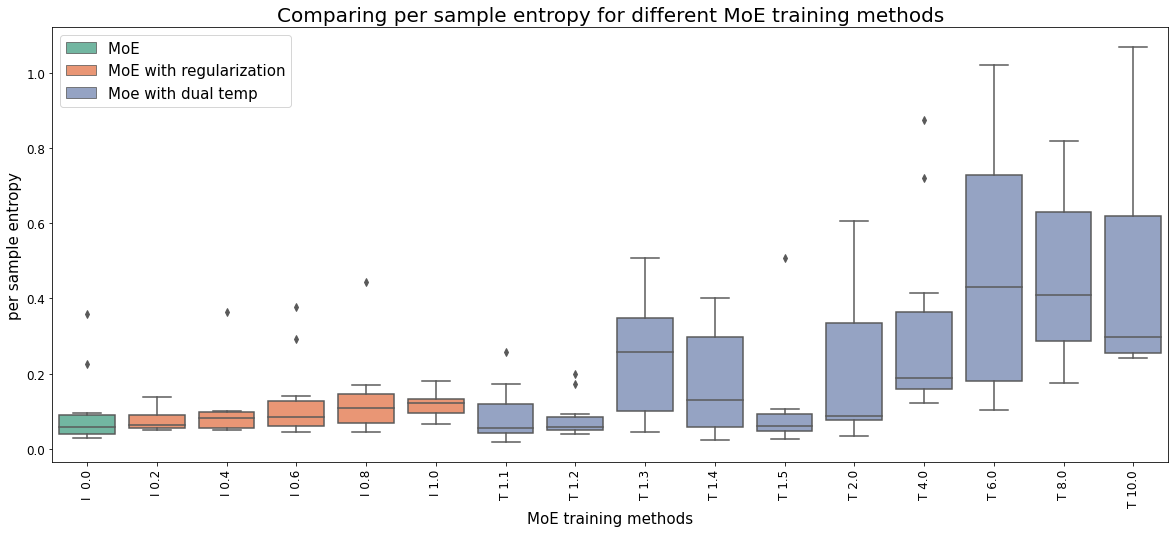

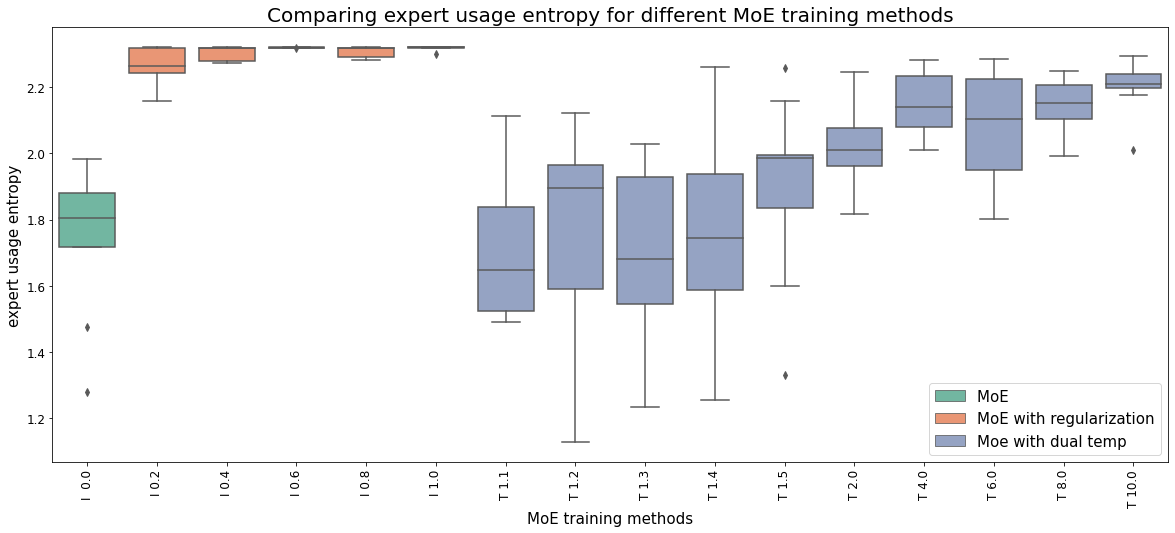

In [68]:
model_with_temp = {'ignore':'mnist_transform_dual_temp'}
model_with_reg = {'ignore':'mnist_transform_with_reg'}
model_without_reg = {'ignore':'mnist_transform_without_reg'}

total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 21, 2), np.arange(25, 51, 5)))
# temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 7, 2)))
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 11, 2)))
print('temps', temps)
w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range', w_importance_range)
        
boxplot(
        model_with_reg=model_with_reg, model_without_reg=model_without_reg, 
        model_with_temp = model_with_temp, 
        temps=temps,w_importance_range=w_importance_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), 
        testloader=testloader, figname='mnist_dual_temp')

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
                 total_experts, num_classes, classes, testloader):
    
    num_epochs = 20

    min_values = []
    max_values = []
    mean_values = []
    std_values = []
    mutual_info = []
    models = []

    w_importance = 0.0

    for T in temps:    

        m = model_with_temp

        plot_file = generate_plot_file(m, w_importance,'temp_'+"{:.1f}".format(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        print('Model:', plot_file)

        error_values = []
        for model in model_1:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                error_values.append(error[-1])

        models.append(model_1[np.argmin(error_values)])

        min_values.append("{:.3f}".format(min(error_values)))
        max_values.append("{:.3f}".format(max(error_values)))
        mean_values.append("{:.3f}".format(mean(error_values)))
        std_values.append("{:.3f}".format(np.std(error_values)))
        mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    T = [ 'T '+"{:.1f}".format(t) for t in temps]
    N_T = len(T)

    for w_importance in w_importance_range:

        m = model_with_reg

        plot_file = generate_plot_file(m, w_importance, str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
        print('Model:', plot_file)

        error_values = []
        for model in model_2:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                error_values.append(error[-1])

        models.append(model_2[np.argmin(error_values)])
#         models.append(model_2[-1])

        min_values.append("{:.3f}".format(min(error_values)))
        max_values.append("{:.3f}".format(max(error_values)))
        mean_values.append("{:.3f}".format(mean(error_values)))
        std_values.append("{:.3f}".format(np.std(error_values)))
        mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    N_I = len(w_importance_range)
    I = [ 'I '+"{:.1f}".format(i) for i in w_importance_range]

    m = model_without_reg

    plot_file = generate_plot_file(m, 0.0, str(num_classes)+'_'+str(total_experts)+'_models.pt')


    # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
    # model you build above
    model_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
    print('Model:', plot_file)

    error_values = []
    for model in model_3:
        history = model[e_key]['experts'][total_experts]['history']
        for e_key, e_val in model.items():
            error = 1-np.asarray(history['accuracy'])
            error_values.append(error[-1])

    models.append(model_3[np.argmin(error_values)])
#     models.append(model_3[-1])
    
    min_values.append("{:.3f}".format(min(error_values)))
    max_values.append("{:.3f}".format(max(error_values)))
    mean_values.append("{:.3f}".format(mean(error_values)))
    std_values.append("{:.3f}".format(np.std(error_values)))
    mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    method = T + I + ['I 0.0']
    N = N_T + N_I + 1

    print('N',N)
    data = np.hstack((np.asarray(method).reshape(N,1), np.asarray(min_values).reshape(N,1), np.asarray(max_values).reshape(N,1), 
                      np.asarray(mean_values).reshape(N,1), np.asarray(std_values).reshape(N,1), 
                      np.asarray(mutual_info).reshape(N,1)))

    print(data.shape)

    columns = ['Method', 'Min', 'Max', 'Mean', 'Std', 'Mutual Info']
    colors = np.array([['w']*len(columns)]*N)
    colors[np.argmin(data[:,1]), 1] = 'y'
    colors[np.argmax(data[:,2]), 2] = 'y'
    colors[np.argmin(data[:,3]), 3] = 'y'
    colors[np.argmin(data[:,4]), 4] = 'y'
    colors[np.argmax(data[:,5]), 5] = 'y'

    fig, ax = plt.subplots()
    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    ax.table(cellText=data, colLabels=columns, cellColours=colors, loc='center')

    fig.tight_layout()

    plt.show()


    model = models[np.argmin(data[0:N_T,1])]

    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model with reg
    for e_key, e_val in model.items():


        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()


    model = models[N_T+np.argmin(data[N_T:N-1,1])]
    
    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model without reg
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()

    model = models[-1]

    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model without reg
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()

    # plot error rates
    fig2,ax2 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16,4))
    ax2 = ax2.flatten()

    fig3,ax3 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

    fig4,ax4 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))
    
    fig5,ax5 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

    for i, model in enumerate(models):
        for e_key, e_val in model.items():

            # plot training and validation error rates
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(model[e_key]['experts'][total_experts]['history']['accuracy']), ax=ax2[0])
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(model[e_key]['experts'][total_experts]['history']['val_accuracy']), ax=ax2[1])

            # plot training loss
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['loss']), ax=ax3)

            # plot mutual information
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['mutual_EY']), ax=ax4)

            # plot mutual information
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['H_EY']), ax=ax5)

    legend = data[:,0]

    ax2[0].legend(legend)

    ax2[0].set_xlabel('epochs')
    ax2[0].set_xticks(range(num_epochs+1))
    ax2[0].set_ylabel('train error rate')
    ax2[0].set_ylim(ymin=0)


    ax2[1].legend(legend)

    ax2[1].set_xlabel('epochs')
    ax2[1].set_xticks(range(num_epochs+1))
    ax2[1].set_ylabel('validation error rate')
    ax2[1].set_ylim(ymin=0)


    ax3.legend(legend)

    ax3.set_xlabel('epochs')
    ax3.set_xticks(range(num_epochs+1))
    ax3.set_ylabel('training loss')
    ax3.set_ylim(ymin=0)

    ax4.legend(legend)

    ax4.set_xlabel('epochs')
    ax4.set_xticks(range(num_epochs+1))
    ax4.set_ylabel('mutual information')
    ax4.set_ylim(ymin=0)
    
    ax5.legend(legend)

    ax5.set_xlabel('epochs')
    ax5.set_xticks(range(num_epochs+1))
    ax5.set_ylabel('Entropy EY')
    ax5.set_ylim(ymin=0)

    plt.show()


### Results for MNIST data

In [ ]:
model_with_temp = 'mnist_dual_temp'
model_with_reg = 'mnist_with_regularization'
model_without_reg = 'mnist_without_regularization'
total_experts = 5
num_classes = 10
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_with_temp = 'mnist_imbalanced_5_dual_temp'
model_with_reg = 'mnist_imbalanced_5_with_regularization'
model_without_reg = 'mnist_imbalanced_5_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_with_temp = 'rot_mnist_dual_temp'
model_with_reg = 'rot_mnist_with_regularization'
model_without_reg = 'rot_mnist_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

rot_unrot_mnist_classes = ['0','1','2','3','4','rotated 0', 'rotated 1', 'rotated 2', 'rotated 3', 'rotated 4']
plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes,rot_unrot_mnist_classes , rot_unrot_testloader)

### Results for combined FMNIST and MNIST data

In [ ]:
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)

In [66]:
import pandas as pd
from helper.moe_models import entropy

def plot_expert_usage(model_name, temps=[1.0], w_importance_range=[0], w_sample_sim_range=[0], 
                   total_experts=5, num_classes=10, classes=None, num_epochs=20, 
                   testloader=None, caption=None, index=0):
    
    m = model_name
    
    palette = sns.color_palette("Set2")
    fig,ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(18, 6))
    fontsize = 20
    label_fontsize = 15

    legend = []
    for T, w_importance, w_sample_sim in product(temps, w_importance_range, w_sample_sim_range):
                    
        
        
        print('Temperature','{:.1f}'.format(T))
        print('Importance','{:.1f}'.format(w_importance))
        print('Sample sim','{:.1f}'.format(w_sample_sim))
        
        legend.append('T '+'{:.1f}'.format(T))
        
        plot_file = generate_plot_file(m, temp=T, w_importance=w_importance, w_sample_sim=w_sample_sim, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

        model = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)[index]
        

        for e_key, e_val in model.items():
            y_expert_usage = []
            y_expert_usage_T = []
            
            history = model[e_key]['experts'][total_experts]['history']
            gate_probability = torch.vstack(history['gate_probabilities']).view(num_epochs, -1, total_experts)
            gate_probabilities_sum = torch.mean(gate_probability, dim=1)

            if T > 1:
                gate_probability_T = torch.vstack((history['gate_probabilities_T'])).view(num_epochs, -1, total_experts)
                gate_probabilities_T_sum = torch.mean(gate_probability_T, dim=1)
            
            labels = []
            for epoch in range(num_epochs):
                y_expert_usage.append(entropy(gate_probabilities_sum[epoch]).item())
                    
                if T > 1:
                    y_expert_usage_T.append(entropy(gate_probabilities_T_sum[epoch]).item())
                    
            sns.lineplot(x=range(20), y=y_expert_usage, ax=ax[0])
            ax[0].legend(legend, loc='upper right') 
#             ax[0].set_ylabel('Number of samples per expert', fontsize=label_fontsize)
#             ax[0].set_xlabel('Epochs', fontsize=label_fontsize)
#             ax[0].set_title(caption, 
#                             loc='center', wrap=True, fontsize=fontsize)
            if T > 1:
                sns.lineplot(x=range(20), y=y_expert_usage_T, ax=ax[1])
#                 df_T = pd.DataFrame(y_gate_prob_T, index=list(range(1,num_epochs+1)))            
#                 df_T.plot(kind='bar', stacked=True, color=palette, ax=ax[1])
#                 ax[1].legend(loc='upper right') 
#                 ax[1].set_ylabel('Number of samples per expert', fontsize=label_fontsize)
#                 ax[1].set_xlabel('Epochs', fontsize=label_fontsize)
#                 ax[1].set_title('Distribution of samples to experts by the gate, \n during training, with high temperature (T='+'{:.1f}'.format(T)+')\n', 
#                                 loc='center', wrap=True, fontsize=fontsize)
#             else:
#                 ax[1].axis('off')
                
#             plt.tight_layout()
#             plot_file = generate_plot_file(m, temp=T, w_importance=w_importance, w_sample_sim=w_sample_sim, specific=str(num_classes)+'_'+str(total_experts)+'_barplot.png')
#             if T>1:
#                 plt.savefig(os.path.join(fig_path, plot_file))
#             else:
#                 extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#                 plt.savefig(os.path.join(fig_path, plot_file), bbox_inches=extent.expanded(1.3, 1.5))
#             plt.show()
            


[1.1, 1.5, 2, 10, 20, 30, 40, 50]
Temperature 1.1
Importance 0.0
Sample sim 0.0
Temperature 1.5
Importance 0.0
Sample sim 0.0
Temperature 2.0
Importance 0.0
Sample sim 0.0
Temperature 10.0
Importance 0.0
Sample sim 0.0
Temperature 20.0
Importance 0.0
Sample sim 0.0
Temperature 30.0
Importance 0.0
Sample sim 0.0
Temperature 40.0
Importance 0.0
Sample sim 0.0
Temperature 50.0
Importance 0.0
Sample sim 0.0


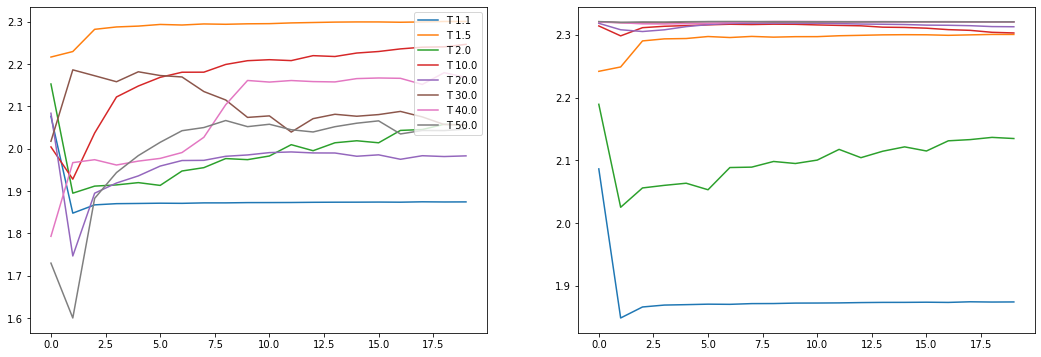

In [70]:
model_with_temp = 'mnist_dual_temp'

total_experts = 5
num_epochs = 20

temps = list(np.arange(1.1,1.6,0.1))+ list(np.arange(2,21,2))+list(np.arange(25,51,5))
temps = [1.1,1.5, 2,10,20,30,40,50]
print(temps)

caption = 'Distribution of samples to experts by the gate, \n during training, with low temperature (T=1)\n'

plot_expert_usage(model_with_temp, temps, total_experts=total_experts, num_classes=num_classes, 
               classes=range(num_classes), num_epochs=num_epochs, 
               testloader=testloader, caption=caption, index=1)

In [54]:
import pandas as pd

def plot_gate_prob(model_name, temps=[1.0], w_importance_range=[0], w_sample_sim_range=[0], 
                   total_experts=5, num_classes=10, classes=None, num_epochs=20, 
                   testloader=None, caption=None, index=0):
    
    m = model_name
    
    for T, w_importance, w_sample_sim in product(temps, w_importance_range, w_sample_sim_range):
                    
        y_gate_prob = {} 
        y_gate_prob_T = {} 
        
        print('Temperature','{:.1f}'.format(T))
        print('Importance','{:.1f}'.format(w_importance))
        print('Sample sim','{:.1f}'.format(w_sample_sim))

        plot_file = generate_plot_file(m, temp=T, w_importance=w_importance, w_sample_sim=w_sample_sim, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

        model = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)[index]
        palette = sns.color_palette("Set2")
        fig,ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(18, 6))
        fontsize = 20
        label_fontsize = 15

        for e_key, e_val in model.items():
            history = model[e_key]['experts'][total_experts]['history']
            gate_probability = torch.vstack(history['gate_probabilities']).view(num_epochs, -1, total_experts)
            gate_probabilities_sum = torch.sum(gate_probability, dim=1).detach().cpu().numpy()
            
            if T > 1:
                gate_probability_T = torch.vstack((history['gate_probabilities_T'])).view(num_epochs, -1, total_experts)
                gate_probabilities_T_sum = torch.sum(gate_probability_T, dim=1).detach().cpu().numpy()
            
            labels = []
            for epoch in range(num_epochs):
                for e in range(total_experts):
                    y_gate_prob['Expert '+str(e+1)] = gate_probabilities_sum[:,e]
                    
                    if T > 1:
                        y_gate_prob_T['Expert'+str(e+1)] = gate_probabilities_T_sum[:,e]
                    
                    labels.append('E'+str(e))
            df = pd.DataFrame(y_gate_prob, index=list(range(1,num_epochs+1)))
            df.plot(kind='bar', stacked=True, color=palette, ax=ax[0])   
            ax[0].legend(loc='upper right') 
            ax[0].set_ylabel('Number of samples per expert', fontsize=label_fontsize)
            ax[0].set_xlabel('Epochs', fontsize=label_fontsize)
            ax[0].set_title(caption, 
                            loc='center', wrap=True, fontsize=fontsize)
            if T > 1:
                df_T = pd.DataFrame(y_gate_prob_T, index=list(range(1,num_epochs+1)))            
                df_T.plot(kind='bar', stacked=True, color=palette, ax=ax[1])
                ax[1].legend(loc='upper right') 
                ax[1].set_ylabel('Number of samples per expert', fontsize=label_fontsize)
                ax[1].set_xlabel('Epochs', fontsize=label_fontsize)
                ax[1].set_title('Distribution of samples to experts by the gate, \n during training, with high temperature (T='+'{:.1f}'.format(T)+')\n', 
                                loc='center', wrap=True, fontsize=fontsize)
            else:
                ax[1].axis('off')
                
            plt.tight_layout()
            plot_file = generate_plot_file(m, temp=T, w_importance=w_importance, w_sample_sim=w_sample_sim, specific=str(num_classes)+'_'+str(total_experts)+'_barplot.png')
            if T>1:
                plt.savefig(os.path.join(fig_path, plot_file))
            else:
                extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
                plt.savefig(os.path.join(fig_path, plot_file), bbox_inches=extent.expanded(1.3, 1.5))
            plt.show()
            


In [67]:
def plot_gate_prob(model_with_temp, temps, total_experts, num_classes, classes, num_epochs, testloader):
    
    m = model_with_temp
    
    for T in temps:
        
        print('Temperature','{:.1f}'.format(T))

        plot_file = generate_plot_file(m, temp=T, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)[1]
        
        for e_key, e_val in model.items():
            history = model[e_key]['experts'][total_experts]['history']
            gate_probability = torch.vstack(history['gate_probabilities']).view(num_epochs, -1, total_experts)
            gate_probability_T = torch.vstack((history['gate_probabilities_T'])).view(num_epochs, -1, total_experts)
            print(gate_probability.shape)
            
            gate_probabilities_sum = torch.sum(gate_probability, dim=1).detach().cpu().numpy()
            gate_probabilities_T_sum = torch.sum(gate_probability_T, dim=1).detach().cpu().numpy()
            
            fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(12, 8))
            palette = sns.color_palette("Set2")
            legend = []
            for i in range(total_experts):
                sns.lineplot(x=range(num_epochs), y=gate_probabilities_sum[:,i], color=palette[i], marker='o', ax=ax)
                sns.scatterplot(x=range(num_epochs), y=gate_probabilities_sum[:,i], color=palette[i],marker='o',s=80, ax=ax)
                sns.lineplot(x=range(num_epochs), y=gate_probabilities_T_sum[:,i], color=palette[i], marker='^', ax=ax)  
                sns.scatterplot(x=range(num_epochs), y=gate_probabilities_T_sum[:,i], color=palette[i], marker='^',s=80, ax=ax)  

                legend += ['Low Temp E '+str(i+1), 'High Temp  E '+str(i+1)]
            ax.set_ylim(bottom=0)
            plt.legend(legend)
            plt.show()
        
            
        
    



In [144]:
filenames = os.listdir(model_path)
for f in filenames:
    if "mnist_with_reg_test_importance" in f:
        print(os.path.join(model_path, f.replace('_test_','_')))
        os.replace(os.path.join(model_path,f),
                   os.path.join(model_path, f.replace('_test_','_')))

../models/test/mnist_with_reg_importance_0.6_10_5_models.pt
../models/test/mnist_with_reg_importance_1.0_10_5_models.pt
../models/test/mnist_with_reg_importance_0.8_10_5_models.pt
../models/test/mnist_with_reg_importance_1.0_sample_sim_1.0_10_5_models.pt
../models/test/mnist_with_reg_importance_0.4_10_5_models.pt
../models/test/mnist_with_reg_importance_0.2_10_5_models.pt


[1.1, 1.2000000000000002, 1.3000000000000003, 1.4000000000000004, 1.5000000000000004, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50]
Temperature 1.1
Importance 0.0
Sample sim 0.0


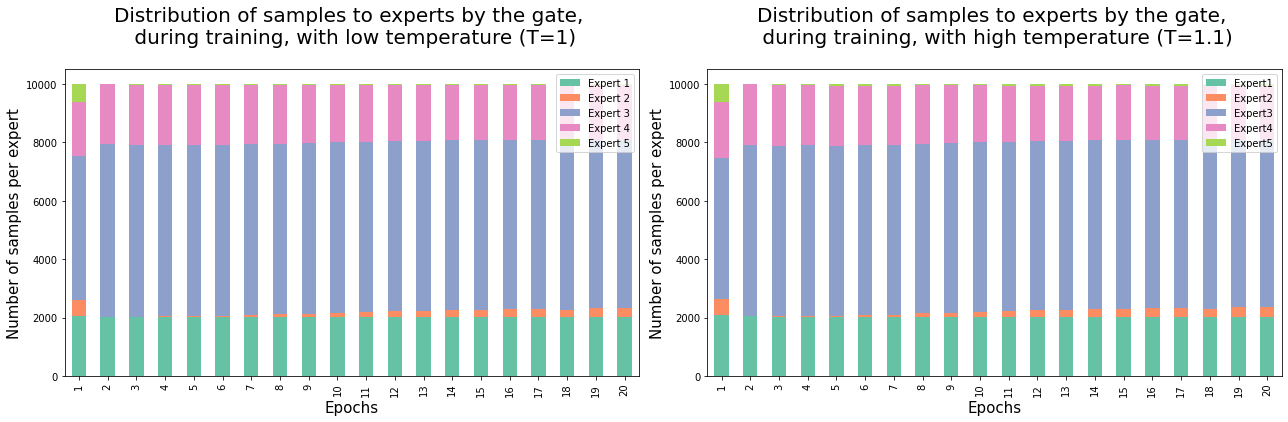

Temperature 1.2
Importance 0.0
Sample sim 0.0


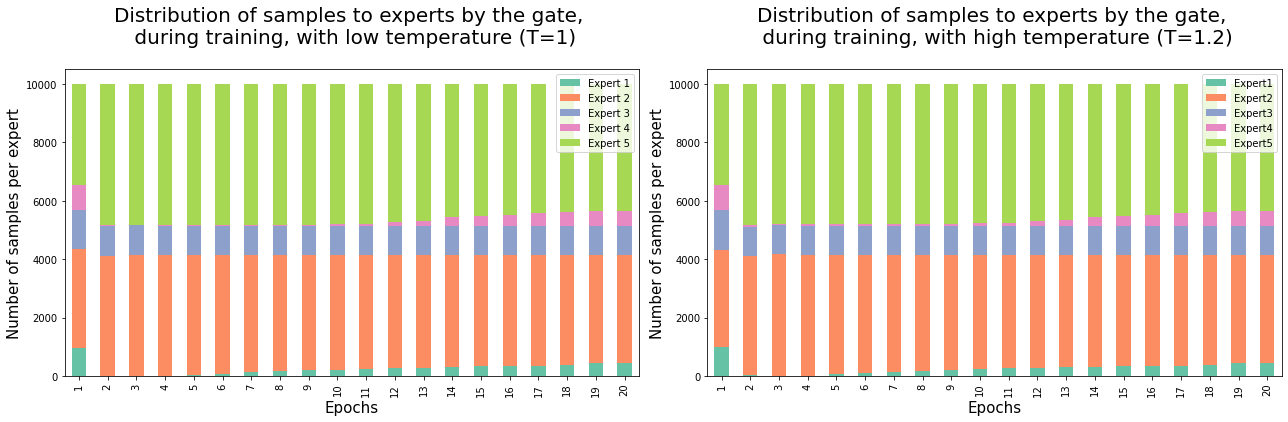

Temperature 1.3
Importance 0.0
Sample sim 0.0


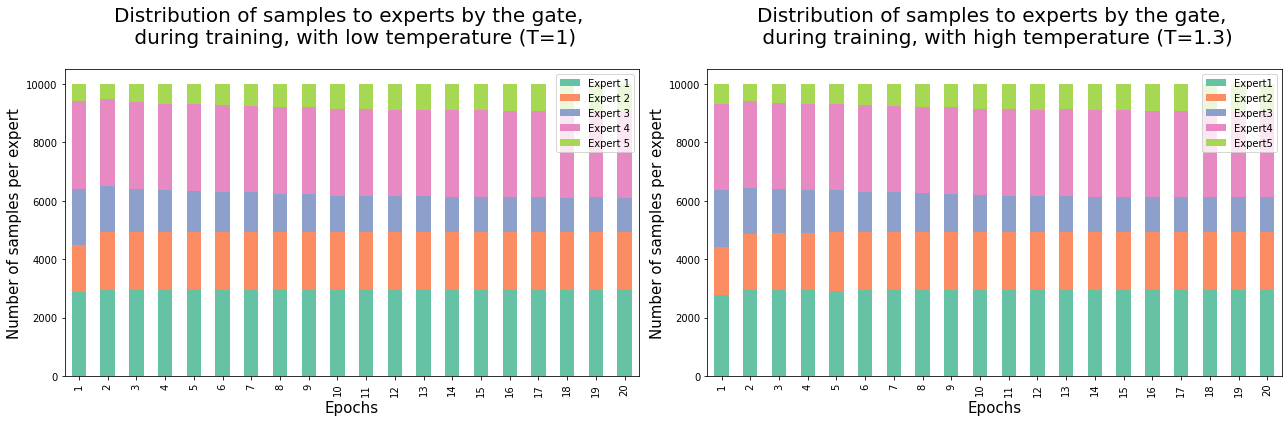

Temperature 1.4
Importance 0.0
Sample sim 0.0


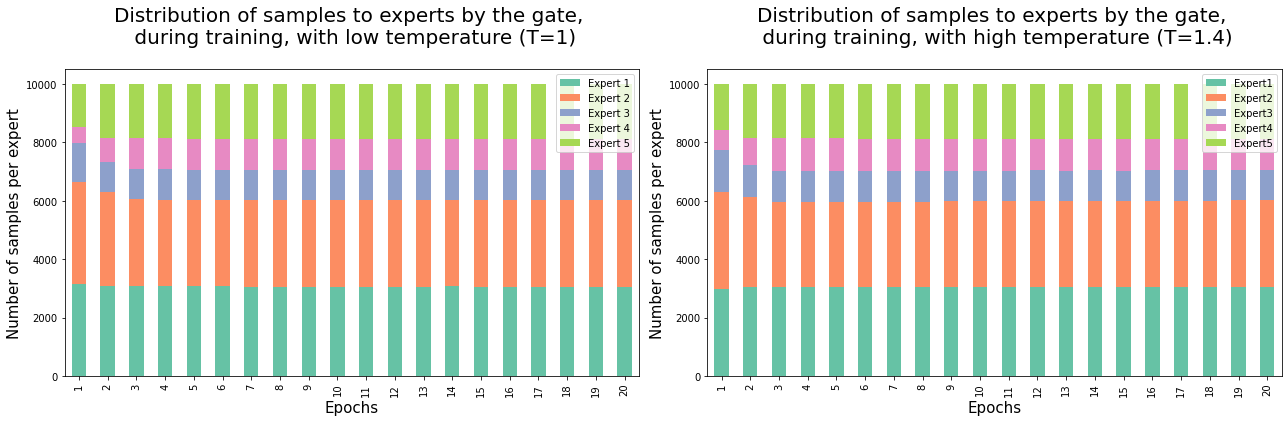

Temperature 1.5
Importance 0.0
Sample sim 0.0


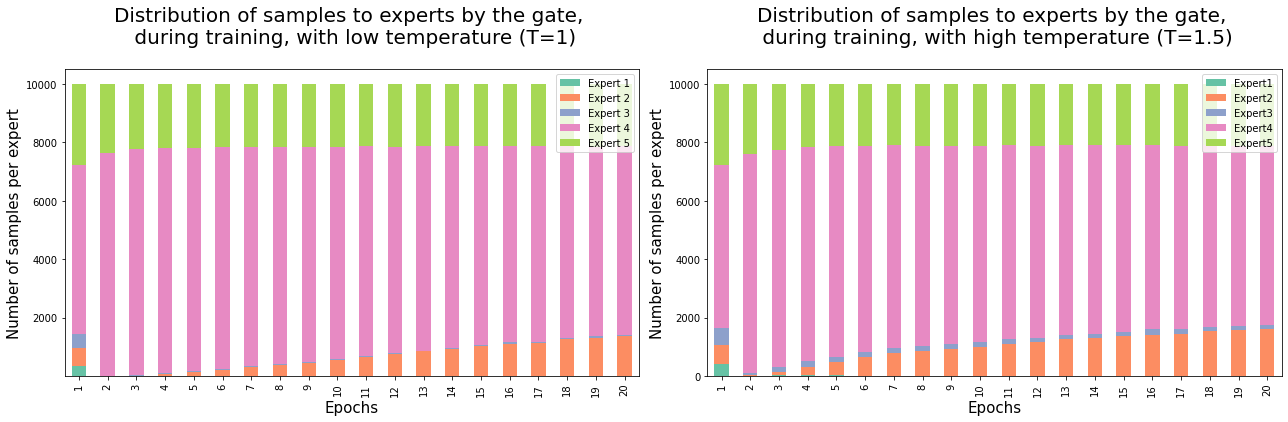

Temperature 2.0
Importance 0.0
Sample sim 0.0


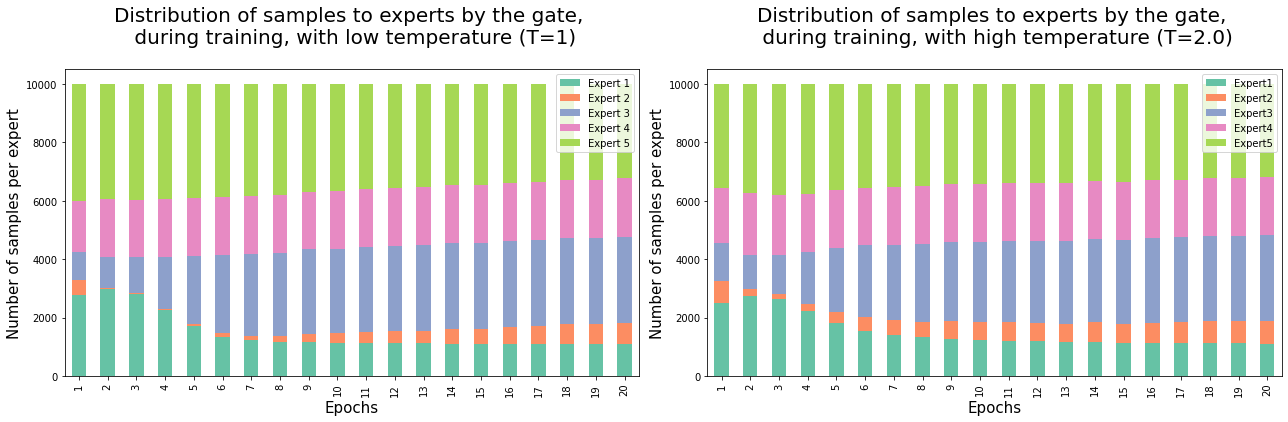

Temperature 4.0
Importance 0.0
Sample sim 0.0


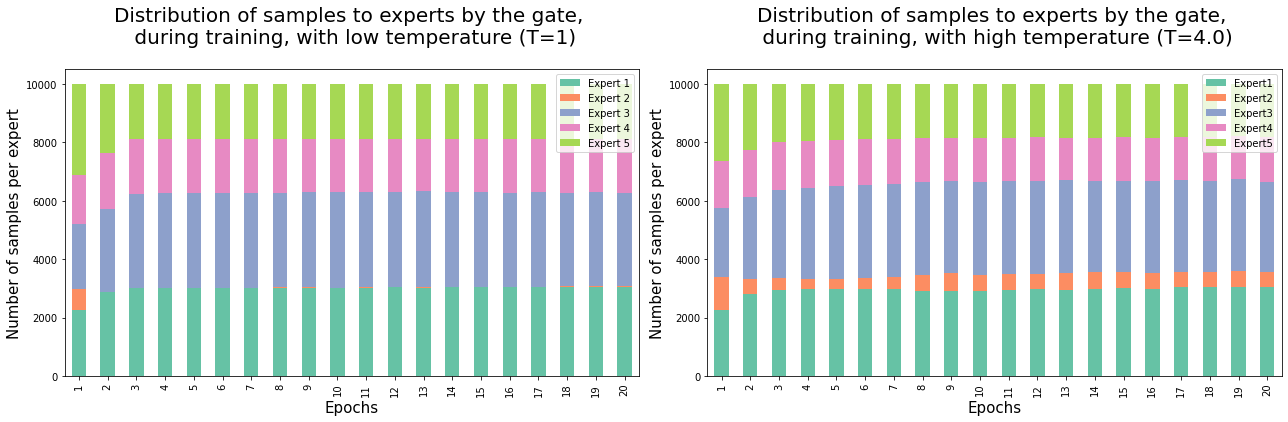

Temperature 6.0
Importance 0.0
Sample sim 0.0


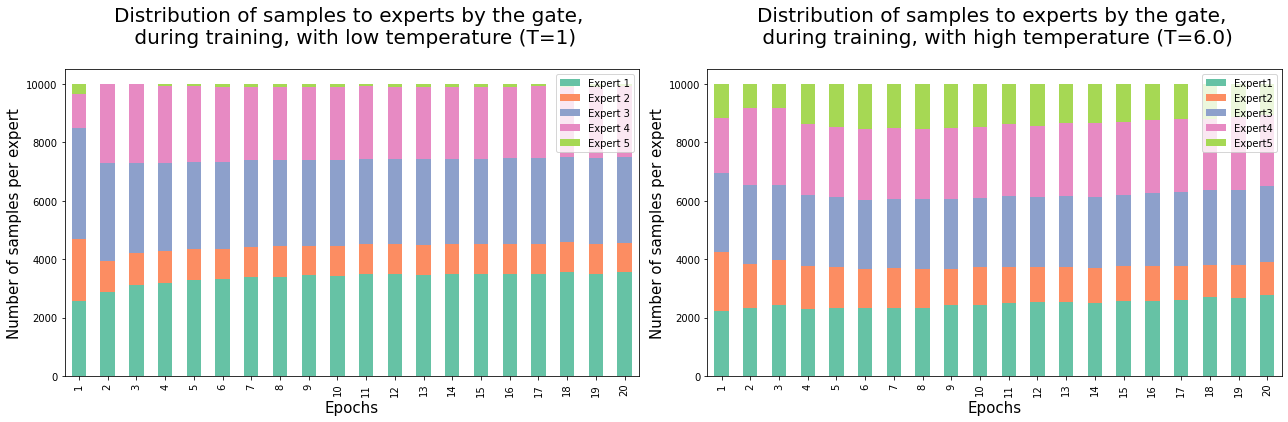

Temperature 8.0
Importance 0.0
Sample sim 0.0


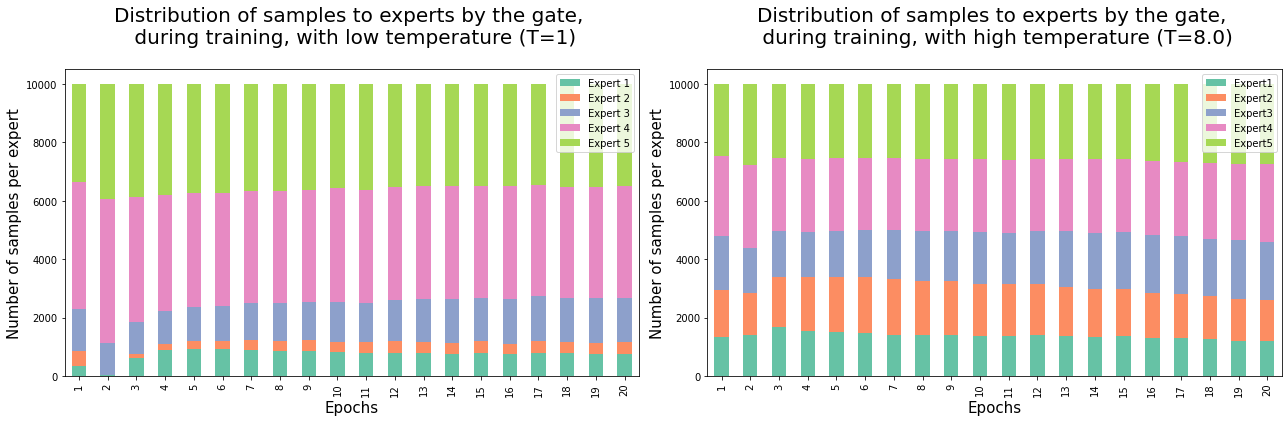

Temperature 10.0
Importance 0.0
Sample sim 0.0


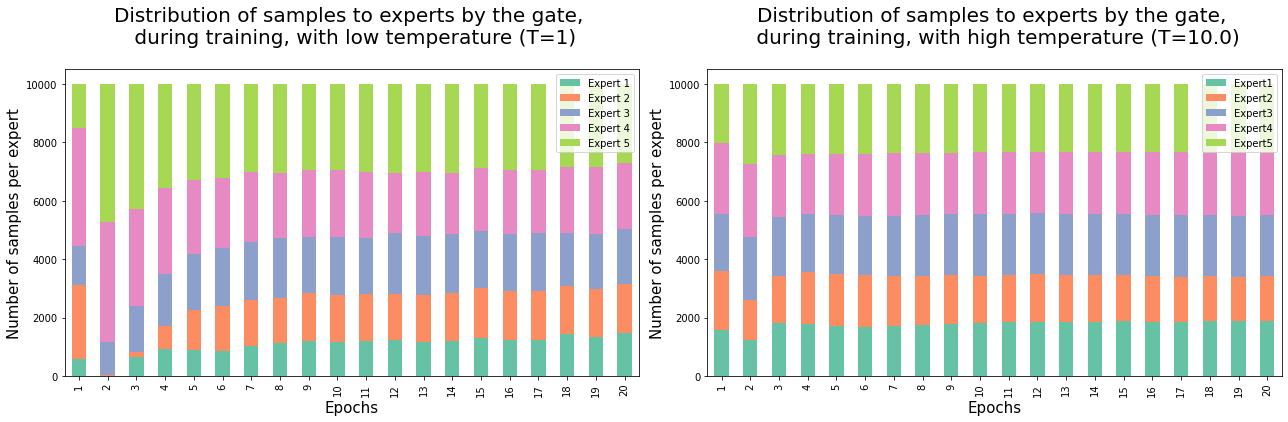

Temperature 12.0
Importance 0.0
Sample sim 0.0


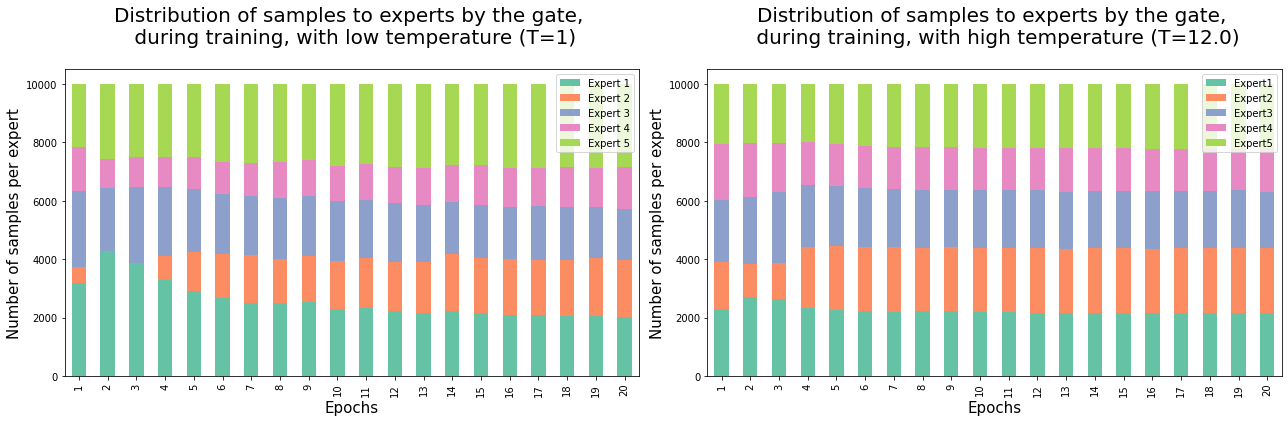

Temperature 14.0
Importance 0.0
Sample sim 0.0


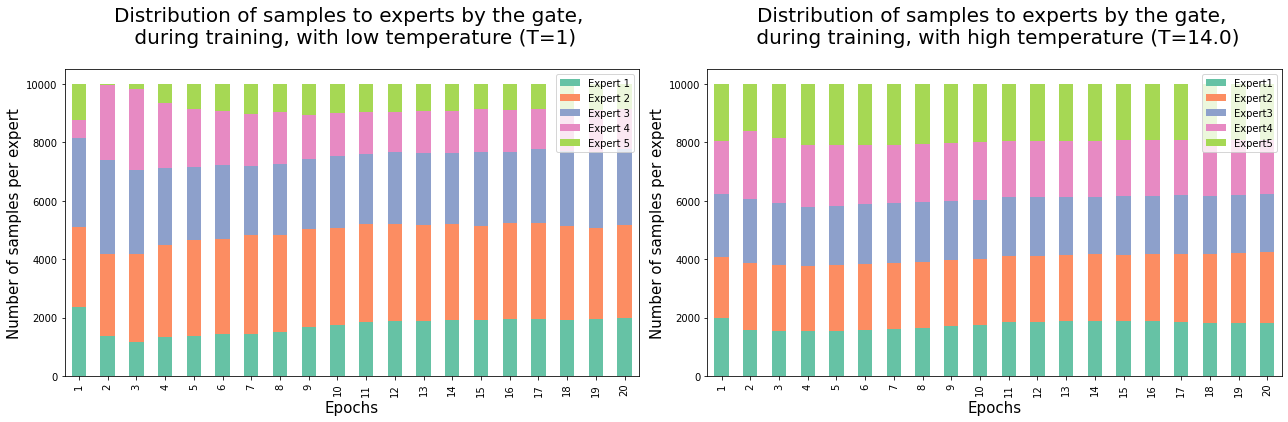

Temperature 16.0
Importance 0.0
Sample sim 0.0


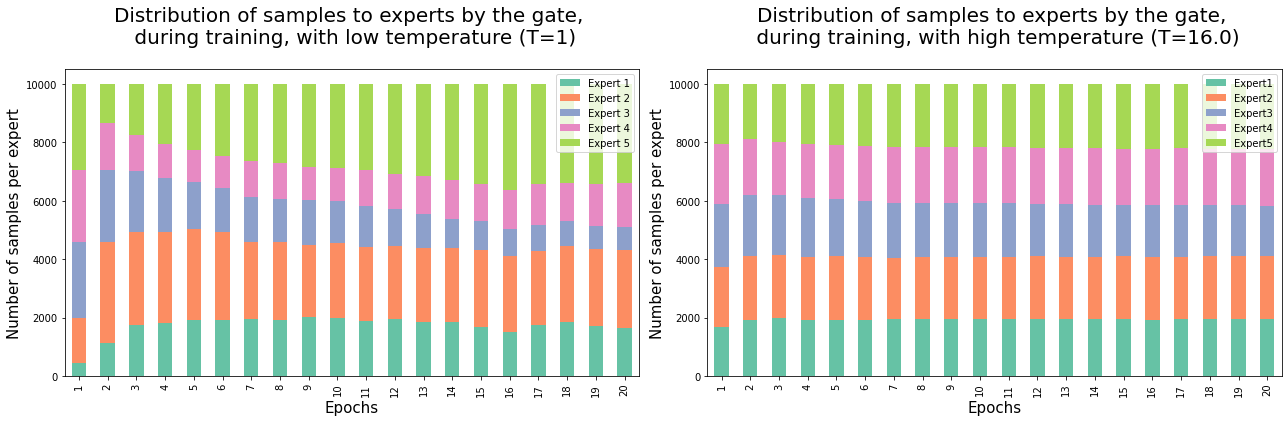

Temperature 18.0
Importance 0.0
Sample sim 0.0


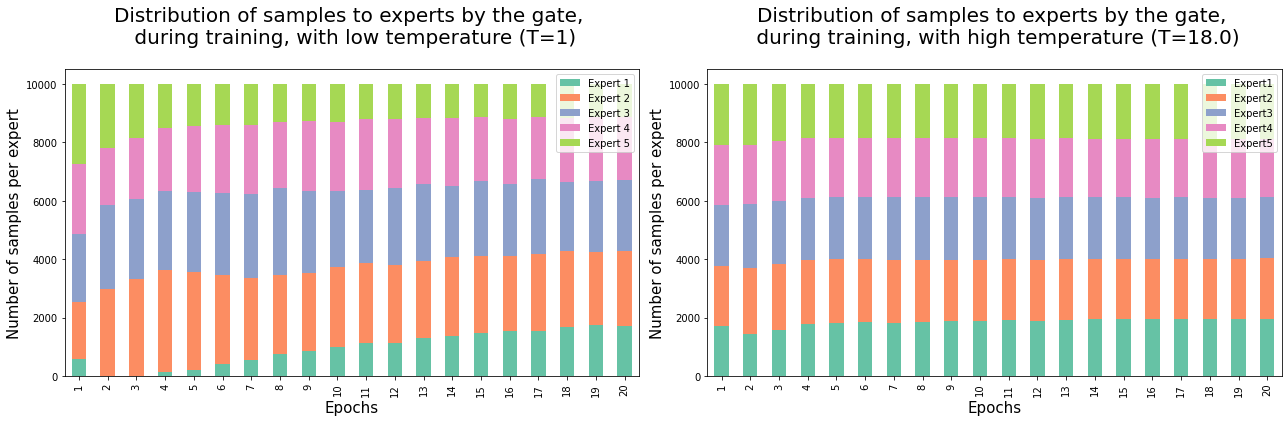

Temperature 20.0
Importance 0.0
Sample sim 0.0


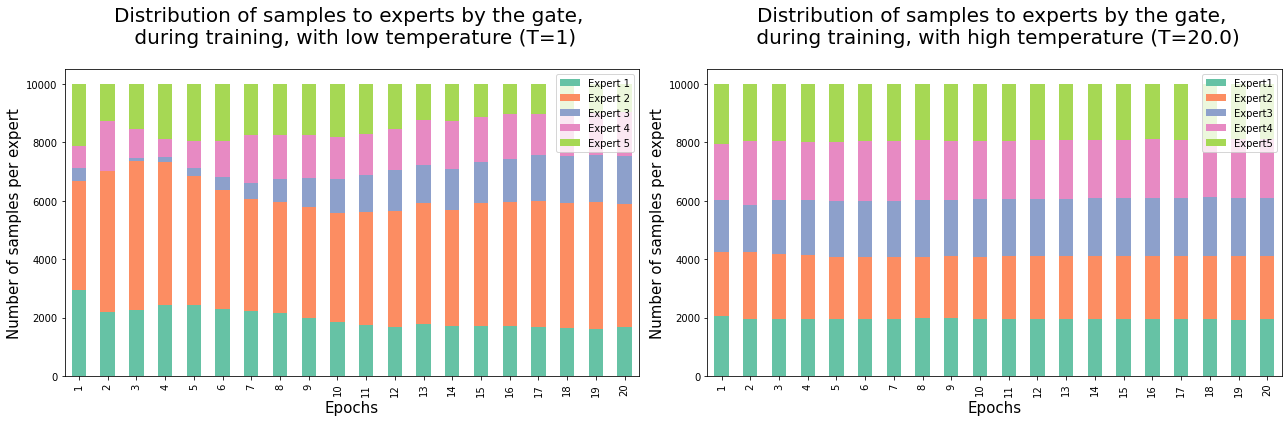

Temperature 25.0
Importance 0.0
Sample sim 0.0


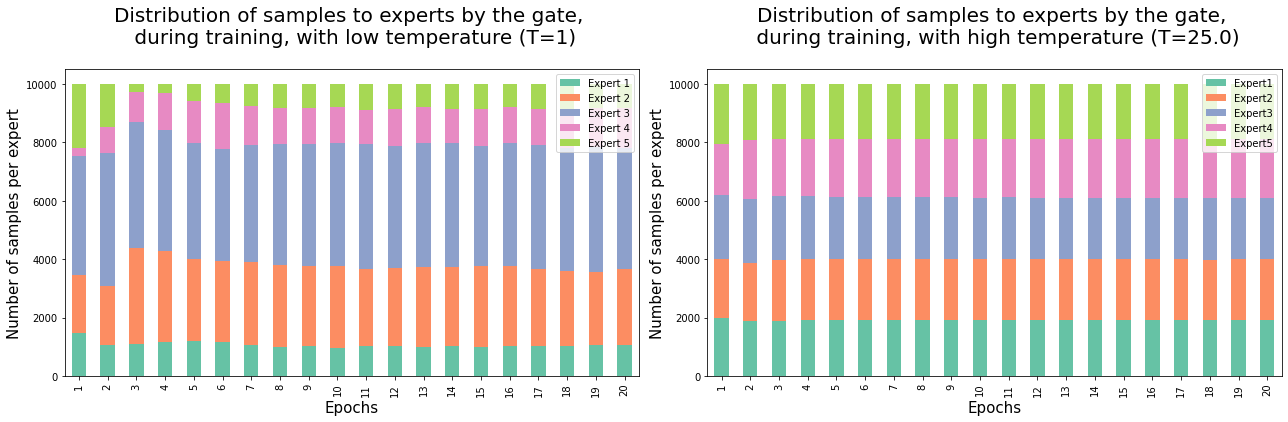

Temperature 30.0
Importance 0.0
Sample sim 0.0


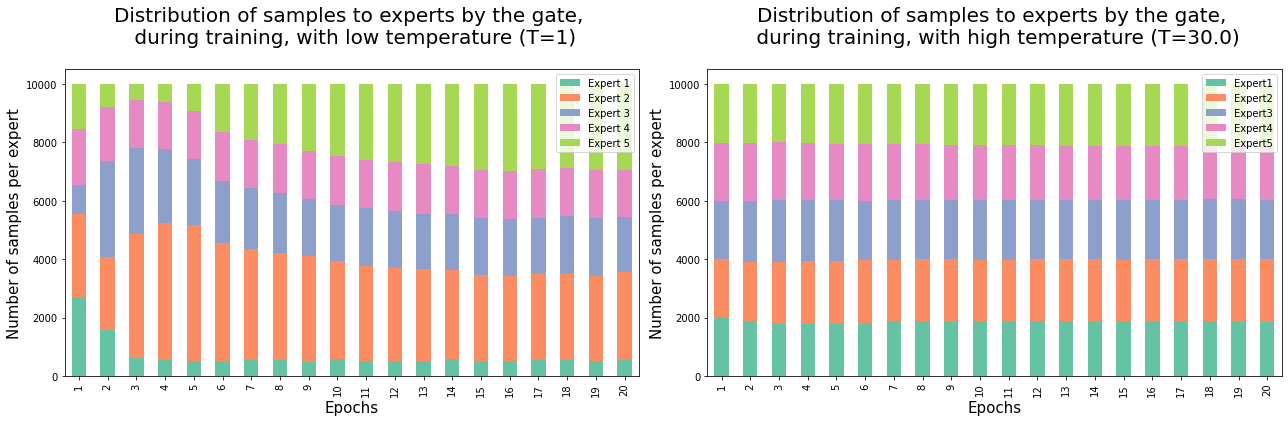

Temperature 35.0
Importance 0.0
Sample sim 0.0


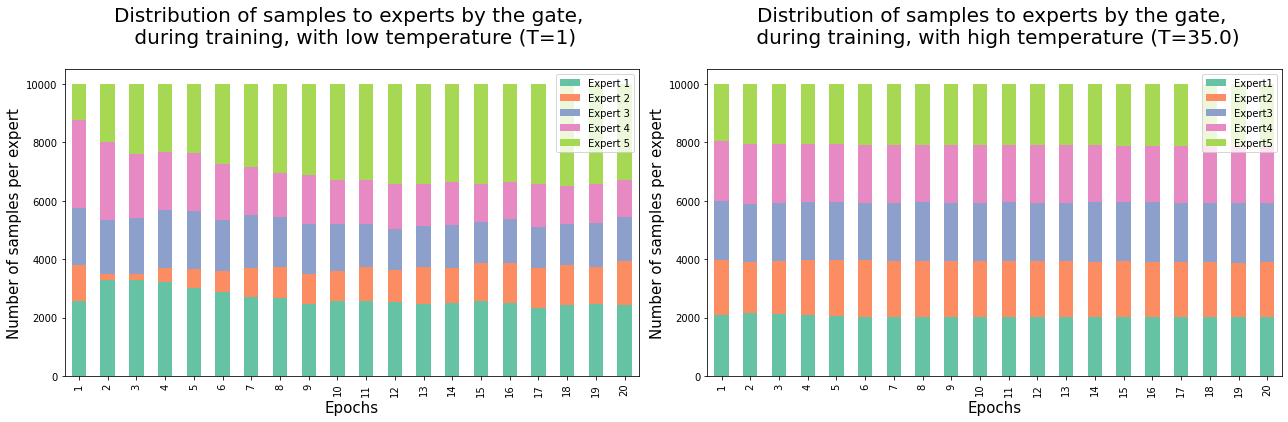

Temperature 40.0
Importance 0.0
Sample sim 0.0


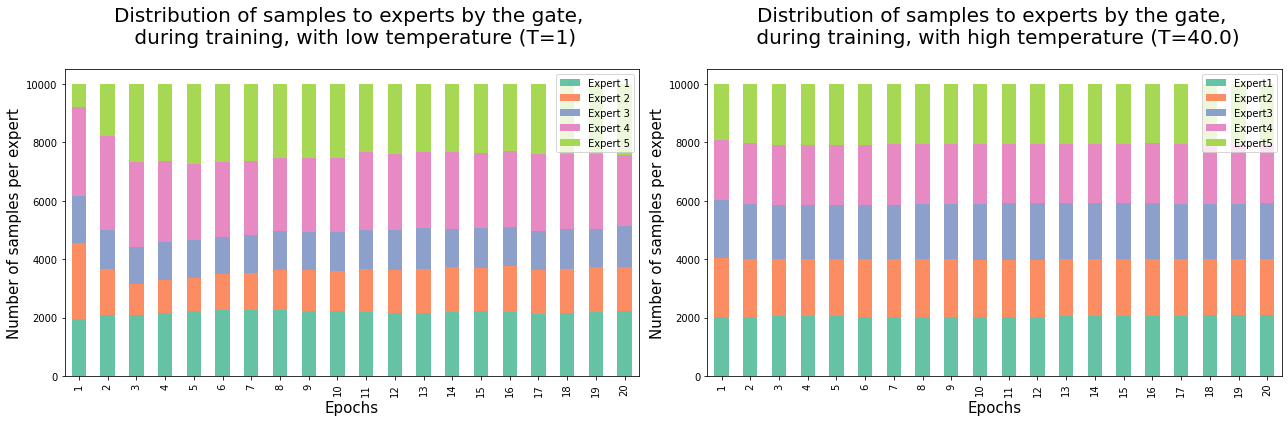

Temperature 45.0
Importance 0.0
Sample sim 0.0


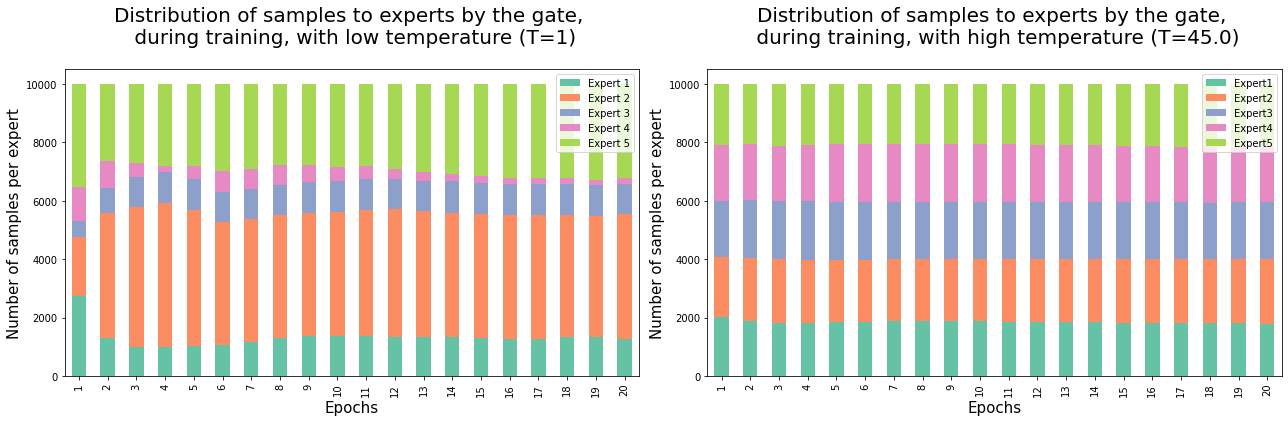

Temperature 50.0
Importance 0.0
Sample sim 0.0


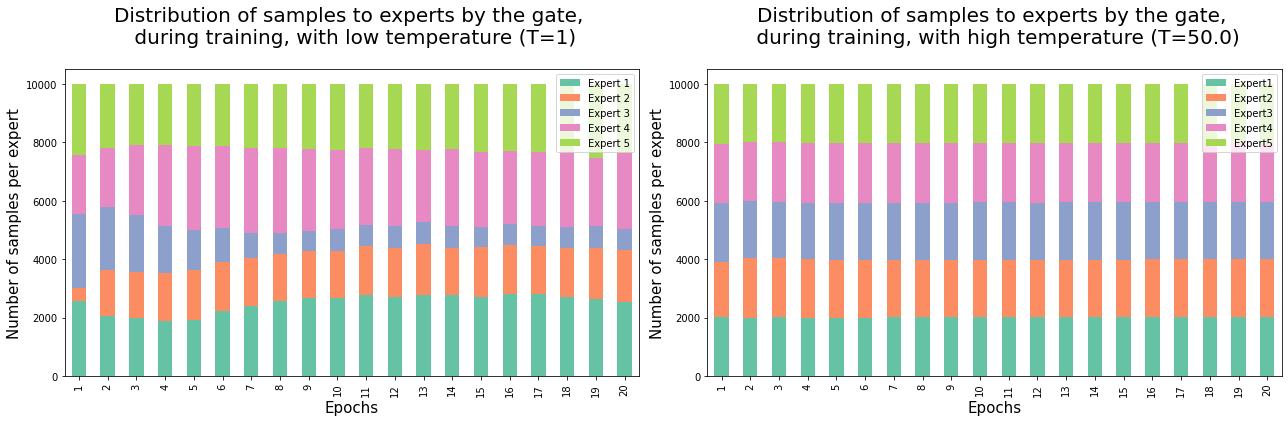

In [93]:
model_with_temp = 'mnist_dual_temp'

total_experts = 5
num_epochs = 20

temps = list(np.arange(1.1,1.6,0.1))+ list(np.arange(2,21,2))+list(np.arange(25,51,5))
print(temps)

caption = 'Distribution of samples to experts by the gate, \n during training, with low temperature (T=1)\n'

plot_gate_prob(model_with_temp, temps, total_experts=total_experts, num_classes=num_classes, 
               classes=range(num_classes), num_epochs=num_epochs, 
               testloader=testloader, caption=caption, index=5)

[20]
Temperature 20.0
Importance 0.0
Sample sim 0.0


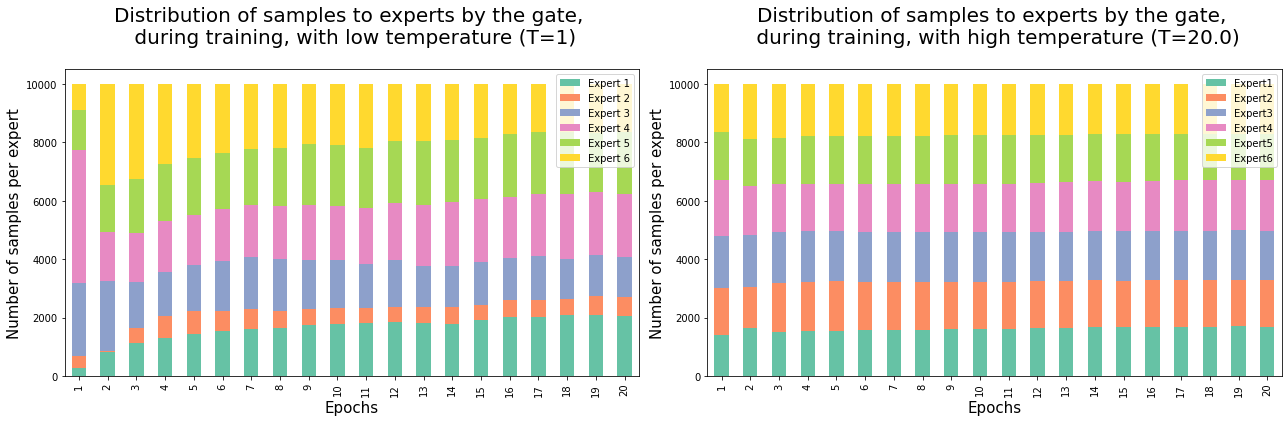

In [116]:
model_with_temp = 'fmnist_mnist_dual_temp'

total_experts = 6
num_epochs = 20

temps = list(np.arange(1.1,1.6,0.1))+ list(np.arange(2,21,2))+list(np.arange(25,51,5))
temps = [20]
print(temps)

caption = 'Distribution of samples to experts by the gate, \n during training, with low temperature (T=1)\n'

plot_gate_prob(model_with_temp, temps, total_experts=total_experts, num_classes=num_classes_fmnist_mnist, 
               classes=range(num_classes), num_epochs=num_epochs, 
               testloader=testloader, caption=caption, index=0)

Temperature 1.0
Importance 0.0
Sample sim 0.0


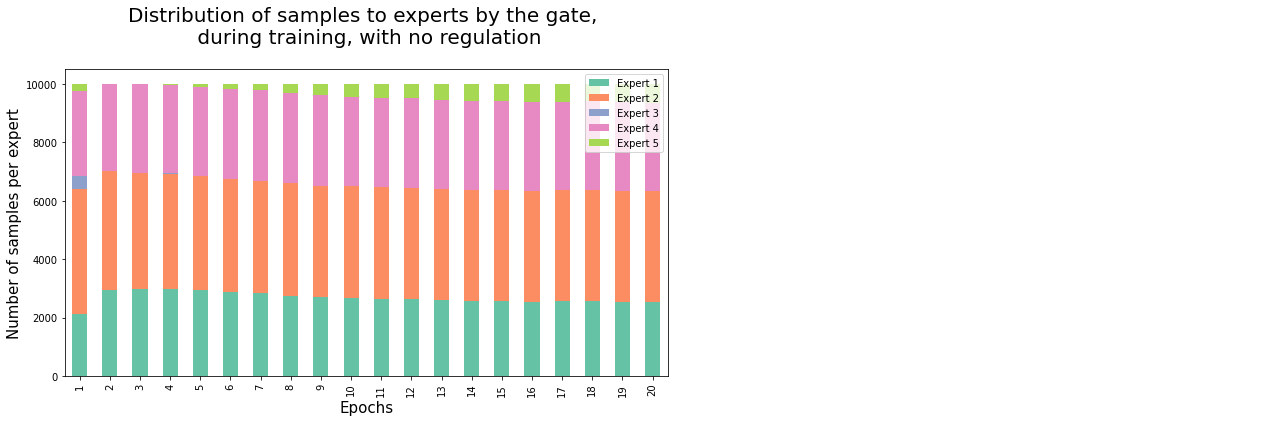

In [62]:
model_without_reg = 'mnist_without_reg_test'

total_experts = 5
num_epochs = 20

caption = 'Distribution of samples to experts by the gate, \n during training, with no regulation\n'

plot_gate_prob(model_without_reg, total_experts=total_experts, num_classes=num_classes, 
               classes = range(num_classes), num_epochs=num_epochs, testloader=testloader, 
               caption=caption, index=6)


[20.0]
[0.4]
Temperature 20.0
Importance 0.4
Sample sim 0.0


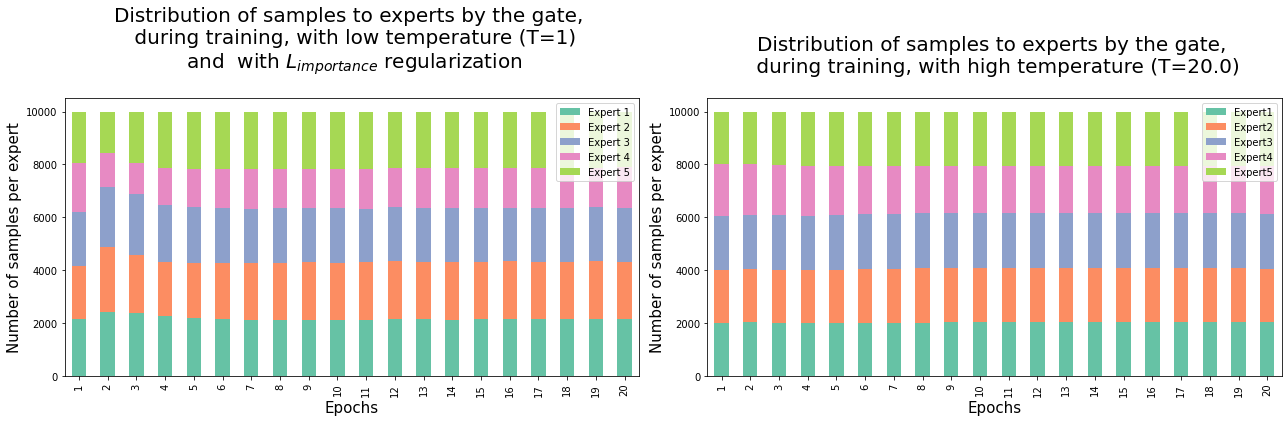

In [74]:
model_with_reg = 'mnist_dual_temp_with_reg_test'
temps = [20.0]
print(temps)
w_importance_range = [0.4]
print(w_importance_range)
caption = 'Distribution of samples to experts by the gate, \n during training, with low temperature (T=1)\n and  with '+r'$L_{importance}$'+ ' regularization \n'
plot_gate_prob(model_with_reg, temps, w_importance_range, total_experts=total_experts, 
               num_classes=num_classes, classes=range(num_classes), num_epochs=num_epochs, 
               testloader=testloader, caption=caption)

[1.1, 1.2000000000000002, 1.3000000000000003, 1.4000000000000004, 1.5000000000000004, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50]
[0.0]
Temperature 1.1
Importance 0.0
Sample sim 0.0


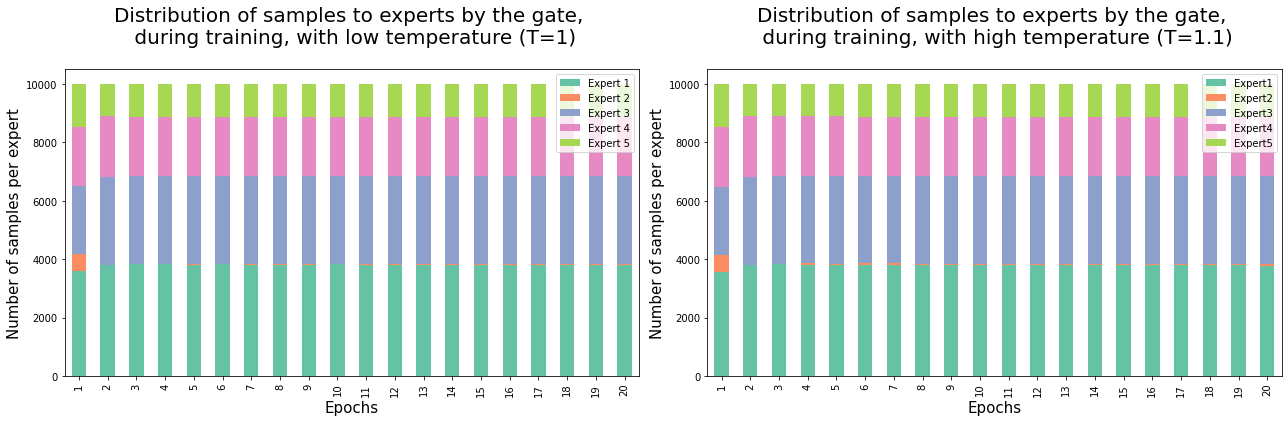

Temperature 1.2
Importance 0.0
Sample sim 0.0


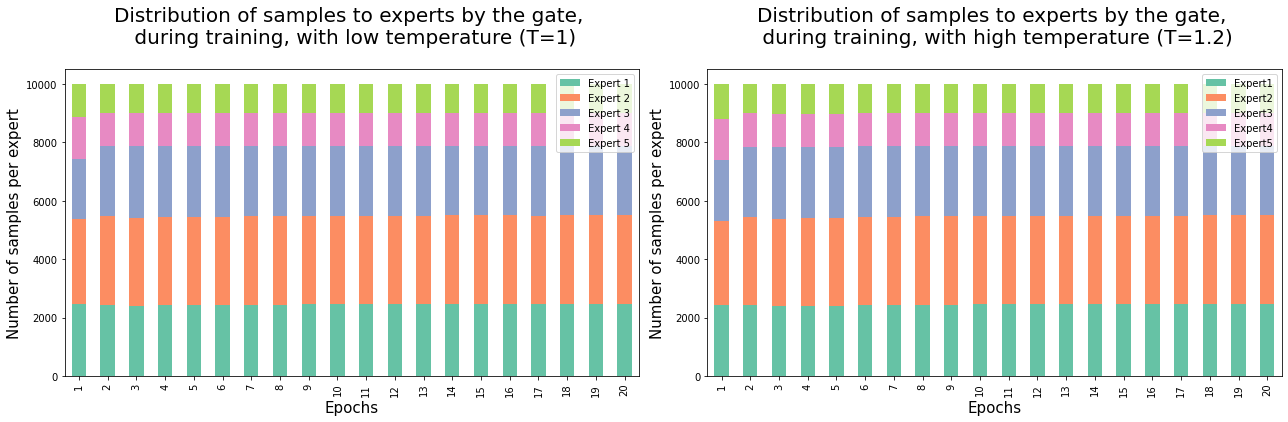

Temperature 1.3
Importance 0.0
Sample sim 0.0


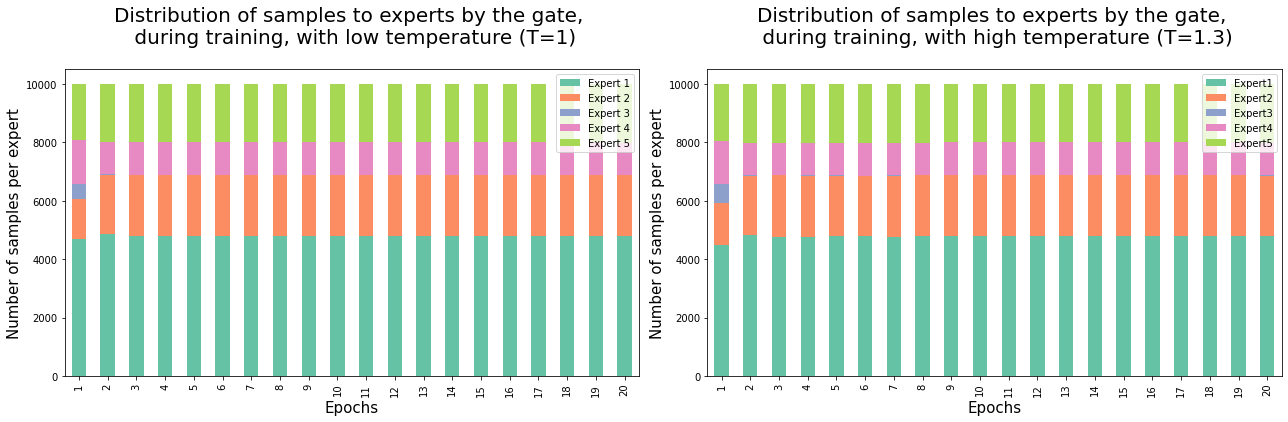

Temperature 1.4
Importance 0.0
Sample sim 0.0


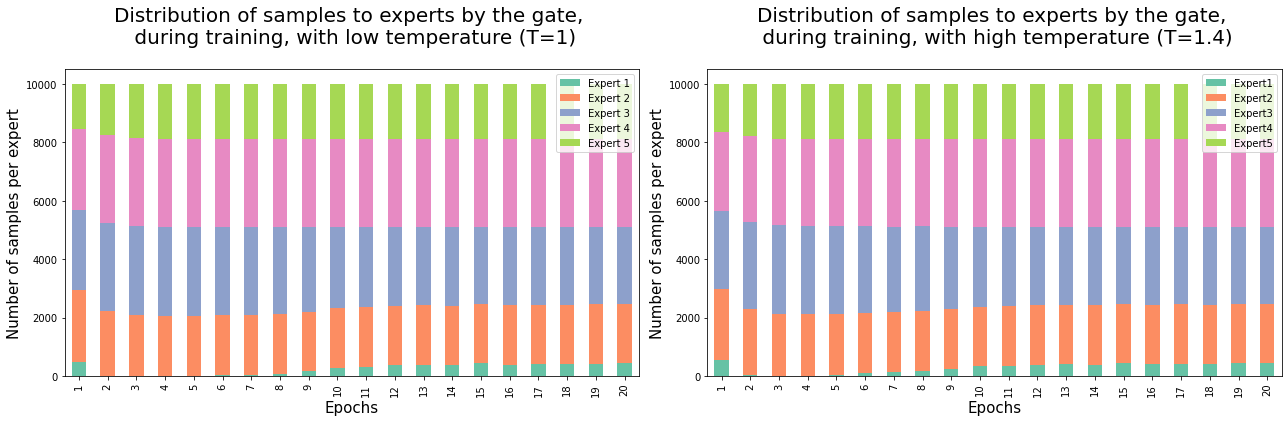

Temperature 1.5
Importance 0.0
Sample sim 0.0


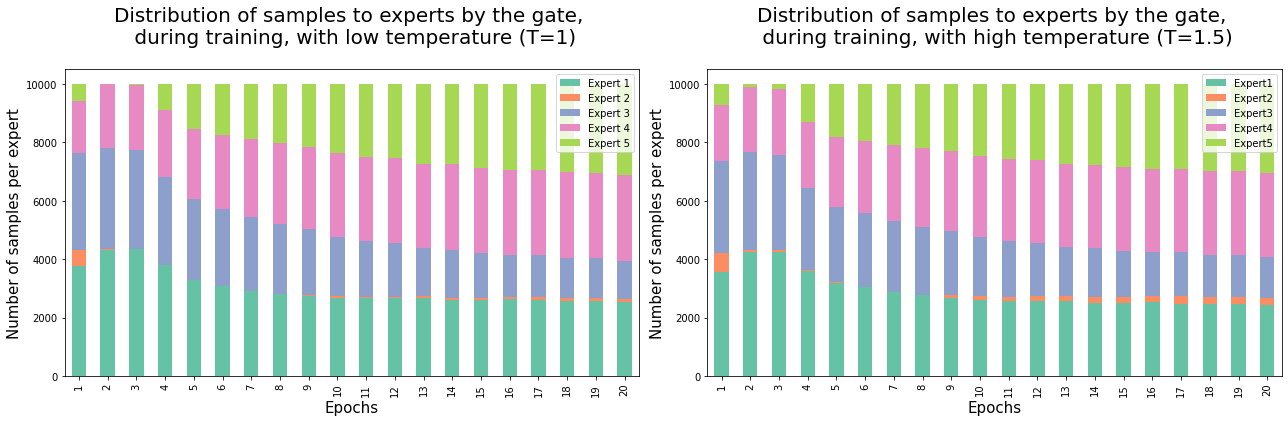

Temperature 2.0
Importance 0.0
Sample sim 0.0


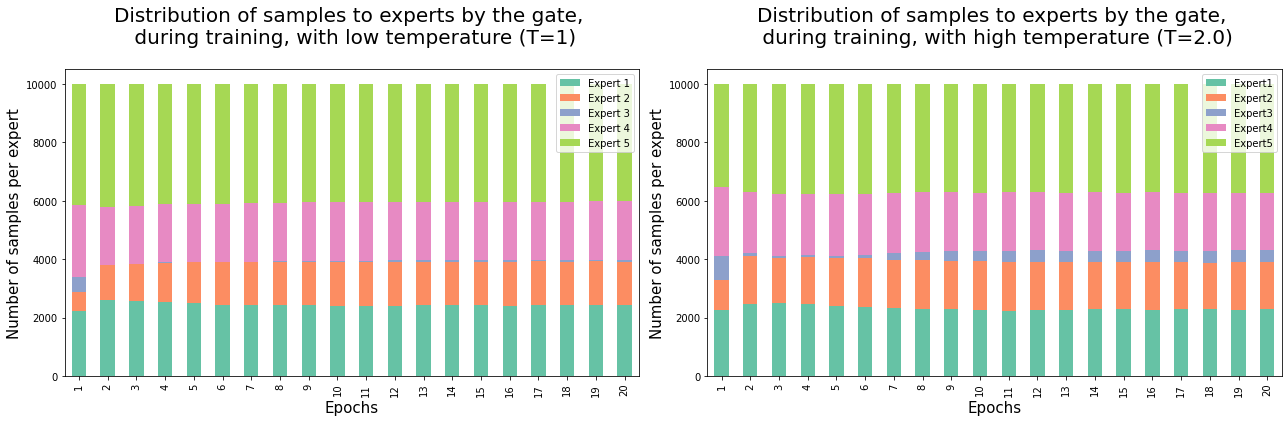

Temperature 4.0
Importance 0.0
Sample sim 0.0


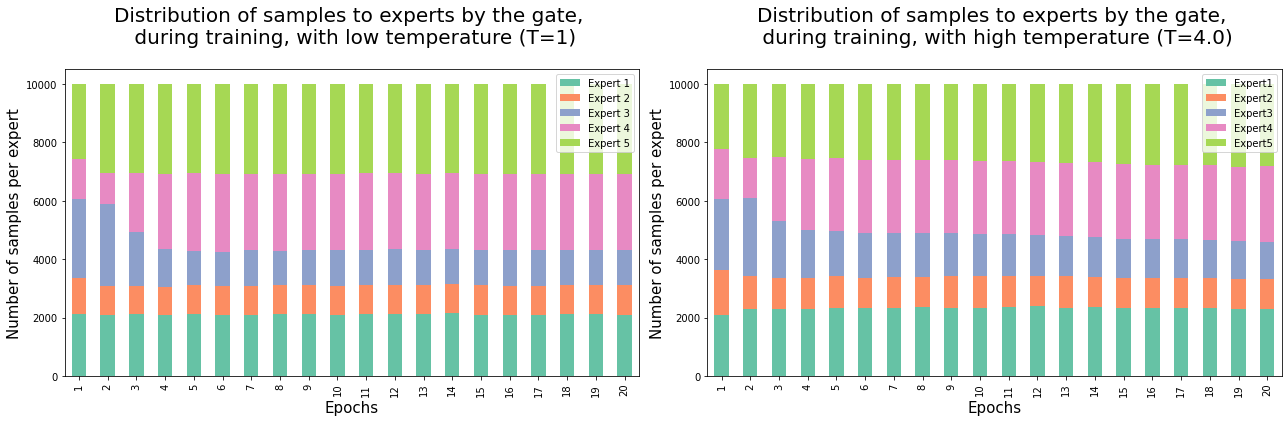

Temperature 6.0
Importance 0.0
Sample sim 0.0


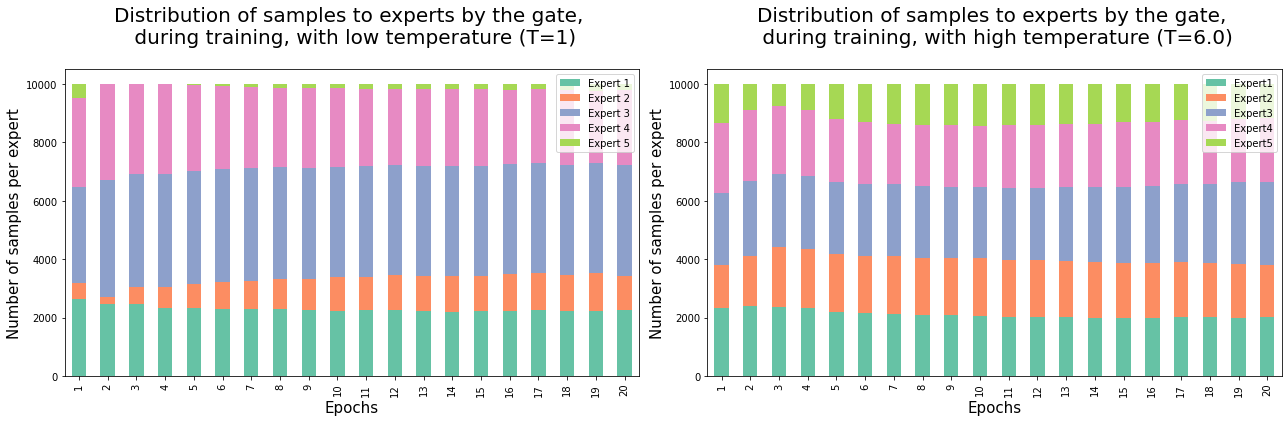

Temperature 8.0
Importance 0.0
Sample sim 0.0


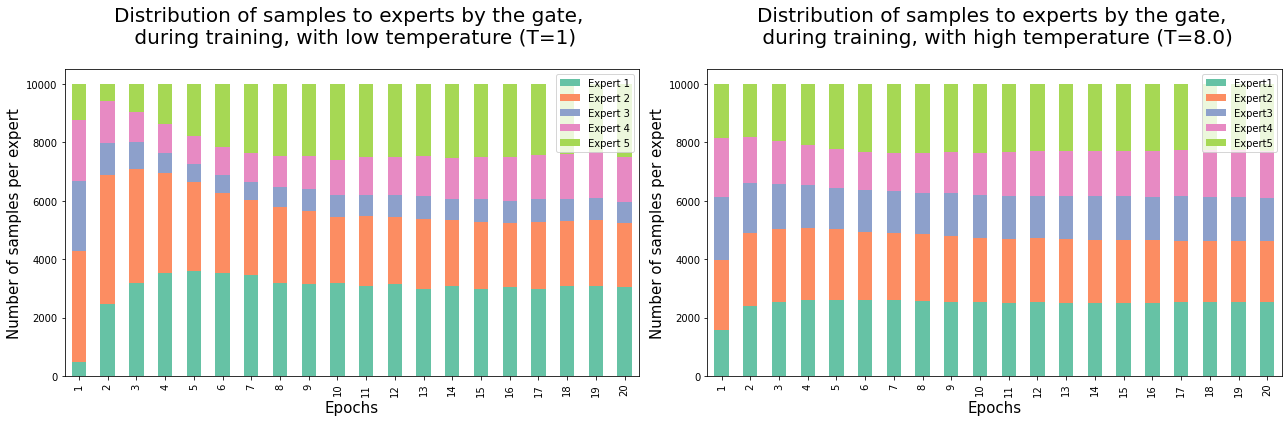

Temperature 10.0
Importance 0.0
Sample sim 0.0


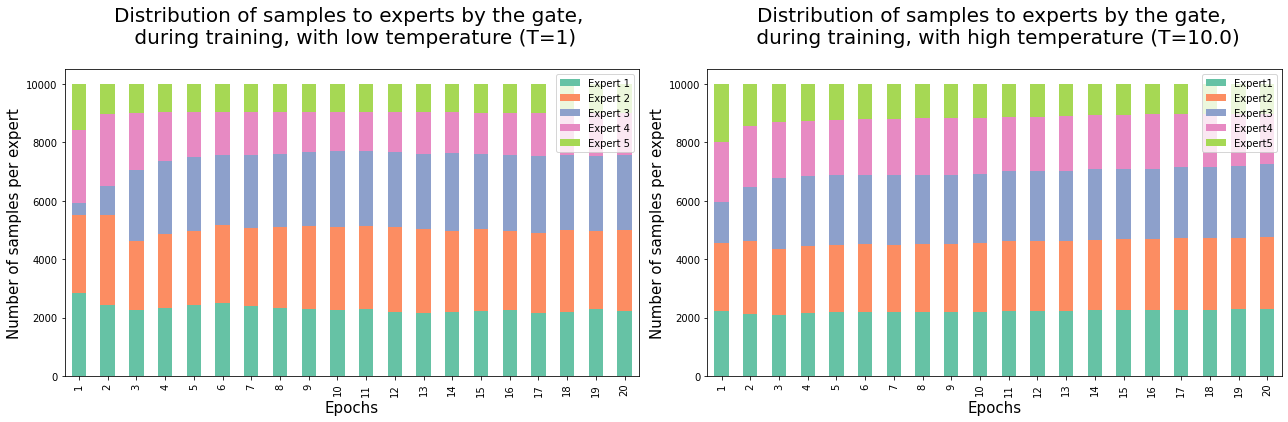

Temperature 12.0
Importance 0.0
Sample sim 0.0


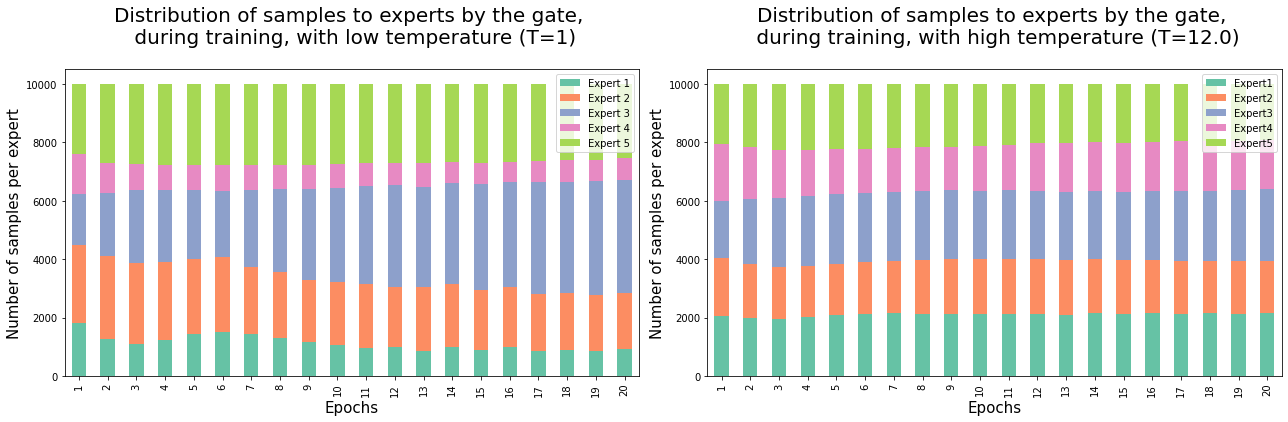

Temperature 14.0
Importance 0.0
Sample sim 0.0


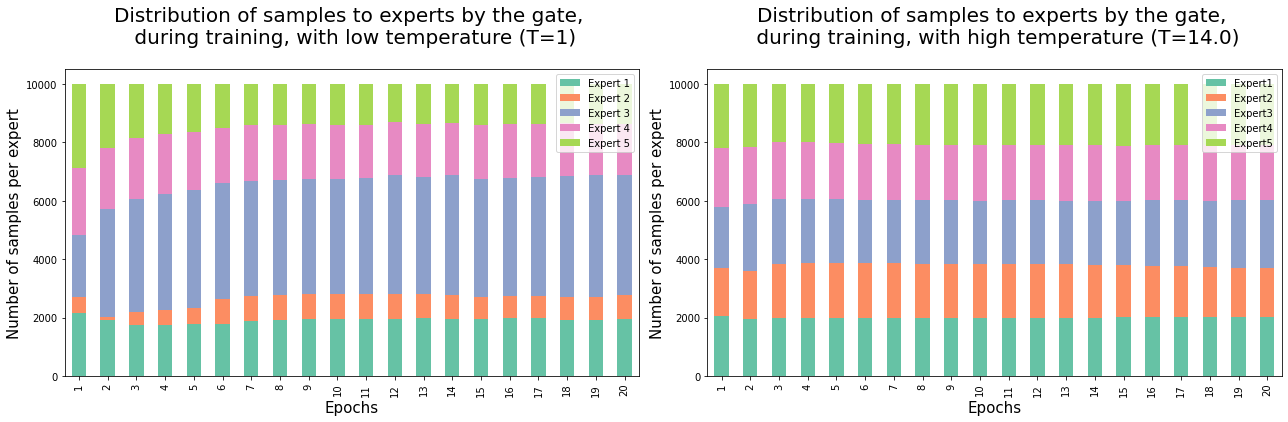

Temperature 16.0
Importance 0.0
Sample sim 0.0


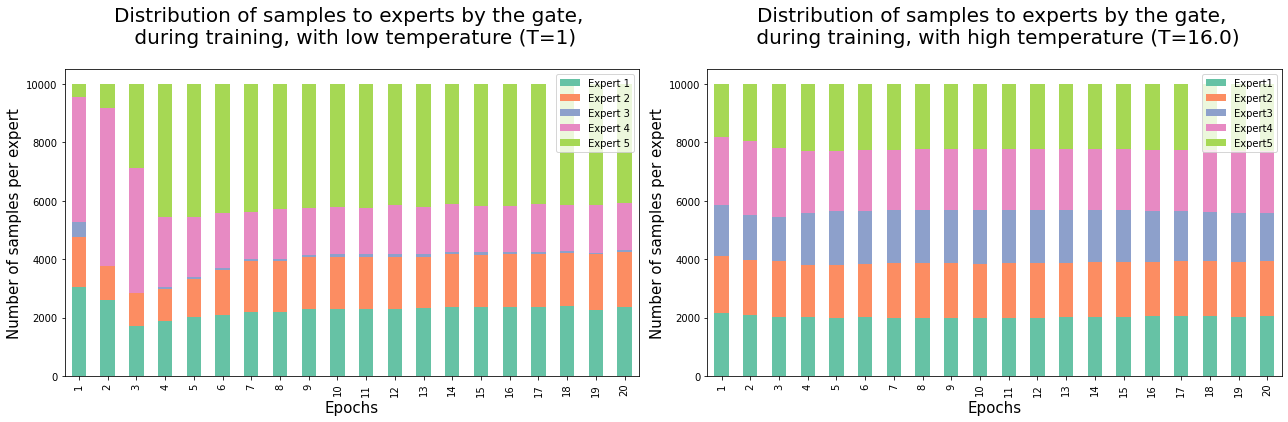

Temperature 18.0
Importance 0.0
Sample sim 0.0


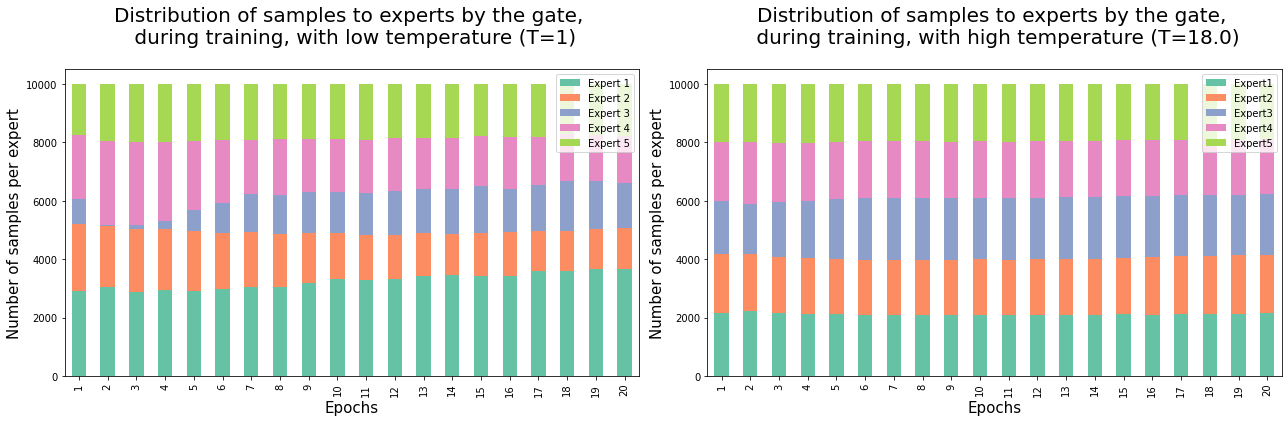

Temperature 20.0
Importance 0.0
Sample sim 0.0


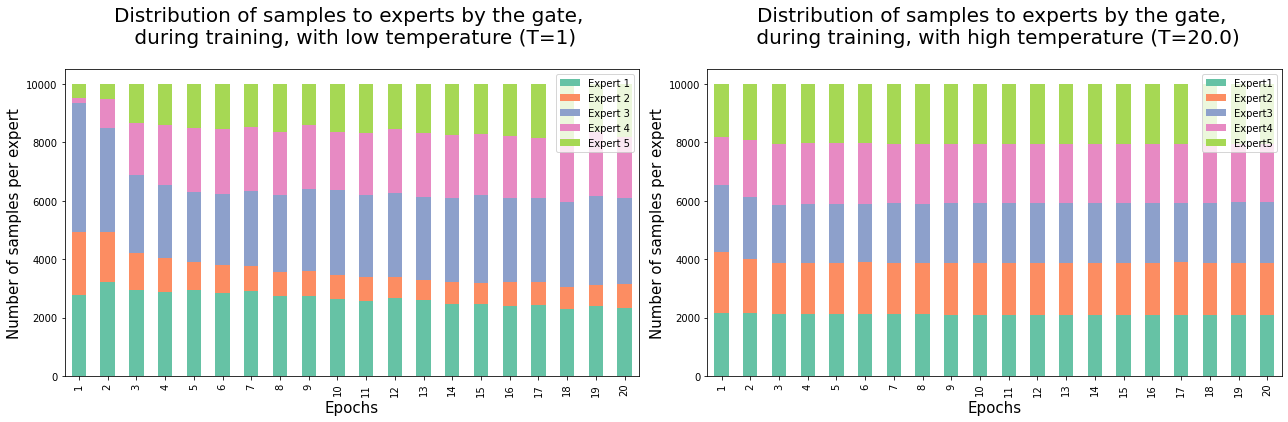

Temperature 25.0
Importance 0.0
Sample sim 0.0


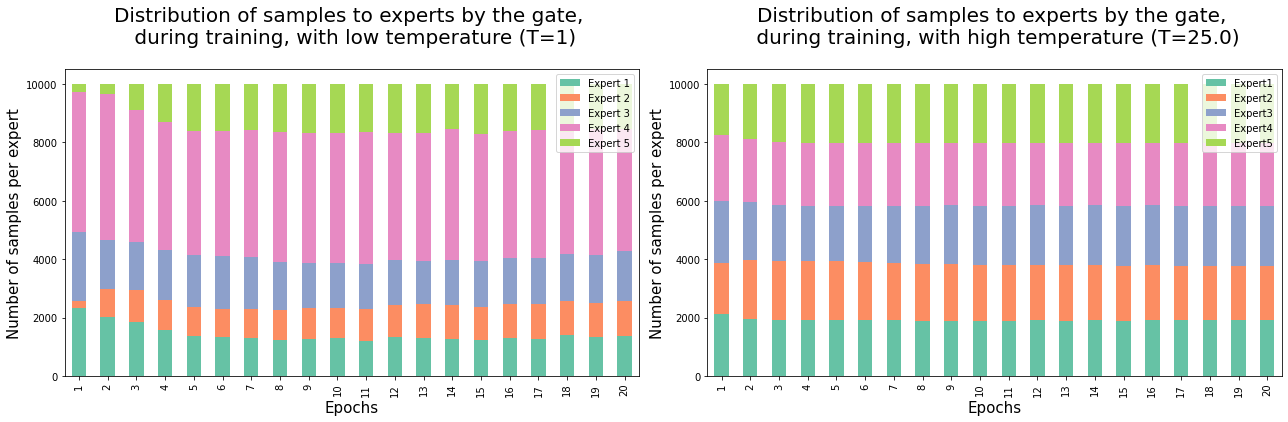

Temperature 30.0
Importance 0.0
Sample sim 0.0


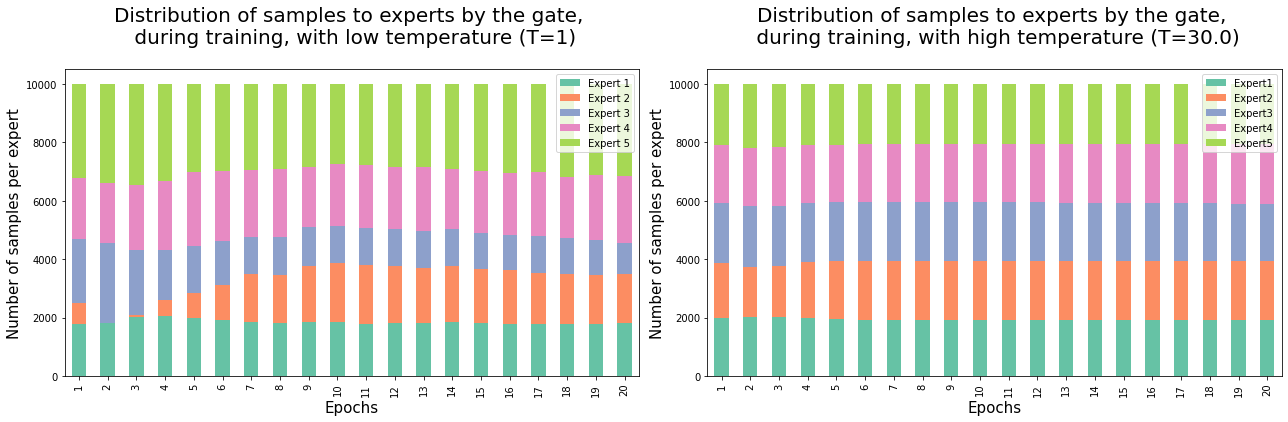

Temperature 35.0
Importance 0.0
Sample sim 0.0


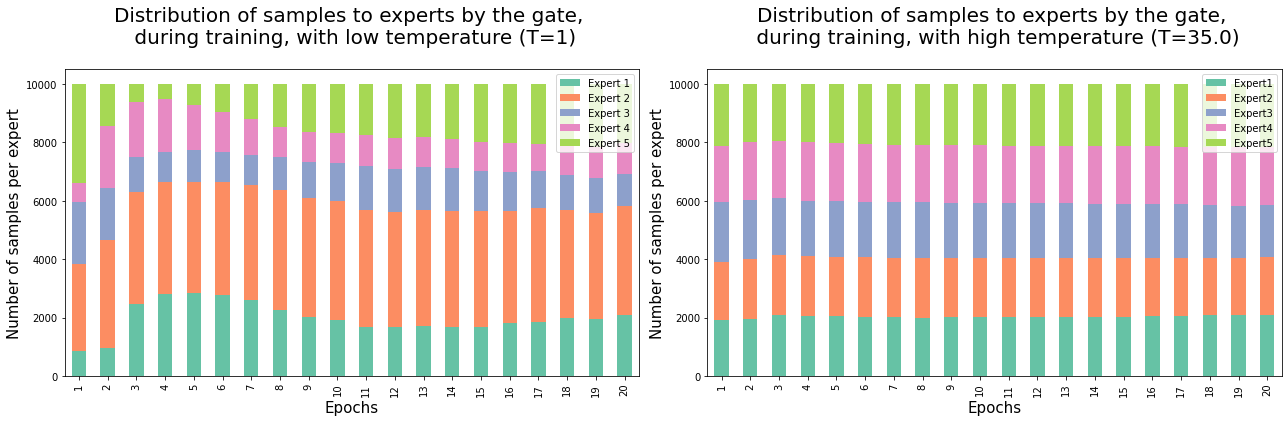

Temperature 40.0
Importance 0.0
Sample sim 0.0


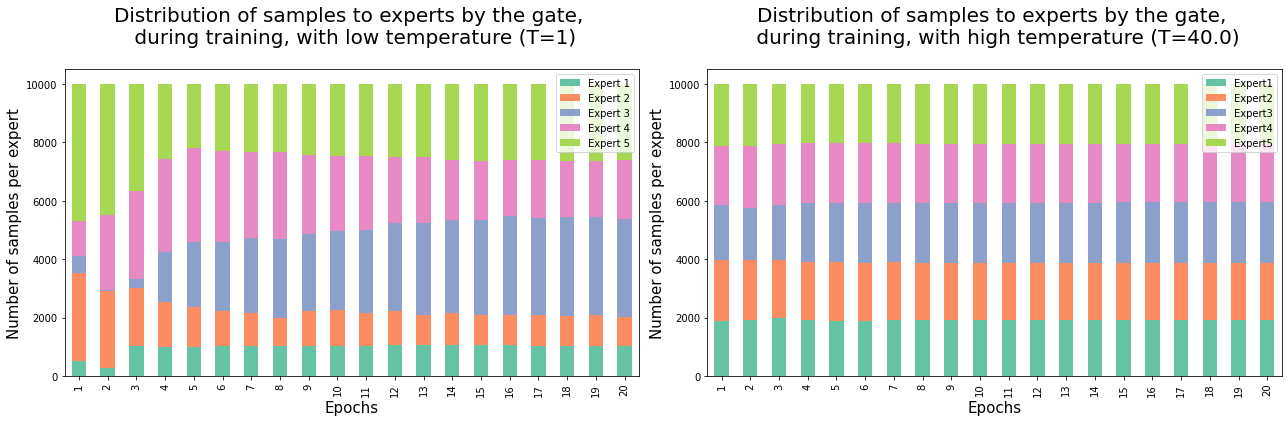

Temperature 45.0
Importance 0.0
Sample sim 0.0


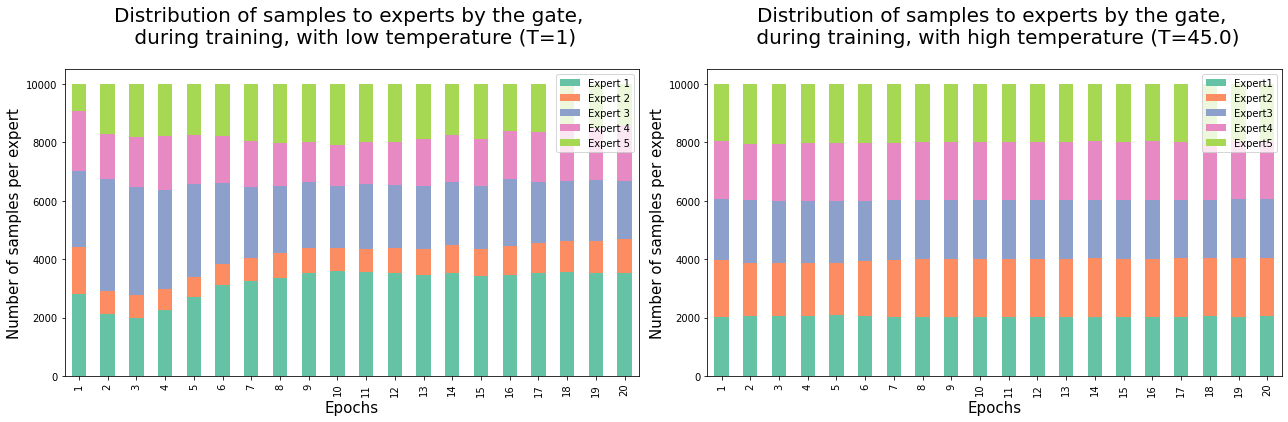

Temperature 50.0
Importance 0.0
Sample sim 0.0


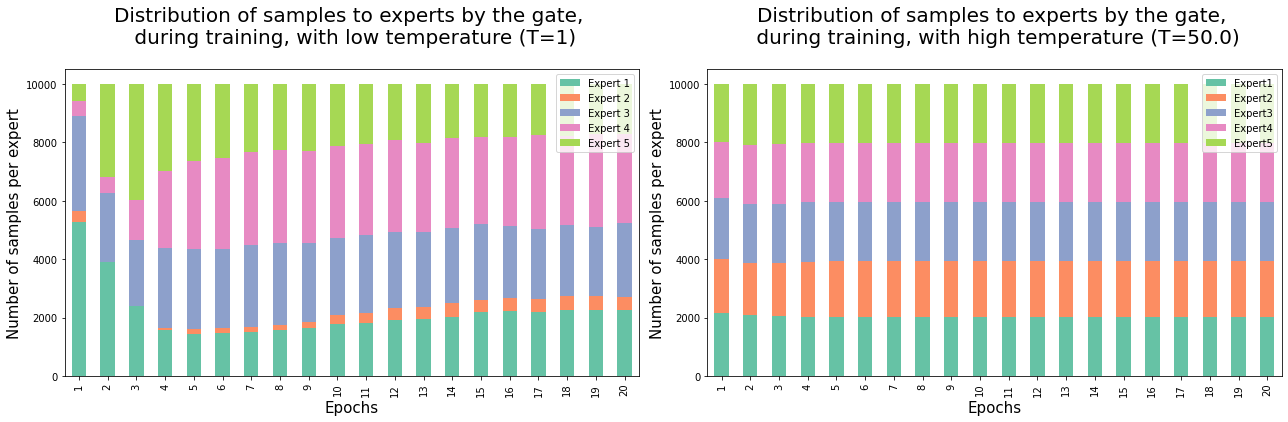

[1.0]
[0.0]
[0.0]
[1.0]
[0.2 0.4 0.6 0.8 1. ]
[0.0]
Temperature 1.0
Importance 0.2
Sample sim 0.0


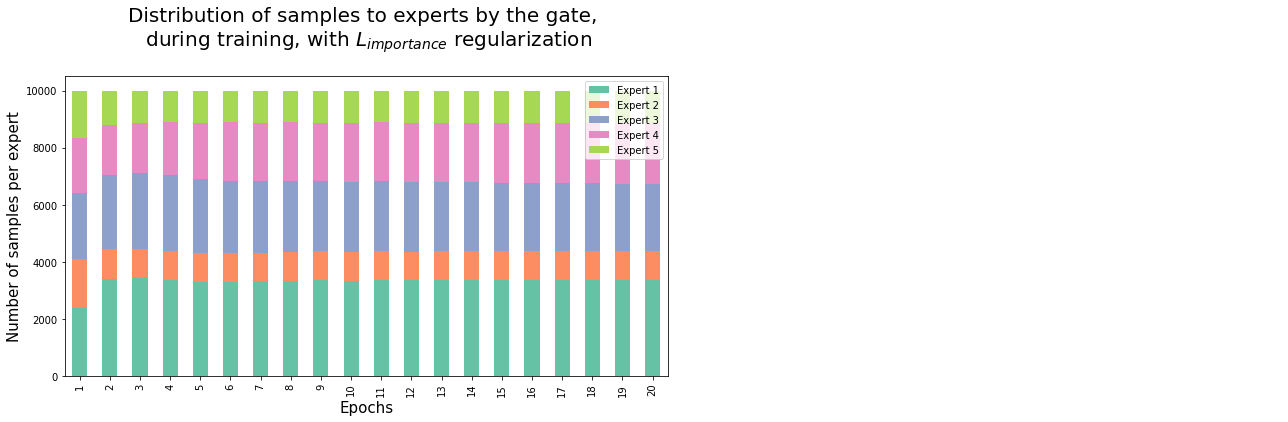

Temperature 1.0
Importance 0.4
Sample sim 0.0


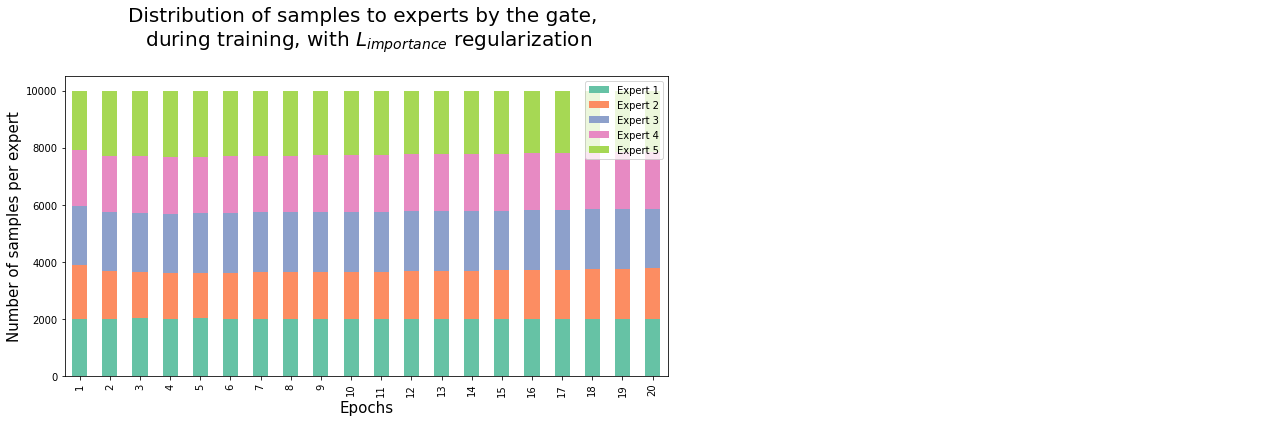

Temperature 1.0
Importance 0.6
Sample sim 0.0


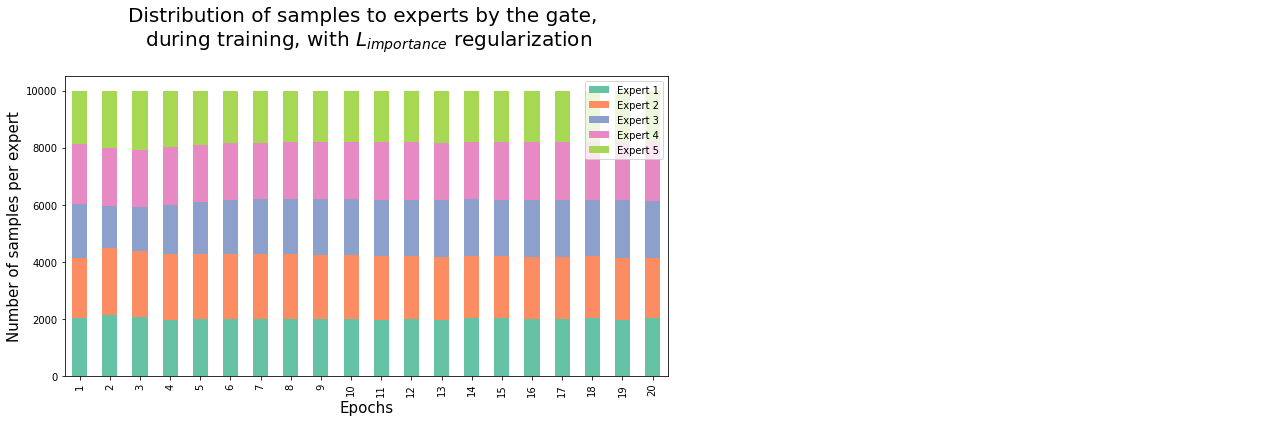

Temperature 1.0
Importance 0.8
Sample sim 0.0


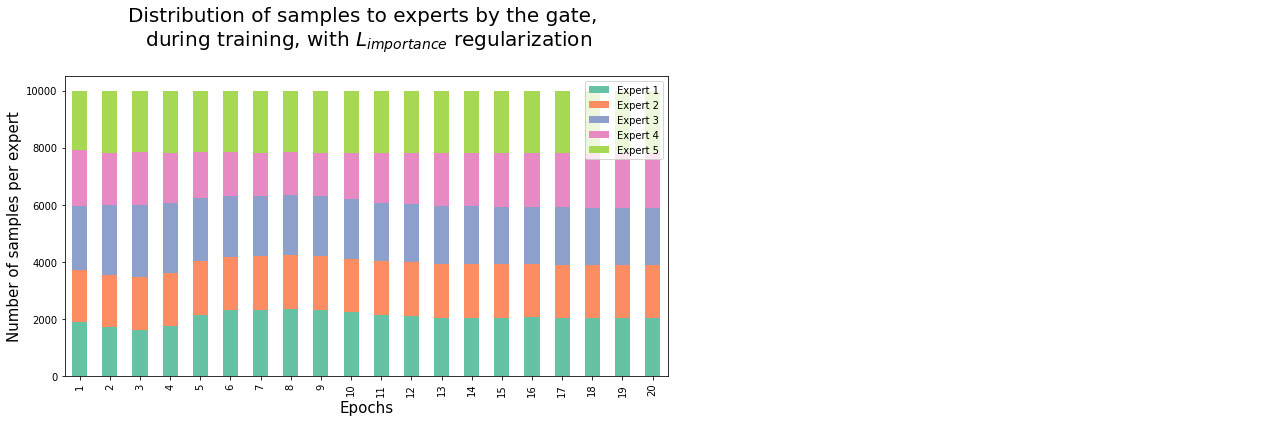

Temperature 1.0
Importance 1.0
Sample sim 0.0


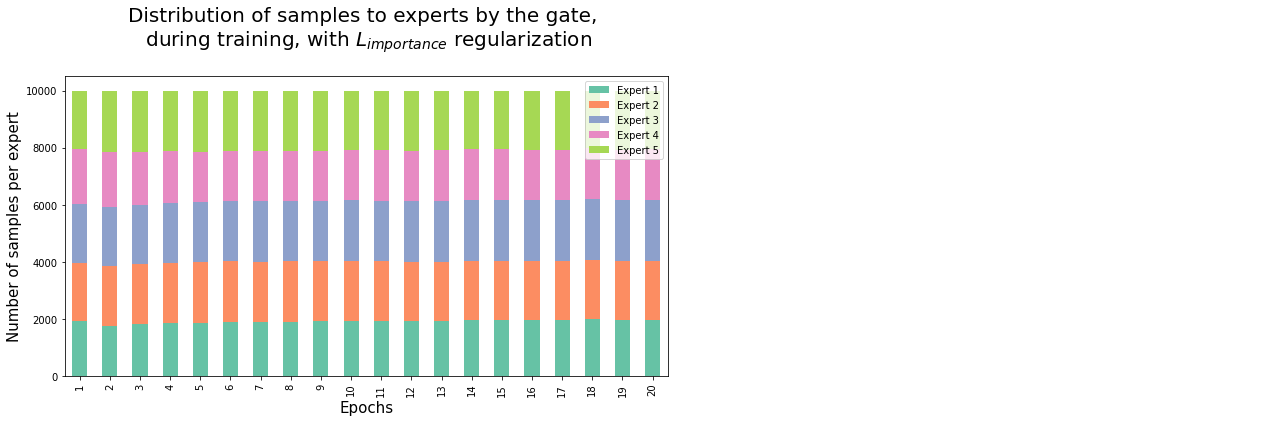

[20.0]
[0.4]
[0.0]
Temperature 20.0
Importance 0.4
Sample sim 0.0


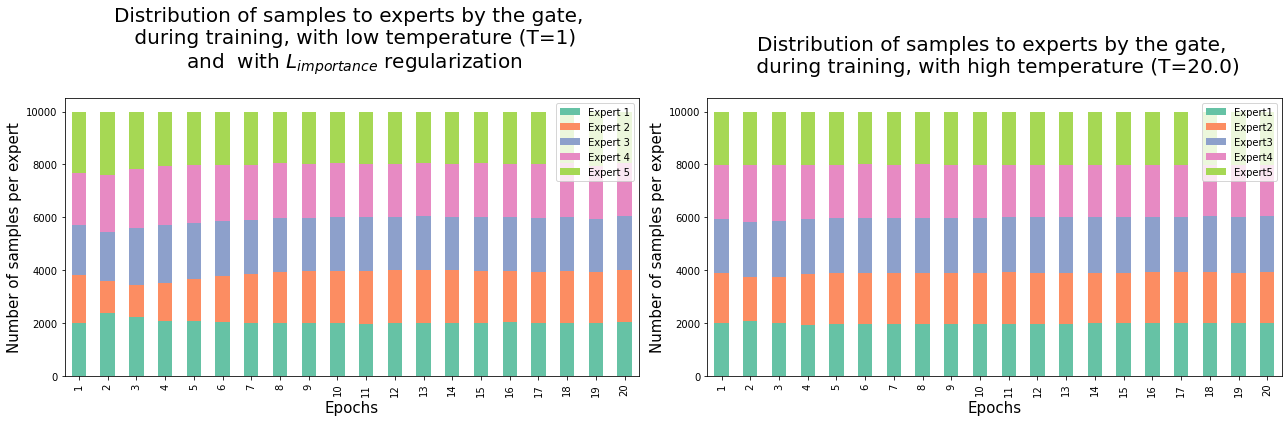

In [98]:
model_with_reg = 'mnist_with_reg_test'
temps = [1.0]
print(temps)
w_importance_range = np.arange(0.2,1.1,0.2)
print(w_importance_range)
w_sample_sim_range = [0.0]
print(w_sample_sim_range)
caption = 'Distribution of samples to experts by the gate, \n during training, with '+r'$L_{importance}$'+ ' regularization \n'
plot_gate_prob(model_with_reg, temps, w_importance_range, w_sample_sim_range, 
               total_experts, num_classes, range(num_classes), num_epochs, 
               testloader, caption)



In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_on_validation'

In [ ]:
num_epochs = 20

In [ ]:
# Set train and test size
trainsize = 2048
testsize = 2000
valsize = 10048

In [ ]:
# Load and split data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=transform)

batch_size = 64
# dataloaders
trainloaders = []
for i in range(total_experts):
    dataset = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(i*trainsize,(i*trainsize)+trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)
    trainloaders.append(dataset)
    all_labels = []
    for inputs, labels in dataset:
        all_labels.append(labels)
    all_labels = torch.stack(all_labels)
i+=1
valloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(i*trainsize,(i*trainsize)+valsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(0, valsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(0,testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))
print(len(trainloaders))

In [ ]:
def train_experts(expert_models, trainloaders, accuracy, num_epochs):
    for i, expert in enumerate(expert_models):
        print('Training Expert ', i)
        optimizer_expert = optim.RMSprop(expert.parameters(),
                                      lr=0.001, momentum=0.9)

        loss_criterion = cross_entropy_loss()
        for epoch in range(num_epochs):
            running_loss = 0.0
            train_running_accuracy = 0.0
            num_batches = 0
            for inputs, labels in trainloaders[i]:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = expert(inputs)

                optimizer_expert.zero_grad()
                loss = loss_criterion(outputs, labels)

                loss.backward()

                optimizer_expert.step()

                running_loss += loss.item()

                outputs = expert(inputs)

                acc = accuracy(outputs, labels)
                train_running_accuracy += acc

                num_batches += 1

            print('epoch %d' % epoch,
                  'training loss %.2f' % (running_loss/num_batches),
                   ', training accuracy %.2f' % (train_running_accuracy/num_batches),
                   )

In [ ]:
# Train models model_1

n_run_models = []
cv = []
accuracies = []
for e_epoch in range(1,6):
    for g_epoch in range(1,2):
        models = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
            }

        # Build model with un-trained experts
        for key, val in models.items():
            print('Model:', key, total_experts, 'Experts')
            print('Building model with un-trained experts')
            # copy and save the expert models to save the parameters

            expert_models = experts(total_experts, [None]*total_experts, num_classes, 
                                             [num_classes]*total_experts).to(device)

            gate_model = gate_layers(total_experts, num_classes).to(device)

            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                          lr=0.001, momentum=0.9)
            for epoch in range(1):
                print('\nTraining Experts')
                train_experts(expert_models, trainloaders, accuracy, e_epoch)


                moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                                         experts=expert_models, gate=gate_model)


                print('\nTraining Gate')
                hist = moe_model.train_on_validation(valloader, testloader,  val['loss'], 
                                                     optimizer_gate=optimizer_gate, 
                                                     accuracy=accuracy, epochs=g_epoch)
            moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                                         experts=expert_models, gate=gate_model)
            
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.001, momentum=0.9)
            print('\nTraining MoE Model')
            hist = moe_model.train(trainloader, testloader,  val['loss'], 
                                                 optimizer_moe=optimizer_moe, 
                                                 accuracy=accuracy, epochs=num_epochs)
                
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = moe_model(inputs)
                gate_outputs = moe_model.gate_outputs
                gd = torch.sum(gate_outputs, dim=0)
                cv.append((torch.std(gd)/torch.mean(gd)).item())
                accuracies.append(accuracy(outputs, labels).item())
            print(cv[-1], accuracies[-1])
            
            val['experts'][total_experts] = {'model':moe_model, 'history':hist}
        n_run_models.append(models)
        

# Save all the trained models
plot_file = generate_plot_file(model_1, str(num_classes)+'_'+str(total_experts)+'_models.pt')
print(plot_file)
torch.save(n_run_models, open(os.path.join(model_path, plot_file),'wb'))

In [ ]:
torch.save([cv,accuracies], open('results_cv_accuracies.pt','wb'))

In [ ]:
cv, accuracies = torch.load(open('results_cv_accuracies.pt','rb'))

In [ ]:
cv = np.transpose(np.around(cv, decimals=3))
accuracies = np.transpose(np.around(accuracies, decimals=2))
cv

In [ ]:
epochs = []
for i in range(1,6):
    for j in range(1,2):
        epochs.append([[i],[j]])
epochs = np.transpose(np.hstack(epochs))
values = np.transpose(np.vstack((cv,accuracies)))
from numpy.lib import recfunctions as rfn
data = np.hstack((epochs,values))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

m = model_1
total_experts = 5
plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')
models_list = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
print(plot_file)

# columns = ('Expert Epoch', 'Expert Gate', 'CV', 'Accuracy')
# # Add a table at the bottom of the axes
# plt.box(on=None)
# ax = plt.gca()
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# the_table = plt.table(cellText=data,
#                       colLabels=columns,
#                      loc='center')
# image_file = generate_plot_file(m, 'cv_accuracy_table_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
# print(image_file)
# plt.savefig(os.path.join(fig_path, image_file))
# plt.show()

# fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
# sns.lineplot(x=cv,y=accuracies, ax=ax)
# plt.show()
                      
for i, models in enumerate(models_list):
    # Plotting for the model of the first run
    print('\nE epoch:', data[i,0], 'G epoch:',data[i,1])
    for e_key, e_val in models.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        for images, labels in testloader:
            fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
            images, labels = images.to(device), labels.to(device)
            moe_model = e_val['experts'][total_experts]['model']

            # predict the classes for test data
            pred = moe_model(images)
            pred_labels = torch.argmax(pred, dim=1)

            expert_outputs = moe_model.expert_outputs
            gate_outputs = moe_model.gate_outputs

            # plot the confusion matrix
            print('\nConfusion matrix of predictions of the MNIST test data by MoE expectation model')
            sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d')
            image_file = generate_plot_file(m, 'conf_mat_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig1.savefig(os.path.join(fig_path, image_file))
            plt.show()

            fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

            # get the experts selected by the gate for each sample
            pred_gate_labels = torch.argmax(gate_outputs, dim=1)

            # plot the expert selection table
            print('\nExperts used by the gate for classification of each digit')
            class_expert_table = np.asarray([[0] * num_classes]*total_experts)
            for label, expert in zip(labels, pred_gate_labels):
                class_expert_table[expert,label] += 1
            sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax2)

            image_file = generate_plot_file(m, 'class_expert_table_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig2.savefig(os.path.join(fig_path, image_file))
            plt.show()

In [ ]:
new_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(valsize, 3*valsize)), 
                                          batch_size=2*valsize,
                                          shuffle=True)

In [ ]:
image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))
print(len(new_trainloader.dataset))

In [ ]:
indices = None
for inputs, labels in new_trainloader:
    inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
    outputs = sm(inputs)
    indices = torch.where((torch.argmax(outputs, dim=1)==labels)==True)[0]

In [ ]:
new_trainloader_1 = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, (indices+valsize)[0:valsize]), 
                                          batch_size=batch_size,
                                          shuffle=True)
print(len(new_trainloader.dataset))

In [ ]:
model_3 = 'selected_data'

In [ ]:
# Train models model_1, model_2 and model_3 for 10 runs
models = {
    'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
    }

# Build model with un-trained experts
for key, val in models.items():
    print('Model:', key, total_experts, 'Experts')
    # copy and save the expert models to save the parameters
    expert_models = experts(total_experts, [None]*total_experts, num_classes, 
                                 [num_classes]*total_experts).to(device)

    gate_model = gate_layers(total_experts, num_classes).to(device)

    moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                             experts=expert_models, gate=gate_model)


    optimizer_moe = optim.RMSprop(moe_model.parameters(),
                              lr=0.001, momentum=0.9)
    hist = moe_model.train(new_trainloader_1, testloader,  val['loss'], optimizer_moe, 
                           w_importance=1.0,
                           accuracy=accuracy, epochs=num_epochs)
    val['experts'][total_experts] = {'model':moe_model, 'history':hist}

# Save all the trained models
plot_file = generate_plot_file(model_3, 'importance_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')
print(plot_file)
torch.save(models,open(os.path.join(model_path, plot_file),'wb'))

In [ ]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

m = model_3
total_experts = 5
plot_file = generate_plot_file(model_3, 'importance_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')
models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
                      
# Plotting for the model of the first run
for e_key, e_val in models.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']

        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)
        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # plot the confusion matrix
        print('\nConfusion matrix of predictions of the MNIST test data by MoE expectation model')
        sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d')
        image_file = generate_plot_file(m, 'conf_mat_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        fig1.savefig(os.path.join(fig_path, image_file))
        plt.show()

        fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax2)

        image_file = generate_plot_file(m, 'class_expert_table_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        fig2.savefig(os.path.join(fig_path, image_file))
        plt.show()
        
        misclassified = torch.where((pred_labels == labels)==False)[0]
        for i in range(num_classes):
            indices = labels[misclassified]==i
            print(i,' is misclassified as ', pred_labels[misclassified][indices])
            images_orig = images[misclassified][indices]
            img_grid = torchvision.utils.make_grid(images_orig)
            # show images
            imshow(img_grid, one_channel=True)
